#Setup Functions

In [ ]:
!pip install transformers
!pip install unidecode
!pip install sentencepiece
!pip install scikit-learn
!pip install torchsampler
!pip install -Uqq ipdb
import ipdb
%pdb off


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import spacy

import os

import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import softmax


import time
from datetime import timedelta, datetime
import random


from collections import defaultdict
from datetime import timedelta, datetime
import glob

from unidecode import unidecode

import nltk
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, AdamW

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import spacy
from nltk.tokenize import word_tokenize

import os
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')



# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

from sklearn import metrics



from google.colab import drive
drive.mount('/content/drive')

from google.colab import files


In [ ]:
#!pip install spacy-transformers

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

distinct_techniques = [
'Appeal_to_Authority',
'Appeal_to_fear-prejudice',
'Bandwagon,Reductio_ad_hitlerum',
'Black-and-White_Fallacy',
'Causal_Oversimplification',
'Doubt',
'Exaggeration,Minimisation',
'Flag-Waving',
'Loaded_Language',
'Name_Calling,Labeling',
'Repetition',
'Slogans',
'Thought-terminating_Cliches',
'Whataboutism,Straw_Men,Red_Herring'
]


seed = 42
use_fp16 = False
bs = 8


from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 5
home_dir = "/content/drive/MyDrive/prop_det/"
data_dir = "/content/drive/MyDrive/prop_det/datasets"

model_type = 'roberta'
pretrained_model_name = 'roberta-large'
#pretrained_model_name = 'roberta-base'
#pretrained_model_name='bert-large-cased'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 5
home_dir = "/content/drive/MyDrive/prop_det/"
data_dir = "/content/drive/MyDrive/prop_det/datasets"
#import spacy_transformers

#nlp = spacy.load('en_core_web_trf') # highest acc model


In [ ]:
!pip install pymongo
!pip install -Uqq ipdb
import ipdb
%pdb off

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Scrape Articles and save to MongoDB


The following chapter contains the main code utilized for scraping the Russian and American news articles.

Please bear in mind, that initially MongoDB was used to store the articles.

This setup was not done in Google Colab, therefore the code of this chapter is solely used for demonstration.

It is not runable.


## Scraping American News

### Fox News


In [ ]:
import sys

import pymongo
import requests
from pymongo.errors import DuplicateKeyError
import dateutil.parser as dp


def main():
    offset = 0


    fox_json_wire = access_api(offset)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    myclient, mydatabase, mycollection = access_mongo()
    store_links_mongo(fox_json_wire, mycollection)

    while True:
        offset += 30
        # print(var + 1)
        fox_json_new = access_api(offset)
        store_links_mongo(fox_json_new, mycollection)




def access_api(offset):
    url = f"https://www.foxnews.com/api/article-search?searchBy=tags&values=fox-news%2Fworld%2Fconflicts%2Fukraine&excludeBy=tags&excludeValues=&size=30&from={offset}"

    payload = {}
    headers = {
        'Cookie': '_csrf=lS6_IWmFy9EgBo0i79QnH77X'
    }

    fox_response = requests.request("GET", url, headers=headers, data=payload)

    try:
        fox_json = fox_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)
    return fox_json


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    mycollection = mydatabase["fox_com_links"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def store_links_mongo(fox_json, mycollection):
    for fox_article in fox_json:
        link = fox_article["url"]
        #if "abcnews.go.com" in link and ("/video" not in link) and ("/images" not in link) and (("/Politics" in link) or ("/International" in link)):
        parsed_date = dp.parse(fox_article["publicationDate"])
        date_stamp = str(parsed_date.timestamp()).split(".")[0]
        stop_date = 1640995201
        article = {
            "fox_article_id": link,
            "date": date_stamp,
            "title": fox_article["title"].replace("\n", "").replace("\t", "").strip(),
            "link": "https://www.foxnews.com" + link
        }
        print(parsed_date)
        if int(date_stamp) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue
        else:
            sys.exit(1)



In [ ]:
import pymongo
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from datetime import datetime


class FoxNewsSpider(scrapy.Spider):
    name = 'FoxNewsSpider'
    allowed_domains = ['foxnews.com']
    start_urls = ['http://foxnews.com/']

    def start_requests(self):
        entries = self.access_mongo()
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"fox_article_id": entry["fox_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='headline']/text()").get()
        article_subtitle = response.xpath("//*[@class='sub-headline speakable']/text()").get()
        article_body_list = response.xpath("//*[@class='article-body']//p//text()").getall()
        article_body = " ".join(article_body_list)
        fox_article_id = response.meta["fox_article_id"]
        link = response.meta["link"]
        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "fox_article_id": fox_article_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(article)
        article_collection_fox = self.access_mongo_article_store()
        try:
            article_collection_fox.insert_one(article)
        except DuplicateKeyError:
            print("duplicate was not inserted")

    def access_mongo(self):
        my_client = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
        my_database = my_client["american_news_articles"]
        my_collection = my_database["fox_com_links"]
        entries = my_collection.find()

        return entries

    def access_mongo_article_store(self):
        my_client = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
        my_database = my_client["american_news_articles"]
        my_collection = my_database["fox_com_articles"]
        return my_collection


### ABC News

In [ ]:
import sys

import dateutil.parser as dp
import pymongo
import requests
from pymongo.errors import DuplicateKeyError


def main():
    offset = 0
    url_wire = "https://abcnews.go.com/meta/api/search?q=ukraine&limit=100&sort=date-asc&type=&section=&totalrecords=true&after=2023-03-01"
    url_story = "https://abcnews.go.com/meta/api/search?q=ukraine&limit=100&sort=date&type=&section=&totalrecords=true&type=Story"

    abc_json_wire = access_api(offset, url_wire)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    myclient, mydatabase, mycollection = access_mongo()
    store_links_mongo(abc_json_wire, mycollection)

    while True:
        offset += 100
        # print(var + 1)
        abc_json_new = access_api(offset, url_wire)
        store_links_mongo(abc_json_new, mycollection)

    abc_json_story = access_api(offset, url_story)
    store_links_mongo(abc_json_story, mycollection)

    while True:
        offset += 100
        # print(var + 1)
        abc_json_new = access_api(offset, url_story)
        store_links_mongo(abc_json_new, mycollection)


def access_api(offset, url):
    payload = {}
    headers = {
        'Cookie': '_dcf=0; region=emea'
    }
    next_scrape = url + "&offset=" + str(offset)
    print(next_scrape)
    abc_response = requests.request("GET", next_scrape, headers=headers, data=payload)

    try:
        abc_json = abc_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)
    return abc_json


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    mycollection = mydatabase["abc_com_links"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def store_links_mongo(abc_json, mycollection):
    for abc_article in abc_json["item"]:
        link = abc_article["link"]
        if "abcnews.go.com" in link and ("/video" not in link) and ("/images" not in link) and (("/Politics" in link) or ("/International" in link)):
            parsed_date = dp.parse(abc_article["pubDate"])
            date_stamp = str(parsed_date.timestamp()).split(".")[0]
            stop_date = 1645660801
            article = {
                "abc_article_id": abc_article["guid"]["text"],
                "date": date_stamp,
                "title": abc_article["title"].replace("\n", "").replace("\t", "").strip(),
                "link": link
            }
            print(abc_article["pubDate"])
            #if int(date_stamp) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue
            #else:
            #    sys.exit(1)


main()


In [ ]:
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from datetime import datetime
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class AbcNewsSpider(scrapy.Spider):
    name = 'AbcNewsSpider'
    allowed_domains = ['abcnews.go.com']
    start_urls = ['http://abcnews.go.com/']
    client_name = "american_news_articles"
    collection_name_link_store = "abc_com_links"
    collection_name_article_store = "abc_com_articles"

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"abc_article_id": entry["abc_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//h1/text()").get()
        article_subtitle = response.xpath("//*[@class='Ekqk yuUa lqtk TjIX aGjv ']/text()").get()
        article_body_list = response.xpath("//*[@class='xvlf ZRif TKoO eaKK ']//text()").getall()
        article_body = " ".join(article_body_list)
        abc_article_id = response.meta["abc_article_id"]
        link = response.meta["link"]
        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "abc_article_id": abc_article_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": "NULLZ",
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        date_obj = datetime.fromtimestamp(int(date))

        # Format the datetime object as a string
        date_str = date_obj.strftime("%Y-%m-%d")
        print(date_str)
        article_collection_abc = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_abc.insert_one(article)
        except DuplicateKeyError:
            print("duplicate was not inserted")


### CBS News


In [ ]:
import sys

import dateparser
import pymongo
import requests
from bs4 import BeautifulSoup
from pymongo.errors import DuplicateKeyError


def main():

    offset = 1


    cbs_json_wire = access_api(offset)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    myclient, mydatabase, mycollection = access_mongo()
    store_links_mongo(cbs_json_wire, mycollection)

    while True:
        offset += 1

        # print(var + 1)
        cbs_json_new = access_api(offset)
        store_links_mongo(cbs_json_new, mycollection)





def access_api(offset):
    url = f"https://www.cbsnews.com/ukraine-crisis/{offset}/"
    print(url)
    payload = {}
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
        'Cookie': 'CBS_INTERNAL=0; fly_device=desktop; fly_geo={"countryCode": "DE", "region": "BY", "dma": "276005", "connection": { "type": "broadband"}}'
    }

    cbs_response = requests.request("GET", url, headers=headers, data=payload)

    return cbs_response.text


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    mycollection = mydatabase["cbs_com_links"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def store_links_mongo(cbs_response, mycollection):
    soup = BeautifulSoup(cbs_response, features="lxml")
    list_contents = soup.find('div', {'class': 'col-8 nocontent'}).find_all("article")
    # list_contents = soup.findAll('p', {'class': 'category'})
    fallback_date = ""
    for cbs_article in list_contents:
        link = cbs_article.find("a").get("href")
        if "/news" in link:
            title = cbs_article.find("h4").get_text()
            sub_title = cbs_article.find('p', {'class': 'item__dek'}).get_text()
            parsed_date = dateparser.parse(cbs_article.find("li", {'class': 'item__date'}).get_text())
            date_stamp = str(parsed_date.timestamp()).split(".")[0]
            stop_date = 1640995201
            article = {
                "cbs_article_id": link,
                "date": date_stamp,
                "title": title.replace("\n", "").replace("\t", "").strip() ,
                "link": link
            }
            print(parsed_date)
            if int(date_stamp) > int(stop_date):
                try:
                    mycollection.insert_one(article)
                except DuplicateKeyError:
                    print("duplicate was not inserted")
                    continue
            else:
                sys.exit(1)


main()


In [ ]:
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from datetime import datetime
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection

from dateutil import parser

class CbsSpider(scrapy.Spider):
    name = 'CbsSpider'
    allowed_domains = ['cbsnews.com']
    start_urls = ['http://cbsnews.com/']
    client_name = "american_news_articles"
    collection_name_link_store = "cbs_com_links"
    collection_name_article_store = "cbs_com_articles"

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"cbs_article_id": entry["cbs_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//h1/text()").get()
        article_body_list = response.xpath("//*[@class='content__body']//p//text()").getall()
        if article_body_list is None:
            article_body_list = response.xpath(
                "//*[@class='content__post content__body content__post--intro post-update post-update--intro amp-live-list-item']//p//text()").getall()
        article_body = " ".join(article_body_list)
        cbs_article_id = response.xpath("//*[@class='content__high-wrapper ']/@data-sort-time").get()
        if cbs_article_id is None:
            cbs_article_id = response.xpath("//*[@class='content__high-wrapper ']/@data-sort-time").get()
        link = response.meta["link"]
        date = response.xpath(
            '//time/@datetime').get()
        if date is None:
            date = response.xpath("//*[@class='content__high-wrapper ']/@data-sort-time").get()
        dt = parser.parse(date)
        timestamp = dt.timestamp()
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "cbs_article_id": cbs_article_id,
            "date": timestamp,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(date)
        article_collection_cbs = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_cbs.insert_one(article)
        except DuplicateKeyError:
            print("duplicate was not inserted")

### CNN News

In [ ]:
import sys

import pymongo
import requests
from pymongo.errors import DuplicateKeyError
import dateutil.parser as dp


def main():
    offset = 0

    cnn_json_wire = access_api(offset)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    myclient, mydatabase, mycollection = access_mongo()
    store_links_mongo(cnn_json_wire, mycollection)

    while True:
        offset += 30
        # print(var + 1)
        cnn_json_new = access_api(offset)
        store_links_mongo(cnn_json_new, mycollection)


def access_api(offset):
    url = f"https://search.api.cnn.com/content?q=Ukraine&size=50&sections=politics,world&types=article&sort=newest&from={offset}"

    payload = {}
    headers = {
        'Accept': '*/*',
        'Origin': 'https://edition.cnn.com',
        'Accept-Encoding': 'gzip, deflate, br',
        'Host': 'search.api.cnn.com',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Referer': 'https://edition.cnn.com/',
        'Connection': 'keep-alive'
    }

    cnn_response = requests.request("GET", url, headers=headers, data=payload)

    try:
        cnn_json = cnn_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)
    return cnn_json


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    mycollection = mydatabase["cnn_com_links_2"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def store_links_mongo(cnn_json, mycollection):
    for cnn_article in cnn_json["result"]:
        link = cnn_article["path"]
        # if "abcnews.go.com" in link and ("/video" not in link) and ("/images" not in link) and (("/Politics" in link) or ("/International" in link)):
        parsed_date = dp.parse(cnn_article["lastPublishDate"])
        date_stamp = str(parsed_date.timestamp()).split(".")[0]
        stop_date = 1640995201
        print(cnn_article["lastPublishDate"])
        article = {
            "cnn_article_id": cnn_article["sourceId"],
            "date": date_stamp,
            "title": cnn_article["headline"].replace("\n", "").replace("\t", "").strip(),
            "link": "https://edition.cnn.com" + link
        }
        #print(article)
        if int(date_stamp) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue
        else:
            sys.exit(1)


main()


In [ ]:
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from datetime import datetime
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection

class CnnArticleSpider(scrapy.Spider):
    name = 'CnnArticleSpider'
    allowed_domains = ['edition.cnn.de']
    start_urls = ['http://edition.cnn.de/']
    client_name = "american_news_articles"
    collection_name_link_store = "cnn_com_links_2"
    collection_name_article_store = "cnn_com_articles"

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)

        count = 0
        for entry in entries:
            count+=1
            print(count)
            url = entry["link"]
            url = url.replace("www.cnnnews", "edition.cnn")
            yield Request(url, callback=self.parse,
                          meta={"cnn_article_id": entry["cnn_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//h1/text()").get()
        #article_subtitle = response.xpath("//*[@class='zn-body__paragraph speakable']//*//text()").get()
        article_body_list = response.xpath("//*[@class='paragraph inline-placeholder']//text()").getall()
        article_body = " ".join(article_body_list)
        cnn_article_id = response.meta["cnn_article_id"]
        link = response.meta["link"]
        url = link.replace("www.cnnnews", "edition.cnn")

        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "cnn_article_id": cnn_article_id,
            "date": date,
            "link": url,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(date)
        article_collection_abc = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_abc.insert_one(article)
        except DuplicateKeyError:
            print("duplicate was not inserted")


### Politico

In [ ]:
import sys
from datetime import datetime

import pymongo
import requests
from bs4 import BeautifulSoup, Tag
from pymongo.errors import DuplicateKeyError
import dateutil.parser as dp
import re


def main():
    offset = 0

    politico_json_wire = access_api(offset)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    entries, my_collection = access_mongo_links()
    test = store_links_mongo(politico_json_wire, my_collection)

    while test != False:
        offset += 1
        # print(var + 1)
        politico_json_new = access_api(offset)
        test = store_links_mongo(politico_json_new, my_collection)

    entries, my_collection = access_mongo_links()
    for entry in entries:
        url = entry["link"]
        print(url)
        politico_response = access_api_articles(url)
        my_collection = access_mongo_articles()
        store_articles_mongo(entry, politico_response, my_collection)


def access_api(offset):
    url = f"https://www.politico.com/news/ukraine/{offset}"
    #print(url)

    payload = {}
    headers = {
        'Referer': 'https://www.politico.com/news/ukraine',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
        'Cookie': '__cf_bm=NKumnCneViaQ1qQmKaxoUYLr3YuqhyNzLo_Z1THjiEQ-1658416901-0-Aap6mgVgn1nIQ4kD4RLZSSrteAlZyfKpl70a5QGf/VrfBUkdisJPT/Opa5MMwFuYxD63QoCdztgyxT9glCpMz8M=; __cfruid=1c036d6987127fd1705da61d2b46b4cb442fedc0-1658416901'
    }
    politico_response = requests.request("GET", url, headers=headers, data=payload)

    return politico_response.text


def access_api_articles(url):
    payload = {}
    headers = {
        'Cookie': '__cf_bm=ZpU0NdOtyvn4fkFcqG1iUsULjVmz0LyKzAFgqYX1kuc-1658736519-0-AY7P0PkOBmx43SLV2h6d/DYK6BPAKEEP2+MEMnhiybxiBt6aNE8sRFgUhbIoPmYHec+1gTv6d2Va3mmQhrnVqHg=; __cfruid=0f225baa4a30fe3b060405ed77305911eec5882c-1658736519'
    }

    politico_response = requests.request("GET", url, headers=headers, data=payload)

    return politico_response.text


def access_mongo_links():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    my_collection = mydatabase["politico_com_links"]
    # print(mycollection)
    entries = my_collection.find()
    return entries, my_collection


def access_mongo_articles():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["american_news_articles"]
    my_collection = mydatabase["politico_com_articles"]
    # print(mycollection)
    return my_collection


def store_links_mongo(politico_response, mycollection):
    soup = BeautifulSoup(politico_response, features="lxml")
    list_contents = soup.findAll('article', {'class': 'story-frag format-m'})
    # list_contents = soup.findAll('p', {'class': 'category'})
    fallback_date = ""
    for contens in list_contents:
        link = contens.find("header").find("h3").find("a").get("href")
        forbidden = ["/video", "/gallery"]
        print(link)
        if "/news" not in link:
            print("forbidden: "+link)
            continue

        id = re.search("\d{6,8}", link)
        title = contens.find("header").find("h3").find("a").get_text()
        try:
            date = contens.find('p', {'class': 'timestamp'}).find("time").get_text()
        except AttributeError:
            date = fallback_date

        fallback_date = date
        parsed_date = dp.parse(date)
        date_stamp = str(parsed_date.timestamp()).split(".")[0]
        stop_date = 1640995201

        article = {
            "politico_article_id": id.group(),
            "date": date_stamp,
            "title": title,
            "link": link
        }
        #print(article)
        if int(date_stamp) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                #print("duplicate was not inserted")
                continue
        else:
            return False
    return True


def store_articles_mongo(entry, politico_response, mycollection):
    soup = BeautifulSoup(politico_response, features="lxml")
    list_contents = soup.findAll('main', {'id': 'main'})

    for politico_article in list_contents:
        article_title = politico_article.find('h2', {'class': 'headline'}).get_text()
        article_subtitle = politico_article.find('p', {'class': 'dek'}).get_text()
        article_body = politico_article.findAll('p', {'class': 'story-text__paragraph'})
        body = ""
        for paragraph in article_body:
            if len(paragraph) == 1:
                body += " " + paragraph.get_text()
            if len(paragraph) > 1:
                for tags in paragraph.contents:
                    body += tags.get_text()

        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "politico_article_id": entry["politico_article_id"],
            "date": entry["date"],
            "link": entry["link"],
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        try:
            mycollection.insert_one(article)
        except DuplicateKeyError:
            #print("duplicate was not inserted")
            continue


main()


## Scraping Russian articles

### Novoyie Izvestia

First you get the article's link, title and date from their content distribution api (reverse engineered from ChromeDevTools/Network path).


In [ ]:
import sys
from datetime import datetime

import dateutil.parser as dp
import pymongo
import requests
from pymongo.errors import DuplicateKeyError


def main():
    next_page = 1
    izv_json, next_page = access_api(next_page)
    mycollection = access_mongo()

    store_links_mongo(izv_json, mycollection)

    while True:
        next_page += 1
        izv_json_new, next_scrape = access_api(next_page)
        store_links_mongo(izv_json_new, mycollection)


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["russian_news_articles"]
    mycollection = mydatabase["izv_com_links"]
    # print(mycollection)
    return mycollection


def access_api(next_page):
    # url = "https://en.newizv.ru/api/v1/matters?q=ukraine&dates\\[\\]=null&dates\\[\\]=null&type\\[\\]=NewsItem&results_order=date&page="
    start_date = datetime.today().strftime('%Y-%m-%d')
    #url = f"https://en.newizv.ru/api/v1/matters?q=ukraine&dates\\[\\]=2022-02-24T00:00%2B03:00&dates\\[\\]={start_date}T23:59%2B03:00&type\\[\\]=NewsItem&results_order=date&date_start=2022-02-24T00:00%2B03:00&date_end=2022-07-20T23:59%2B03:00&page={next_page}"
    url = f"https://en.newizv.ru/api/site/matters/search?q=Ukraine&page={next_page}"
    payload = {}
    headers = {
        'Accept': 'application/json, text/plain, */*',
        'Cookie': '_ym_visorc=w; _ga=GA1.2.613508618.1677493104; _gid=GA1.2.1207437920.1682414408; _ym_isad=2; _ym_d=1677493106; _ym_uid=1677493106276180918',
        'Referer': 'https://en.newizv.ru/search?q=Ukraine',
        #'Accept-Encoding': 'gzip, deflate, br',
        'Host': 'en.newizv.ru',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.6.1 Safari/605.1.15',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Connection': 'keep-alive',
        'domain': 'en.newizv.ru',
        'Priority': 'u=3, i'
    }

    izv_response = requests.request("GET", url, headers=headers, data=payload)

    try:
        izv_json = izv_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)

    return izv_json, next_page


def store_links_mongo(izv_json, mycollection):
    for izv_article in izv_json:
        link = "https://en.newizv.ru" + izv_article["path"]
        date = izv_article["published_at_in_timezone"]["iso"]
        parsed_date = dp.parse(date)
        date_stamp = str(parsed_date.timestamp()).split(".")[0]
        article = {
            "izv_article_id": izv_article["id"],
            "date": date_stamp,
            "title": izv_article["title"].replace("\n", "").replace("\t", "").strip(),
            "link": link
        }
        print(parsed_date)
        stop_date = 1640995201
        if int(date_stamp) > int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue
        else:
            sys.exit(1)

main()


Second you get article itself by following the previously scraped article link.

Limitation: This is only the main code of scrappy. Pipelines, Middlewares, & Settings are missing, yet default mostly to "standard"

In [ ]:
from datetime import datetime

import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request

from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class NewIzvSpider(scrapy.Spider):
    name = 'NewIzvSpiderArticles'
    allowed_domains = ['en.newizv.ru']
    start_urls = ['http://en.newizv.ru/']
    client_name = "russian_news_articles"
    collection_name_link_store = "izv_com_links"
    collection_name_article_store = "izv_com_articles"

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"izv_article_id": entry["izv_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='MatterTop_title__fNgrs']/text()").get()
        if article_title == None:
            article_title = response.xpath("//*[@class='MatterTopNoImage_title__ssyCS']/text()").get()

        article_subtitle = response.xpath("//*[@class='text-[16px] leading-relaxed font-semibold mb-8 lg:font-sans lg:text-[28px] lg:leading-[1.35] lg:mb-[16px]']/text()").get()
        #article_subtitle = response.xpath("//*[@class='cm-subtitle']/text()").get()
        #article_subtitle = response.xpath("//*[@class='cm-subtitle']/text()").get()
        article_body_list = response.xpath("//*[@class='Common_common__MfItd']//*/text()").getall()
        article_body = " ".join(article_body_list)
        izv_article_id = response.meta["izv_article_id"]
        link = response.meta["link"]
        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "izv_article_id": izv_article_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(date)
        article_collection_izv = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_izv.insert_one(article)
            print("successfully inserted")
        except DuplicateKeyError:
            print("duplicate was not inserted")


### News Front

First you get the article's link, title and date from their content distribution api (reverse engineered from ChromeDevTools/Network path).


In [ ]:
import sys

import dateparser as dateparser
import pymongo
import requests
from bs4 import BeautifulSoup
from pymongo.errors import DuplicateKeyError


def main():
    offset = 500
    news_front_response, next_scrape = access_api(offset)
    # soup = BeautifulSoup(news_front_response, features="lxml")
    myclient, mydatabase, mycollection = access_mongo()
    store_links_mongo(news_front_response, mycollection)

    while True:
        offset += 500
        #print(var + 1)
        sputnik_json_new, next_scrape = access_api(offset)
        store_links_mongo(sputnik_json_new, mycollection)



def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["russian_news_articles"]
    mycollection = mydatabase["news_front_com_links"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def access_api(offset):
    url = "https://en.news-front.info/wp-admin/admin-ajax.php?id=1949621532&post_id=11&slug=ukraine-2&canonical_url=https%3A%2F%2Fen.news-front.info%2Fcategory%2Fukraine-2%2F&posts_per_page=12&page=0&offset=16&post_type=post&repeater=default&seo_start_page=1&preloaded=false&preloaded_amount=0&category=ukraine-2&order=DESC&orderby=date&action=alm_get_posts&query_type=standard"

    payload = {}
    headers = {
        'Accept': 'application/json, text/plain, */*',
        'Cookie': '_ga=GA1.2.1584091331.1657632923; _gid=GA1.2.1664262349.1658225922; _ym_visorc=w; tmr_reqNum=60; tmr_detect=1%7C1658314067186; tmr_lvid=b076a78dbe8f953fec40b70315e079a1; tmr_lvidTS=1657632922746; __atuvc=3%7C28%2C10%7C29; __atuvs=62d7dd3de0a8b18e002; _gat_gtag_UA_99990201_6=1; _ym_d=1658314040; _ym_isad=2; _ym_uid=1658314040376722238; _gat_gtag_UA_99990201_5=1; __lhash_=65743ad3f1f2164624a317615f08c3e5',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Host': 'en.news-front.info',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
        'Referer': 'https://en.news-front.info/category/ukraine-2/',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'X-Requested-With': 'XMLHttpRequest'
    }

    next_scrape = url + "&posts_per_page=" + str(offset)
    news_front_response = requests.request("GET", next_scrape, headers=headers, data=payload)
    news_front_response.raise_for_status()

    # print(news_front_response.text)
    # print(news_front_response.text)

    # try:
    #     news_front_json = ast.literal_eval(news_front_response.text)
    # except requests.exceptions.JSONDecodeError:
    #     sys.exit(1)

    return news_front_response, next_scrape


def store_links_mongo(news_front_response, mycollection):
    try:
        sputnik_json = news_front_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)

    soup = BeautifulSoup(sputnik_json["html"], features="lxml")
    list_contents = soup.findAll('div', {'class': 'article-link'})
    list_dates = soup.findAll('span', {'class': 'date-style date-style--dark'})
    stop_date = 1640995201
    last_date = ""

    for contens,date in zip(list_contents, list_dates):
        link = contens.find('a', {'class': 'article-link__title'}).get("href")
        title = contens.find('a', {'class': 'article-link__title'}).get_text()
        title = title.replace("\n", "").replace("\t", "").strip()
        last_date1 = date.get_text()
        last_date2 = last_date1.strip('\n')
        last_date3 = last_date2.strip('\t')
        last_date4 = dateparser.parse(last_date3, settings={'DATE_ORDER': 'DMY'})
        last_date5 = int(round(last_date4.timestamp()))
        print(last_date5)
        article = {
            "news_front_article_id": link,
            "title": title,
            "link": link,
            "date": last_date5
        }
        print(last_date4)
        if int(last_date5) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                #print("duplicate was not inserted")
                continue
        else:
            sys.exit(1)


main()


Second you get article itself by following the previously scraped article link.

Limitation: This is only the main code of scrappy. Pipelines, Middlewares, & Settings are missing, yet default mostly to "standard"

In [ ]:
from datetime import datetime
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class NewsFrontSpider(scrapy.Spider):
    name = 'NewsFrontArticleSpider'
    allowed_domains = ['en.news-front.info']
    client_name = "russian_news_articles"
    collection_name_link_store = "news_front_com_links"
    collection_name_article_store = "news_front_com_articles"
    handle_httpstatus_list = [304]  # add this line


    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"news_front_id": entry["news_front_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='entry-title']/text()").get()
        article_subtitle = response.xpath("//*[@class='article__content']//span/text()").get()
        article_body_list = response.xpath("//*[@class='article__content']//span/text()").getall()
        article_body_list = article_body_list[1:]
        article_body = " ".join(article_body_list)
        news_front_id = response.meta["news_front_id"]
        link = response.meta["link"]
        date = response.meta["date"]

        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "news_front_article_id": news_front_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(article)
        article_collection_pravda = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_pravda.insert_one(article)
            print("successfully inserted")

        except DuplicateKeyError:
            print("duplicate was not inserted")

        yield article

### Sputnik

First you get the article's link, title and date from their content distribution api (reverse engineered from ChromeDevTools/Network path).


In [ ]:
from datetime import datetime

import pymongo
import requests
from bs4 import BeautifulSoup
from pymongo.errors import DuplicateKeyError


def main():
    offset = 0
    sputnik_response, next_scrape = access_api(offset)
    myclient, mydatabase, mycollection = access_mongo()

    last_date, stop_date = store_links_mongo(sputnik_response, mycollection)
    var = 1

    while True:
        offset += 20
        print(var + 1)

        sputnik_json_new, next_scrape = access_api(offset)
        last_date, stop_date = store_links_mongo(sputnik_json_new, mycollection)
        stop_date = 1640995201

        if int(last_date) <= int(stop_date):
            print("last_date: ")
            print(last_date)
            break


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["russian_news_articles"]
    mycollection = mydatabase["sputnik_com_links"]
    # print(mycollection)
    return myclient, mydatabase, mycollection


def access_api(offset):
    #url = "https://sputnikglobe.com/services/search/getmore/?query=ukraine&tags_limit=20&tags=0&g-recaptcha-response=03ANYolqubbKRa7Qy25xaJfHu3THX7ulzwEqpJuu4UbToIEvjrrRRm_iM2IuIM0UP8niIg1yCxjW3QTHdbYDiPZUJtBZWHKzJSis7YgDsk61XLgWOIwnNsrDV_yUnBLZP-wWXnDqOSf2wlwg09aXyxsaj6X9FZvTVqUiGhQnyKFq_FUw3xNjSI5uNjyjAUoELyuk5lvizjGTAfq_eD8twJwYBTqSKkhk0UMbCiZuGO0DPGtLN83IMc2sy4nWU0MHxhjHUQHctr8D-UfScd9NwjzC36bzLyHrrNp-95iGrStiZpdhIKO3R_QCWDwJMyvdW3UXUP4OF_53iJ6c8_hBlRL0hq5FZHaxIU4jQnAfsYRIQabXL6ka1ltiRSyI9zNhg_xWZFrCWyu3RqI9hLBFwm295pBRRkoWX_CfPg0SRhGflfZpHaiRHgLWdpg_PBy9tsjQAkVlGml0cy"

    url = "https://sputnikglobe.com/services/search/getmore/?query=Ukraine&tags_limit=20&tags=0&g-recaptcha-response=HFcWd0Yh5TEzkCL2NBX01QXgETMwYrXDU4CjwZCmEhMB9xJD8WC2EjEQdWRj1UMRIqEG1WFRQHWFJDVGQVL0gyOWI4Gms3YGdMKGhxUUNeYVAIXkovGDB1bkYtYkVdFRRzFwFCRH9_YGQSK3prKnRgVD53OhIOESdlBhkEc3t_fWZ3Cz9CYm5dAU0RNUwuRlFHcWtkHmUnIR4H&interval=period&date_from=2022-01-01&date_to=2022-02-24&sort=date"


    payload = ""
    headers = {
        'Accept': 'text/html, */*; q=0.01',
        'Cookie': '_ga=GA1.1.1150798151.1681216820; _ga_XB1L6V5NZC=GS1.1.1682416402.2.1.1682416444.18.0.0; _gid=GA1.2.799348104.1682416403; _ym_visorc=b; _pk_id.sputnik_inter_en.ea17=12ddef8c28dee3b6.1681216819.2.1682416444.1681216862.; _pk_ses.sputnik_inter_en.ea17=%7B%22depth%22%3A1%7D; ab_emoji_test=c; _gat_UA-252809274-15=1; _gat_UA-56266213-26=1; _ym_isad=2; _ym_d=1681216819; _ym_uid=1681216819488931109; ab_subscriber=b; sputnik_en=64355531cd2ab0bd12024672',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Host': 'sputnikglobe.com',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.6.1 Safari/605.1.15',
        'Referer': 'https://sputnikglobe.com/search/?query=Ukraine',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'X-Requested-With': 'XMLHttpRequest'
    }
    next_scrape = url + "&offset=" + str(offset)
    print(next_scrape)
    sputnik_response = requests.request("GET", next_scrape, headers=headers, data=payload)
    sputnik_response.raise_for_status()
    # print(sputnik_response.text)

    # try:
    #     sputnik_json = ast.literal_eval(sputnik_response.text)
    # except requests.exceptions.JSONDecodeError:
    #     sys.exit(1)
    print(next_scrape)

    return sputnik_response.text, next_scrape


def store_links_mongo(sputnik_response, mycollection):
    soup = BeautifulSoup(sputnik_response, features="lxml")
    list_contents = soup.findAll('div', {'class': 'list__item'})
    stop_date = 1640995201

    for contens in list_contents:
        link = contens.find("a", href=True).get("href")
        title = contens.find("a", href=True).get("title")
        link2 = "https://sputnikglobe.com" + link
        date = contens.find('div', {'class': 'list__date'}).get("data-unixtime")
        article = {
            "sputnik_article_id": link,
            "title": title.replace("\n", "").replace("\t", "").strip(),
            "link": link2,
            "date": date
        }

        #print(article)
        print(date)
        if int(date) >= int(stop_date):
            try:
                mycollection.insert_one(article)
                print("successfully inserted")

            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue


        # print(contens.find('div', {'class': 'list__date convert-date').get("data-unixtime"))

    list_contents = soup.findAll('div', {'class': 'list__date convert-date'})
    last_date = ""
    stop_date = 1645660801
    for contens in list_contents:
        last_date = contens.get("data-unixtime")

    curr_dt = datetime.now()
    has_next = True
    # print("Current datetime: ", curr_dt)
    timestamp = int(round(curr_dt.timestamp()))
    return last_date, stop_date
    # 1657555104

    # for sputnik_article in sputnik_json:
    #     link = "https://sputniknews.com" + dict(sputnik_article)
    #     article = {
    #         "sputnik_article_id": sputnik_article["id"],
    #         "date": sputnik_article["date"],
    #         "title": sputnik_article["title"],
    #         "link": link
    #     }
    #     print(article)
    #     try:
    #         mycollection.insert_one(article)
    #     except DuplicateKeyError:
    #         print("duplicate was not inserted")
    #         continue


main()
#
# [{"id":1479235,
#   "sectionId":4845,
#   "type":"default",
#   "isFlash":false,
#   "isOnline":false,
#   "date":1657695668,
#   "update":true,
#   "title":"Ukraine, Russia ‘two steps away’ from agreement on grain export — top diplomat",
#   "subtitle":"",
#   "lead":"At the moment, international talks are held on organizing the export of Ukrainian grain via the Black Sea with Ankara playing an active part",
#   "image":null,
#   "link":"/economy/1479235",
#   "mark":null,
#   "sponsor_id":null,
#   "sponsor_type_id":null},{"id"


Second you get article itself by following the previously scraped article link.

Limitation: This is only the main code of scrappy. Pipelines, Middlewares, & Settings are missing, yet default mostly to "standard"

In [ ]:
from datetime import datetime

import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request

from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class SputnikSpider(scrapy.Spider):
    name = 'SputnikSpiderArticles'
    allowed_domains = ['sputniknews.com']
    start_urls = ['http://sputniknews.com/']
    client_name = "russian_news_articles"
    collection_name_link_store = "sputnik_com_links"
    collection_name_article_store = "sputnik_com_articles"

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse,
                          meta={"sputnik_id": entry["sputnik_article_id"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='article__title']/text()").get()
        article_subtitle = response.xpath("//*[@class='article__announce-text']/text()").get()
        article_body_list = response.xpath("//*[@class='article__text']//text()").getall()
        article_body = " ".join(article_body_list)
        sputnik_id = response.meta["sputnik_id"]
        link = response.meta["link"]
        date = response.xpath("//*[@class='convert-date']/@data-unixtime").get()

        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        article = {
            "sputnik_article_id": sputnik_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }

        article_collection_sputnik = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_sputnik.insert_one(article)
        except DuplicateKeyError:
            print("duplicate was not inserted")


### Tass News Agency


In [ ]:
import sys
from datetime import datetime

import pymongo
import requests
from pymongo.errors import DuplicateKeyError


def main():
    curr_dt = datetime.now()
    has_next = True
    print("Current datetime: ", curr_dt)
    timestamp = int(round(curr_dt.timestamp()))

    mycollection = access_mongo()
    tass_json = access_api(0)
    store_links_mongo(tass_json, mycollection)
    next_scrape = 20
    while has_next:
        tass_json_new = access_api(next_scrape)
        store_links_mongo(tass_json_new, mycollection)
        next_scrape += 20  # increment next_scrape by 20
        print(next_scrape)


def access_mongo():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["russian_news_articles"]
    mycollection = mydatabase["tass_com_link"]
    return mycollection


def access_api(next_scrape):
    url = "https://tass.com/userApi/search"
    from_value = 0 + next_scrape
    size_value = 20

    # Use an f-string to substitute the values into the payload
    payload = f'{{"type":["default"],"sections":[],"searchStr":"Ukraine","sort":"score","range":null,"from":{from_value},"size":{size_value}}}'
    #payload = f'{{"type":["default","article","opinion","explainer"],"sections":[],"searchStr":"Ukraine","sort":"date","range":null,"from":{from_value},"size":{size_value}}}'


    headers = {
        'Content-Type': 'application/json;charset=utf-8',
        'Accept': 'application/json, text/plain, */*',
        'Sec-Fetch-Site': 'same-origin',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Sec-Fetch-Mode': 'cors',
        'Host': 'tass.com',
        'Origin': 'https://tass.com',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.4 Safari/605.1.15',
        'Referer': 'https://tass.com/search?type=default,article,opinion,explainer&searchStr=Ukraine&sort=date',
        'Content-Length': '134',
        'Connection': 'keep-alive',
        'Sec-Fetch-Dest': 'empty',
        'Cookie': 'newsListCounter=1; _ym_isad=2; _ym_d=1677494129; _ym_uid=1677494129640035955'
    }

    tass_response = requests.request("POST", url, headers=headers, data=payload)
    #tass_response = requests.request("POST", url, headers=headers, data=payload_userapi)

    try:
        tass_json = tass_response.json()
    except requests.exceptions.JSONDecodeError:
        sys.exit(1)



    return tass_json


def store_links_mongo(tass_json, mycollection):
    for tass_article in tass_json:
        link = "https://tass.com" + tass_article["link"]
        article = {
            "tass_article_id": tass_article["id"],
            "date": tass_article["date"],
            "title": tass_article["title"].replace("\n", "").replace("\t", "").strip(),
            "link": link
        }
        date = tass_article["date"]
        print(date)
        stop_date = 1640995201
        if int(date) >= int(stop_date):
            try:
                mycollection.insert_one(article)
            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue
        else:
            print("not allowed")

In [ ]:
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
from datetime import datetime
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class TassArticleSpider(scrapy.Spider):
    name = 'TassArticleSpider'
    allowed_domains = ['tass.com']
    client_name = "russian_news_articles"
    collection_name_link_store = "tass_com_link"
    collection_name_article_store = "tass_com_articles"
    headers = {
        "Cookie": "newsListCounter=41; _ym_isad=2; _ym_d=1657542446; _ym_uid=1657542446508962937; __lhash_=61d34115cf5ffcbd563bfa5b2ed1facf",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Host": "tass.com",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15",
        "Accept-Language": "de-DE,de;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive"
    }

    def start_requests(self):
        entries = access_mongo_return_entries(self.client_name, self.collection_name_link_store)
        for entry in entries:
            url = entry["link"]
            yield Request(url, callback=self.parse, headers=self.headers,
                          meta={"tass_article_id": entry["tass_article_id"],
                                "date": entry["date"],
                                "link": entry["link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='news-header__title']/text()").get()
        article_subtitle = response.xpath("//*[@class='news-header__lead']/text()").get()
        article_body_list = response.xpath("//*[@class='text-block']//p/text()").getall()
        article_body = " ".join(article_body_list)
        tass_article_id = response.meta["tass_article_id"]
        link = response.meta["link"]
        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        if article_subtitle == None:
            article_subtitle = ""
        article = {
            "tass_article_id": tass_article_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }
        print(article)
        article_collection_tass = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_tass.insert_one(article)
            print("successfully inserted")

        except DuplicateKeyError:
            print("duplicate was not inserted")

        yield article

### Russia Today

In [ ]:
import scrapy
import dateparser
from pymongo.errors import DuplicateKeyError
from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class RtLinkSpider(scrapy.Spider):
    name = 'RtLinkSpider'
    allowed_domains = ['rt.com']
    start_urls = ['https://www.rt.com/search?q=Ukraine&type=News&xcategory=sport']
    client_name = "russian_news_articles"
    collection_name_link_store = "rt_com_links"

    def parse(self, response, **kwargs):
        #known naming issue, since actually we
        my_collection = access_mongo_return_collection(self.client_name, self.collection_name_link_store)
        articles_selectors = response.xpath('//*[@class="card-rows__content"]')
        print(articles_selectors)
        date = ""
        stop_date = 1645660801
        for curr_selector in articles_selectors:
            date1 = curr_selector.xpath(".//*[@class='date']/text()").get()
            date = dateparser.parse(date1)
            date = int(round(date.timestamp()))
            article = {
                "rt_id": curr_selector.xpath(".//a/@href").get(),
                "date": date,
                "title": curr_selector.xpath(".//a/text()").get(),
                "link": "https://www.rt.com" + curr_selector.xpath(".//a/@href").get()
            }
            print(date1)
            try:
                my_collection.insert_one(article)
                print("successfully inserted")

            except DuplicateKeyError:
                print("duplicate was not inserted")
                continue

        if int(date) >= int(stop_date):
            next_page = "https://www.rt.com" + response.xpath('//a[@id="listingBtn"]/@data-href').get()
            print(next_page)
            yield response.follow(next_page, self.parse)


In [ ]:
from datetime import datetime

import pandas as pd
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request

from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class RtArticleSpider(scrapy.Spider):
    name = 'RtArticleSpider'
    allowed_domains = ['rt.com']
    client_name = "russian_news_articles"
    collection_name_link_store = "rt_com_links"
    collection_name_article_store = "rt_com_articles"

    def start_requests(self):
        df = pd.read_csv("/Users/vhein/repo/article_scraper/output_rt_en.tsv", encoding="utf-8", sep ="\t")
        for index, entry in df.iterrows():
            url = entry["Link"]
            yield Request(url, callback=self.parse,
                          meta={
                                "date": entry["Date"],
                                "link": entry["Link"]
                                })

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='article__heading']/text()").get()
        article_subtitle = response.xpath("//*[@class='article__summary summary ']/text()").get()
        #article_body_list = response.xpath("//*[@class='article__text text ']//p/text()").getall()
        article_body_list = response.xpath("//*[@class='article__text text ']//p//text()").getall()

        article_body = " ".join(article_body_list)
        rt_id = response.meta["link"]
        link = response.meta["link"]
        date = response.meta["date"]
        downloaded_at = datetime.now()
        downloaded_at = int(round(downloaded_at.timestamp()))
        if article_subtitle == None:
            article_subtitle="Leer"
        article = {
            "rt_id": rt_id,
            "date": date,
            "link": link,
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "subtitle": article_subtitle.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),
            "downloaded_at": downloaded_at
        }

        article_collection_tass = access_mongo_return_collection(self.client_name, self.collection_name_article_store)
        try:
            article_collection_tass.insert_one(article)
            print("successfully inserted")
        except DuplicateKeyError:
            print("duplicate was not inserted")


# Extract data from MongoDB

In [ ]:
import pymongo
import csv
import sys

def clean_text(text):
    return text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

def extract_from_mongo_db():
    myclient = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    mydatabase = myclient["russian_news_articles"]



    mycollection = mydatabase["news_front_com_articles"]
    output_file = "news_front_articles.tsv"
    extract_from_db(mycollection, output_file)


    #mycollection = mydatabase["tass_com_articles"]
    #output_file = "tass_articles_2.tsv"
    #extract_from_db(mycollection, output_file)

    mycollection = mydatabase["izv_com_articles"]
    output_file = "izv_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["rt_com_articles"]
    output_file = "rt_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["tass_com_articles"]
    output_file = "tass_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["izv_com_articles"]
    output_file = "izv_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["sputnik_com_articles"]
    output_file = "sputnik_articles.tsv"
    extract_from_db(mycollection, output_file)

    mydatabase = myclient["american_news_articles"]
    mycollection = mydatabase["abc_com_articles"]
    output_file = "abc_articles.tsv"
    extract_from_db(mycollection, output_file)


    mycollection = mydatabase["cbs_com_articles"]
    output_file = "cbs_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["cnn_com_articles"]
    output_file = "cnn_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["fox_com_articles"]
    output_file = "fox_articles.tsv"
    extract_from_db(mycollection, output_file)

    mycollection = mydatabase["politico_com_articles"]
    output_file = "politico_articles.tsv"
    extract_from_db(mycollection, output_file)

def extract_from_db(mycollection, output_file):
    # Connect to the MongoDB instance
    client = pymongo.MongoClient('mongodb://localhost:27017/', username="root", password="root")
    db = client["russian_news_articles"]

    # Retrieve data from the collection
    collection_data = list(mycollection.find({}))

    # Convert ObjectIds to strings and clean text values
    for document in collection_data:
        document["_id"] = str(document["_id"])
        for key, value in document.items():
            if isinstance(value, str):
                document[key] = clean_text(value)

    # Get the fieldnames (column names) for the TSV file
    fieldnames = collection_data[0].keys()

    # Write data to the TSV file
    with open(output_file, "w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames, delimiter="\t")
        writer.writeheader()
        writer.writerows(collection_data)

    # Close the connection
    client.close()

extract_from_mongo_db()


# Clean the extracted, scraped data

In [ ]:
import sys

import pandas as pd

def clean_data():

    #provider = "tass_2"
    # Read the TSV file into a DataFrame
    #input_file = provider+"_articles_2.tsv"
    #column_name = provider + "_article_id"
    #clean(input_file, provider, column_name)
    #sys.exit(1)
    provider = "fox"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "abc"
    # Read the TSV file into a DataFrame
    input_file = provider+"_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "cbs"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "cnn"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "politico"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "rt"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_id"
    clean(input_file, provider, column_name)

    provider = "tass"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    provider = "izv"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

    #provider = "news_front"
    # Read the TSV file into a DataFrame
    #input_file = provider + "_articles.tsv"
    #column_name = provider + "article_id"
    #clean(input_file, provider, column_name)

    provider = "sputnik"
    # Read the TSV file into a DataFrame
    input_file = provider + "_articles.tsv"
    column_name = provider + "_article_id"
    clean(input_file, provider, column_name)

def clean(input_file, provider, column_name):
    df = pd.read_csv(input_file, sep="\t", encoding="utf-8")
    print(df.shape)
    # Find rows containing '<unset>' values
    unset_mask = df.applymap(lambda x: x == "<unset>").any(axis=1)

    # Drop rows with '<unset>' values
    df_cleaned = df[~unset_mask]
    print(df_cleaned.shape)

    df_no_duplicates = df_cleaned.drop_duplicates()
    print(df_no_duplicates.shape)
    # Find duplicate rows based on the specific column
    duplicates_mask = df_no_duplicates.duplicated(subset=column_name)
    # print(duplicates_mask.shape)

    # Drop duplicate rows based on the specific column
    df_no_duplicates = df_cleaned[~duplicates_mask]
    print(df_no_duplicates.shape)

    # Save the cleaned DataFrame to a new TSV file
    output_cleaned_file = provider + "_articles_cleaned.tsv"
    df_no_duplicates.to_csv(output_cleaned_file, sep="\t", index=False, encoding="utf-8")


clean_data()

# Prepare for Span Identification

In [ ]:
import re
import pandas as pd
import os
import spacy
import emoji
import sys

from transformers import RobertaTokenizer, RobertaConfig

model_name_or_path = "model_checkpoints/si_roberta_crf"
tokenizer_config_path = 'model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)


def add_whitespace_after_period(text):
    return re.sub(r'\.(?!\s)', '. ', text)


def remove_urls(text):
    url_pattern = re.compile(
        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    )
    return url_pattern.sub('', text)


def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)


def replace_whitespace(text):
    pattern = r'(\d+\.\s\d+)(?:\.\s(\d+))?'

    def repl(match):
        result = match.group(1).replace(" ", "")
        if match.group(2):
            result += "." + match.group(2)
        return result

    replaced_text = re.sub(pattern, repl, text)
    return replaced_text


def replace_period_quote(text):
    # The regex pattern to find instances of '. "'
    pattern = r'\. \"'
    # Replace the matched pattern with '."'
    new_text = re.sub(pattern, '."', text)
    return new_text


# Test the function


def replace_quotes(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("‘", "\'")  # Replace left single quotation marks
    text = text.replace("’", "\'")  # Replace right single quotation marks
    text = text.replace("“", "\"")  # Replace left double quotation marks
    text = text.replace("”", "\"")  # Replace right double quotation marks
    text = text.replace(" ", "")
    text = text.replace("​", "")
    text = text.replace("  ", " ")
    text = text.replace("  ", " ")
    text = text.replace(" . ", ". ")
    text = text.replace(" , ", ", ")
    text = text.replace("...", " ")
    text = text.replace("; -", ".")
    text = text.replace(" .", ".")
    text = text.replace(" : ", ": ")
    text = text.replace(": ", ". ")
    text = text.replace(". -", ". ")
    text = text.replace("– ", " ")
    # text = text.replace(" - ", " ")

    # text = text.replace(". ", ".")
    # text = text.replace('. "', '."')
    return text


# from transformers import DataProcessor, InputExample

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids


def read_examples_from_file(file_path, mode):
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f:
        words = []
        labels = []
        for line in f:
            print(line)
            # ipdb.set_trace()

            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                # ipdb.set_trace(context=6)
                if words:
                    # ipdb.set_trace(context=6)
                    examples.append(InputExample(guid="{}-{}".format(mode, guid_index),
                                                 words=words,
                                                 labels=labels))
                    guid_index += 1
                    words = []
                    labels = []
            else:
                splits = line.split('\t')  # " "
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(InputExample(guid="%s-%d".format(mode, guid_index),
                                         words=words,
                                         labels=labels))
    return examples


def prepare_for_span_identification():
    # Load the English language model
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load("ru_core_news_sm")

    prefix = "news_front"
    input_file = "news_front_articles.tsv"
    create_sentences(input_file, nlp, prefix)

    # Replace 'input_file.tsv' with the name of your TSV file
    sys.exit(1)
    prefix = "tass_2"
    input_file = "tass_articles_cleaned_2.tsv"
    create_sentences(input_file, nlp, prefix)
    input_file = "abc_articles.tsv"
    #prefix = "abc"
    #create_sentences(input_file, nlp, prefix)
    input_file = "cbs_articles_cleaned.tsv"
    prefix = "cbs"
    create_sentences(input_file, nlp, prefix)
    prefix = "cnn"
    input_file = "cnn_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "politico"
    input_file = "politico_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "fox"
    input_file = "fox_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "sputnik"
    input_file = "sputnik_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "rt"
    input_file = "rt_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "tass"
    input_file = "tass_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)





def create_sentences(input_file, nlp, prefix):
    df = pd.read_csv(input_file, sep="\t")
    df.fillna('', inplace=True)
    if 'subtitle' in df.columns:
        combined_column = df['title'] + ". " + df['subtitle'] + " " + df['article_body']
    else:
        combined_column = df['title'] + ". " + df['article_body']

    file_names = prefix + "_" + df['_id'].astype(str)
    #file_names = prefix + "_" + df['article_date'].astype(str)

    # Create a directory to store the output text files
    output_directory = prefix + "_txt_files"
    os.makedirs(output_directory, exist_ok=True)

    max_tokens = 150
    #text2 = "Among them are ASOS, Apple Store, Burberry, Dell, Diageo (Smirnoff, Guinness, etc. ), iHerb, IKEA, Farfetch, HP, H&M (COS, Monk, etc. ), LEGO, Mango, Mytheresa, Nike, Pernod Ricard (Chivas Regal, Jameson and others), Plzensky Prazdroj, Staropramen, Budejovicky Budvar, BBCOne, Cannes Festival, MEGOGO, Netflix, Paramount, Sony, Spotify, Warner Bros, Walt Disney Company, Ableton, Cinema 4D, Jooble, Nintendo eShop, Paysera, PlayStation Store, Steam, Twitter, Airbus, BMW, Boeing, Ford, General Motors (Chevrolet, Nexia, Cadillac, Escalade), Harley Davidson, Honda, Hyundai, Jaguar Land Rover, Mazda, Mercedes-Benz, Porsche, Renault, Scania, Toyota (including Lexus), Volkswagen (Audi, Bentley, Ducati, Lamborghini, Skoda, Volkswagen), Volvo Cars, American Express, Apple Pay, Google Pay, MasterCard, PayPal, Samsung pay, SWIFT, Visa, Western Union and others."
    #text2 = "Recall that at present the use of the rt V vaccine, regardless of WHO, which postponed the approval process for the Russian vaccine, has been approved in Belarus, Argentina, Bolivia, Serbia, Algeria, Palestine, Venezuela, Paraguay, Turkmenistan, Hungary, the United Arab Emirates, Iran, the Republic of Guinea, Tunisia, Armenia, Mexico, Nicaragua, Republika Srpska (Bosnia and Herzegovina), Lebanon, Myanmar, Pakistan, Mongolia, Bahrain, Montenegro, Saint Vincent and the Grenadines, Kazakhstan, Uzbekistan, Gabon, San Marino, Ghana, Syria, Kyrgyzstan, Guyana, Egypt, Honduras, Guatemala, Moldova, Slovakia, Angola, Djibouti, Republic of Congo, Sri Lanka, Laos, Iraq, North Macedonia, Kenya, Morocco, Jordan, Namibia, Azerbaijan, Philippines, Cameroon, Seychelles, Mauritius, Vietnam, Antigua and Barbuda, Mali and Panama."
    for text, file_name in zip(combined_column, file_names):
        text = replace_quotes(text)
        text = add_whitespace_after_period(text)
        text = replace_whitespace(text)
        text = remove_emojis(text)
        text = replace_period_quote(text)

        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]
        output_file = os.path.join(output_directory, f"{file_name}.txt")

        with open(output_file, "w") as f:
            for sentence in sentences:
                items = re.findall(r'\w+|[^\s\w]|\"|\'', sentence)
                # print(items)
                tokenized_sentence = tokenizer.tokenize(' '.join(items))

                if len(tokenized_sentence) <= max_tokens:
                    f.write(sentence + "\n")
                else:
                    print("Length: " + str(len(tokenized_sentence)))
                    print(f"Skipping sentence: {sentence}")


def translated():
    # Specify the directory you want to start from
    rootDir = 'ru_txt_files_translated'
    saveDir = 'ru_txt_files_2'
    max_tokens = 150

    for dirName, subdirList, fileList in os.walk(rootDir):
        print('Found directory: %s' % dirName)
        for fname in fileList:
            if fname.endswith('.txt'):  # check if the file is a .txt file
                print('\t%s' % fname)
                with open(os.path.join(dirName, fname), 'r', encoding='utf-8') as myfile:
                    lines = myfile.readlines()
                    # Make sure the directory exists, if not, create it.
                    os.makedirs(os.path.join(saveDir, os.path.relpath(dirName, rootDir)), exist_ok=True)
                    with open(os.path.join(saveDir, os.path.relpath(dirName, rootDir), fname), 'w',
                              encoding='utf-8') as newfile:
                        for line in lines:
                            items = re.findall(r'\w+|[^\s\w]|\"|\'', line)
                            # print(items)
                            tokenized_sentence = tokenizer.tokenize(' '.join(items))

                            if len(tokenized_sentence) <= max_tokens:
                                newfile.write(line + "\n")
                            else:
                                print("Length: " + str(len(tokenized_sentence)))
                                print(f"Skipping sentence: {line}")

prepare_for_span_identification()


# Identify Propaganda Span in the articles


## Functions needed to identify propaganda spans



In [ ]:
def load_data(data_folder, propaganda_techniques_file):
    file_list = glob.glob(os.path.join(data_folder, "*.txt"))
    articles_content, articles_id = ([], [])
    for filename in sorted(file_list):
        with open(filename, "r", encoding="utf-8") as f:
            articles_content.append(f.read())
            articles_id.append(os.path.basename(filename).split(".")[0])

    with open(propaganda_techniques_file, "r") as f:
        propaganda_techniques_names = [line.rstrip() for line in f.readlines()]

    return articles_content, articles_id, propaganda_techniques_names

def get_test_file(file, articles_id, articles_content, nlp):
    create_BIO_unlabeled(file, articles_id, articles_content, nlp)

def create_BIO_unlabeled(file, articles_id, articles_content, nlp):
    prev_label = 'O'
    with open(file, 'w', encoding='utf-8') as f:
        for article_id, text in tqdm(zip(articles_id, articles_content)):
            #print(article_id)
            tokens = [(token.idx, token.text) for token in nlp(text)]
            idx = np.array(tokens)[:,0]
            tokens = np.array(tokens)[:,1]
            prev_tok = '\n'

            for i in range(len(tokens)):
                tok = tokens[i].replace('\n', ' ').replace('\t', ' ').strip()
                if len(tok) != 0 and repr(tok) != repr('\ufeff') and repr(tok) != repr('\u200f'):
                    tok = tokens[i].strip().replace('\n', ' ').replace('\t', ' ')
                    label = 'O'
                    f.write(tok + '\t' + label + '\n')
                    prev_label = label
                    prev_tok = tok
                else:
                    if prev_tok != '\n':
                        f.write('\n')
                        prev_tok = '\n'
                    prev_label = 'O'

In [ ]:
"""
Conditional random field
"""
from typing import List, Tuple, Dict, Union, Optional

import torch



VITERBI_DECODING = Tuple[List[int], float]  # a list of tags, and a viterbi score


def logsumexp(tensor: torch.Tensor,
              dim: int = -1,
              keepdim: bool = False) -> torch.Tensor:
    """
    A numerically stable computation of logsumexp. This is mathematically equivalent to
    `tensor.exp().sum(dim, keep=keepdim).log()`.  This function is typically used for summing log
    probabilities.

    Parameters
    ----------
    tensor : torch.FloatTensor, required.
        A tensor of arbitrary size.
    dim : int, optional (default = -1)
        The dimension of the tensor to apply the logsumexp to.
    keepdim: bool, optional (default = False)
        Whether to retain a dimension of size one at the dimension we reduce over.
    """
    max_score, _ = tensor.max(dim, keepdim=keepdim)
    if keepdim:
        stable_vec = tensor - max_score
    else:
        stable_vec = tensor - max_score.unsqueeze(dim)
    return max_score + (stable_vec.exp().sum(dim, keepdim=keepdim)).log()


class ConfigurationError(Exception):
    """
    The exception raised by any AllenNLP object when it's misconfigured
    (e.g. missing properties, invalid properties, unknown properties).
    """

    def __init__(self, message):
        super(ConfigurationError, self).__init__()
        self.message = message

    def __str__(self):
        return repr(self.message)



def allowed_transitions(constraint_type: str, labels: Dict[int, str]) -> List[Tuple[int, int]]:
    """
    Given labels and a constraint type, returns the allowed transitions. It will
    additionally include transitions for the start and end states, which are used
    by the conditional random field.
    Parameters
    ----------
    constraint_type : ``str``, required
        Indicates which constraint to apply. Current choices are
        "BIO", "IOB1", "BIOUL", and "BMES".
    labels : ``Dict[int, str]``, required
        A mapping {label_id -> label}. Most commonly this would be the value from
        Vocabulary.get_index_to_token_vocabulary()
    Returns
    -------
    ``List[Tuple[int, int]]``
        The allowed transitions (from_label_id, to_label_id).
    """
    num_labels = len(labels)
    start_tag = num_labels
    end_tag = num_labels + 1
    labels_with_boundaries = list(labels.items()) + [(start_tag, "START"), (end_tag, "END")]

    allowed = []
    for from_label_index, from_label in labels_with_boundaries:
        if from_label in ("START", "END"):
            from_tag = from_label
            from_entity = ""
        else:
            from_tag = from_label[0]
            from_entity = from_label[1:]
        for to_label_index, to_label in labels_with_boundaries:
            if to_label in ("START", "END"):
                to_tag = to_label
                to_entity = ""
            else:
                to_tag = to_label[0]
                to_entity = to_label[1:]
            if is_transition_allowed(constraint_type, from_tag, from_entity, to_tag, to_entity):
                allowed.append((from_label_index, to_label_index))
    return allowed


def is_transition_allowed(
    constraint_type: str, from_tag: str, from_entity: str, to_tag: str, to_entity: str
):
    """
    Given a constraint type and strings ``from_tag`` and ``to_tag`` that
    represent the origin and destination of the transition, return whether
    the transition is allowed under the given constraint type.
    Parameters
    ----------
    constraint_type : ``str``, required
        Indicates which constraint to apply. Current choices are
        "BIO", "IOB1", "BIOUL", and "BMES".
    from_tag : ``str``, required
        The tag that the transition originates from. For example, if the
        label is ``I-PER``, the ``from_tag`` is ``I``.
    from_entity: ``str``, required
        The entity corresponding to the ``from_tag``. For example, if the
        label is ``I-PER``, the ``from_entity`` is ``PER``.
    to_tag : ``str``, required
        The tag that the transition leads to. For example, if the
        label is ``I-PER``, the ``to_tag`` is ``I``.
    to_entity: ``str``, required
        The entity corresponding to the ``to_tag``. For example, if the
        label is ``I-PER``, the ``to_entity`` is ``PER``.
    Returns
    -------
    ``bool``
        Whether the transition is allowed under the given ``constraint_type``.
    """

    if to_tag == "START" or from_tag == "END":
        # Cannot transition into START or from END
        return False

    if constraint_type == "BIOUL":
        if from_tag == "START":
            return to_tag in ("O", "B", "U")
        if to_tag == "END":
            return from_tag in ("O", "L", "U")
        return any(
            [
                # O can transition to O, B-* or U-*
                # L-x can transition to O, B-*, or U-*
                # U-x can transition to O, B-*, or U-*
                from_tag in ("O", "L", "U") and to_tag in ("O", "B", "U"),
                # B-x can only transition to I-x or L-x
                # I-x can only transition to I-x or L-x
                from_tag in ("B", "I") and to_tag in ("I", "L") and from_entity == to_entity,
            ]
        )
    elif constraint_type == "BIO":
        if from_tag == "START":
            return to_tag in ("O", "B")
        if to_tag == "END":
            return from_tag in ("O", "B", "I")
        return any(
            [
                # Can always transition to O or B-x
                to_tag in ("O", "B"),
                # Can only transition to I-x from B-x or I-x
                to_tag == "I" and from_tag in ("B", "I") and from_entity == to_entity,
            ]
        )
    elif constraint_type == "IOB1":
        if from_tag == "START":
            return to_tag in ("O", "I")
        if to_tag == "END":
            return from_tag in ("O", "B", "I")
        return any(
            [
                # Can always transition to O or I-x
                to_tag in ("O", "I"),
                # Can only transition to B-x from B-x or I-x, where
                # x is the same tag.
                to_tag == "B" and from_tag in ("B", "I") and from_entity == to_entity,
            ]
        )
    elif constraint_type == "BMES":
        if from_tag == "START":
            return to_tag in ("B", "S")
        if to_tag == "END":
            return from_tag in ("E", "S")
        return any(
            [
                # Can only transition to B or S from E or S.
                to_tag in ("B", "S") and from_tag in ("E", "S"),
                # Can only transition to M-x from B-x, where
                # x is the same tag.
                to_tag == "M" and from_tag in ("B", "M") and from_entity == to_entity,
                # Can only transition to E-x from B-x or M-x, where
                # x is the same tag.
                to_tag == "E" and from_tag in ("B", "M") and from_entity == to_entity,
            ]
        )
    else:
        raise ConfigurationError(f"Unknown constraint type: {constraint_type}")


class ConditionalRandomField(torch.nn.Module):
    """
    This module uses the "forward-backward" algorithm to compute
    the log-likelihood of its inputs assuming a conditional random field model.
    See, e.g. http://www.cs.columbia.edu/~mcollins/fb.pdf
    Parameters
    ----------
    num_tags : int, required
        The number of tags.
    constraints : List[Tuple[int, int]], optional (default: None)
        An optional list of allowed transitions (from_tag_id, to_tag_id).
        These are applied to ``viterbi_tags()`` but do not affect ``forward()``.
        These should be derived from `allowed_transitions` so that the
        start and end transitions are handled correctly for your tag type.
    include_start_end_transitions : bool, optional (default: True)
        Whether to include the start and end transition parameters.
    """

    def __init__(
        self,
        num_tags: int,
        constraints: List[Tuple[int, int]] = None,
        include_start_end_transitions: bool = True,
    ) -> None:
        super().__init__()
        self.num_tags = num_tags

        # transitions[i, j] is the logit for transitioning from state i to state j.
        self.transitions = torch.nn.Parameter(torch.Tensor(num_tags, num_tags))

        # _constraint_mask indicates valid transitions (based on supplied constraints).
        # Include special start of sequence (num_tags + 1) and end of sequence tags (num_tags + 2)
        if constraints is None:
            # All transitions are valid.
            constraint_mask = torch.Tensor(num_tags + 2, num_tags + 2).fill_(1.0)
        else:
            constraint_mask = torch.Tensor(num_tags + 2, num_tags + 2).fill_(0.0)
            for i, j in constraints:
                constraint_mask[i, j] = 1.0

        self._constraint_mask = torch.nn.Parameter(constraint_mask, requires_grad=False)

        # Also need logits for transitioning from "start" state and to "end" state.
        self.include_start_end_transitions = include_start_end_transitions
        if include_start_end_transitions:
            self.start_transitions = torch.nn.Parameter(torch.Tensor(num_tags))
            self.end_transitions = torch.nn.Parameter(torch.Tensor(num_tags))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_normal_(self.transitions)
        if self.include_start_end_transitions:
            torch.nn.init.normal_(self.start_transitions)
            torch.nn.init.normal_(self.end_transitions)

    def _input_likelihood(self, logits: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Computes the (batch_size,) denominator term for the log-likelihood, which is the
        sum of the likelihoods across all possible state sequences.
        """
        batch_size, sequence_length, num_tags = logits.size()

        # Transpose batch size and sequence dimensions
        mask = mask.float().transpose(0, 1).contiguous()
        logits = logits.transpose(0, 1).contiguous()

        # Initial alpha is the (batch_size, num_tags) tensor of likelihoods combining the
        # transitions to the initial states and the logits for the first timestep.
        if self.include_start_end_transitions:
            alpha = self.start_transitions.view(1, num_tags) + logits[0]
        else:
            alpha = logits[0]

        # For each i we compute logits for the transitions from timestep i-1 to timestep i.
        # We do so in a (batch_size, num_tags, num_tags) tensor where the axes are
        # (instance, current_tag, next_tag)
        for i in range(1, sequence_length):
            # The emit scores are for time i ("next_tag") so we broadcast along the current_tag axis.
            emit_scores = logits[i].view(batch_size, 1, num_tags)
            # Transition scores are (current_tag, next_tag) so we broadcast along the instance axis.
            transition_scores = self.transitions.view(1, num_tags, num_tags)
            # Alpha is for the current_tag, so we broadcast along the next_tag axis.
            broadcast_alpha = alpha.view(batch_size, num_tags, 1)

            # Add all the scores together and logexp over the current_tag axis.
            inner = broadcast_alpha + emit_scores + transition_scores

            # In valid positions (mask == 1) we want to take the logsumexp over the current_tag dimension
            # of ``inner``. Otherwise (mask == 0) we want to retain the previous alpha.
            alpha = logsumexp(inner, 1) * mask[i].view(batch_size, 1) + alpha * (
                1 - mask[i]
            ).view(batch_size, 1)

        # Every sequence needs to end with a transition to the stop_tag.
        if self.include_start_end_transitions:
            stops = alpha + self.end_transitions.view(1, num_tags)
        else:
            stops = alpha

        # Finally we log_sum_exp along the num_tags dim, result is (batch_size,)
        return logsumexp(stops)

    def _joint_likelihood(
        self, logits: torch.Tensor, tags: torch.Tensor, mask: torch.LongTensor
    ) -> torch.Tensor:
        """
        Computes the numerator term for the log-likelihood, which is just score(inputs, tags)
        """
        batch_size, sequence_length, _ = logits.data.shape

        # Transpose batch size and sequence dimensions:
        logits = logits.transpose(0, 1).contiguous()
        mask = mask.float().transpose(0, 1).contiguous()
        tags_ = tags.transpose(0, 1).contiguous()
        #tags_ = tags.clone()
        #tags_[0][tags_[0] == -100] = 0
        #for i in range(1, len(tags)):
        #    tags_[i][tags_[i] == -100] = tags_[i - 1][tags_[i] == -100]
        #tags_[tags_ == -100] = 0

        # Start with the transition scores from start_tag to the first tag in each input
        if self.include_start_end_transitions:
            score = self.start_transitions.index_select(0, tags_[0])
        else:
            score = 0.0

        # Add up the scores for the observed transitions and all the inputs but the last
        for i in range(sequence_length - 1):
            # Each is shape (batch_size,)
            current_tag, next_tag = tags_[i], tags_[i + 1]

            # print("current_tag: ", current_tag)
            # print("next_tag: ", next_tag)
            # print("self.transitions: ", self.transitions)
            # print("self.transitions: ", self.transitions.size())

            # The scores for transitioning from current_tag to next_tag
            transition_score = self.transitions[current_tag.view(-1), next_tag.view(-1)]

            # The score for using current_tag
            emit_score = logits[i].gather(1, current_tag.view(batch_size, 1)).squeeze(1)

            # Include transition score if next element is unmasked,
            # input_score if this element is unmasked.
            score = score + transition_score * mask[i + 1] + emit_score * mask[i]

        # Transition from last state to "stop" state. To start with, we need to find the last tag
        # for each instance.
        last_tag_index = mask.sum(0).long() - 1
        last_tags = tags_.gather(0, last_tag_index.view(1, batch_size)).squeeze(0)

        # Compute score of transitioning to `stop_tag` from each "last tag".
        if self.include_start_end_transitions:
            last_transition_score = self.end_transitions.index_select(0, last_tags)
        else:
            last_transition_score = 0.0

        # Add the last input if it's not masked.
        last_inputs = logits[-1]  # (batch_size, num_tags)
        last_input_score = last_inputs.gather(1, last_tags.view(-1, 1))  # (batch_size, 1)
        last_input_score = last_input_score.squeeze()  # (batch_size,)

        score = score + last_transition_score + last_input_score * mask[-1]

        return score

    def forward(
        self, inputs: torch.Tensor, tags: torch.Tensor, mask: torch.ByteTensor = None
    ) -> torch.Tensor:
        """
        Computes the log likelihood.
        """

        if mask is None:
            mask = torch.ones(*tags.size(), dtype=torch.long)

        log_denominator = self._input_likelihood(inputs, mask)
        log_numerator = self._joint_likelihood(inputs, tags, mask)

        return torch.sum(log_numerator - log_denominator)

    def viterbi_tags(
        self, logits: torch.Tensor, mask: torch.Tensor, top_k: int = None
    ) -> Union[List[VITERBI_DECODING], List[List[VITERBI_DECODING]]]:
        """
        Uses viterbi algorithm to find most likely tags for the given inputs.
        If constraints are applied, disallows all other transitions.
        Returns a list of results, of the same size as the batch (one result per batch member)
        Each result is a List of length top_k, containing the top K viterbi decodings
        Each decoding is a tuple  (tag_sequence, viterbi_score)
        For backwards compatibility, if top_k is None, then instead returns a flat list of
        tag sequences (the top tag sequence for each batch item).
        """
        if top_k is None:
            top_k = 1
            flatten_output = True
        else:
            flatten_output = False

        _, max_seq_length, num_tags = logits.size()

        # Get the tensors out of the variables
        logits, mask = logits.data, mask.data

        # Augment transitions matrix with start and end transitions
        start_tag = num_tags
        end_tag = num_tags + 1
        transitions = torch.Tensor(num_tags + 2, num_tags + 2).fill_(-10000.0)

        # Apply transition constraints
        constrained_transitions = self.transitions * self._constraint_mask[
            :num_tags, :num_tags
        ] + -10000.0 * (1 - self._constraint_mask[:num_tags, :num_tags])
        transitions[:num_tags, :num_tags] = constrained_transitions.data

        if self.include_start_end_transitions:
            transitions[
                start_tag, :num_tags
            ] = self.start_transitions.detach() * self._constraint_mask[
                start_tag, :num_tags
            ].data + -10000.0 * (
                1 - self._constraint_mask[start_tag, :num_tags].detach()
            )
            transitions[:num_tags, end_tag] = self.end_transitions.detach() * self._constraint_mask[
                :num_tags, end_tag
            ].data + -10000.0 * (1 - self._constraint_mask[:num_tags, end_tag].detach())
        else:
            transitions[start_tag, :num_tags] = -10000.0 * (
                1 - self._constraint_mask[start_tag, :num_tags].detach()
            )
            transitions[:num_tags, end_tag] = -10000.0 * (
                1 - self._constraint_mask[:num_tags, end_tag].detach()
            )

        best_paths = []
        # Pad the max sequence length by 2 to account for start_tag + end_tag.
        tag_sequence = torch.Tensor(max_seq_length + 2, num_tags + 2)

        for prediction, prediction_mask in zip(logits, mask):
            sequence_length = torch.sum(prediction_mask)

            # Start with everything totally unlikely
            tag_sequence.fill_(-10000.0)
            # At timestep 0 we must have the START_TAG
            tag_sequence[0, start_tag] = 0.0
            # At steps 1, ..., sequence_length we just use the incoming prediction
            tag_sequence[1 : (sequence_length + 1), :num_tags] = prediction[:sequence_length]
            # And at the last timestep we must have the END_TAG
            tag_sequence[sequence_length + 1, end_tag] = 0.0

            # We pass the tags and the transitions to ``viterbi_decode``.
            viterbi_paths, viterbi_scores = viterbi_decode(
                tag_sequence=tag_sequence[: (sequence_length + 2)],
                transition_matrix=transitions,
                top_k=top_k,
            )
            top_k_paths = []
            for viterbi_path, viterbi_score in zip(viterbi_paths, viterbi_scores):
                # Get rid of START and END sentinels and append.
                viterbi_path = viterbi_path[1:-1]
                top_k_paths.append((viterbi_path, viterbi_score.item()))
            best_paths.append(top_k_paths)

        if flatten_output:
            return [top_k_paths[0] for top_k_paths in best_paths]

        return best_paths


def viterbi_decode(
    tag_sequence: torch.Tensor,
    transition_matrix: torch.Tensor,
    tag_observations: Optional[List[int]] = None,
    allowed_start_transitions: torch.Tensor = None,
    allowed_end_transitions: torch.Tensor = None,
    top_k: int = None,
):
    """
    Perform Viterbi decoding in log space over a sequence given a transition matrix
    specifying pairwise (transition) potentials between tags and a matrix of shape
    (sequence_length, num_tags) specifying unary potentials for possible tags per
    timestep.
    Parameters
    ----------
    tag_sequence : torch.Tensor, required.
        A tensor of shape (sequence_length, num_tags) representing scores for
        a set of tags over a given sequence.
    transition_matrix : torch.Tensor, required.
        A tensor of shape (num_tags, num_tags) representing the binary potentials
        for transitioning between a given pair of tags.
    tag_observations : Optional[List[int]], optional, (default = None)
        A list of length ``sequence_length`` containing the class ids of observed
        elements in the sequence, with unobserved elements being set to -1. Note that
        it is possible to provide evidence which results in degenerate labelings if
        the sequences of tags you provide as evidence cannot transition between each
        other, or those transitions are extremely unlikely. In this situation we log a
        warning, but the responsibility for providing self-consistent evidence ultimately
        lies with the user.
    allowed_start_transitions : torch.Tensor, optional, (default = None)
        An optional tensor of shape (num_tags,) describing which tags the START token
        may transition *to*. If provided, additional transition constraints will be used for
        determining the start element of the sequence.
    allowed_end_transitions : torch.Tensor, optional, (default = None)
        An optional tensor of shape (num_tags,) describing which tags may transition *to* the
        end tag. If provided, additional transition constraints will be used for determining
        the end element of the sequence.
    top_k : int, optional, (default = None)
        Optional integer specifying how many of the top paths to return. For top_k>=1, returns
        a tuple of two lists: top_k_paths, top_k_scores, For top_k==None, returns a flattened
        tuple with just the top path and its score (not in lists, for backwards compatibility).
    Returns
    -------
    viterbi_path : List[int]
        The tag indices of the maximum likelihood tag sequence.
    viterbi_score : torch.Tensor
        The score of the viterbi path.
    """
    if top_k is None:
        top_k = 1
        flatten_output = True
    elif top_k >= 1:
        flatten_output = False
    else:
        raise ValueError(f"top_k must be either None or an integer >=1. Instead received {top_k}")

    sequence_length, num_tags = list(tag_sequence.size())

    has_start_end_restrictions = (
        allowed_end_transitions is not None or allowed_start_transitions is not None
    )

    if has_start_end_restrictions:

        if allowed_end_transitions is None:
            allowed_end_transitions = torch.zeros(num_tags)
        if allowed_start_transitions is None:
            allowed_start_transitions = torch.zeros(num_tags)

        num_tags = num_tags + 2
        new_transition_matrix = torch.zeros(num_tags, num_tags)
        new_transition_matrix[:-2, :-2] = transition_matrix

        # Start and end transitions are fully defined, but cannot transition between each other.

        allowed_start_transitions = torch.cat(
            [allowed_start_transitions, torch.tensor([-math.inf, -math.inf])]
        )
        allowed_end_transitions = torch.cat(
            [allowed_end_transitions, torch.tensor([-math.inf, -math.inf])]
        )

        # First define how we may transition FROM the start and end tags.
        new_transition_matrix[-2, :] = allowed_start_transitions
        # We cannot transition from the end tag to any tag.
        new_transition_matrix[-1, :] = -math.inf

        new_transition_matrix[:, -1] = allowed_end_transitions
        # We cannot transition to the start tag from any tag.
        new_transition_matrix[:, -2] = -math.inf

        transition_matrix = new_transition_matrix

    if tag_observations:
        if len(tag_observations) != sequence_length:
            raise ConfigurationError(
                "Observations were provided, but they were not the same length "
                "as the sequence. Found sequence of length: {} and evidence: {}".format(
                    sequence_length, tag_observations
                )
            )
    else:
        tag_observations = [-1 for _ in range(sequence_length)]

    if has_start_end_restrictions:
        tag_observations = [num_tags - 2] + tag_observations + [num_tags - 1]
        zero_sentinel = torch.zeros(1, num_tags)
        extra_tags_sentinel = torch.ones(sequence_length, 2) * -math.inf
        tag_sequence = torch.cat([tag_sequence, extra_tags_sentinel], -1)
        tag_sequence = torch.cat([zero_sentinel, tag_sequence, zero_sentinel], 0)
        sequence_length = tag_sequence.size(0)

    path_scores = []
    path_indices = []

    if tag_observations[0] != -1:
        one_hot = torch.zeros(num_tags)
        one_hot[tag_observations[0]] = 100000.0
        path_scores.append(one_hot.unsqueeze(0))
    else:
        path_scores.append(tag_sequence[0, :].unsqueeze(0))

    # Evaluate the scores for all possible paths.
    for timestep in range(1, sequence_length):
        # Add pairwise potentials to current scores.
        summed_potentials = path_scores[timestep - 1].unsqueeze(2) + transition_matrix
        summed_potentials = summed_potentials.view(-1, num_tags)

        # Best pairwise potential path score from the previous timestep.
        max_k = min(summed_potentials.size()[0], top_k)
        scores, paths = torch.topk(summed_potentials, k=max_k, dim=0)

        # If we have an observation for this timestep, use it
        # instead of the distribution over tags.
        observation = tag_observations[timestep]
        # Warn the user if they have passed
        # invalid/extremely unlikely evidence.
        if tag_observations[timestep - 1] != -1 and observation != -1:
            if transition_matrix[tag_observations[timestep - 1], observation] < -10000:
                print(
                    "The pairwise potential between tags you have passed as "
                    "observations is extremely unlikely. Double check your evidence "
                    "or transition potentials!"
                )
        if observation != -1:
            one_hot = torch.zeros(num_tags)
            one_hot[observation] = 100000.0
            path_scores.append(one_hot.unsqueeze(0))
        else:
            path_scores.append(tag_sequence[timestep, :] + scores)
        path_indices.append(paths.squeeze())

    # Construct the most likely sequence backwards.
    path_scores_v = path_scores[-1].view(-1)
    max_k = min(path_scores_v.size()[0], top_k)
    viterbi_scores, best_paths = torch.topk(path_scores_v, k=max_k, dim=0)
    viterbi_paths = []
    for i in range(max_k):
        viterbi_path = [best_paths[i]]
        for backward_timestep in reversed(path_indices):
            viterbi_path.append(int(backward_timestep.view(-1)[viterbi_path[-1]]))
        # Reverse the backward path.
        viterbi_path.reverse()

        if has_start_end_restrictions:
            viterbi_path = viterbi_path[1:-1]

        # Viterbi paths uses (num_tags * n_permutations) nodes; therefore, we need to modulo.
        viterbi_path = [j % num_tags for j in viterbi_path]
        viterbi_paths.append(viterbi_path)

    if flatten_output:
        return viterbi_paths[0], viterbi_scores[0]

    return viterbi_paths, viterbi_scores


In [ ]:
# -*- coding: utf-8 -*-
"""
based on
@File: bert_lstm_crf.py
@Copyright: 2019 Michael Zhu
@License：the Apache License, Version 2.0
@Author：Michael Zhu
"""

# coding=utf-8
# coding=utf-8
import copy
from typing import cast, List
import numpy as np

import torch.nn as nn

from torch.autograd import Variable
import torch

#from .conditional_random_field import ConditionalRandomField, allowed_transitions


class BertLstmCrf(nn.Module):
    """
    bert_lstm_crf model
    """

    def __init__(self, bert_model,
                 num_labels=9,
                 embedding_dim=512,
                 hidden_dim=512,
                 rnn_layers=1,
                 rnn_dropout=0.1,
                 output_dropout=0.1,
                 use_cuda=False):
        super(BertLstmCrf, self).__init__()
        self.bert_encoder = bert_model

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.rnn_layers = rnn_layers

        self.lstm = None
        if rnn_layers > 0:
            self.lstm = nn.LSTM(
                embedding_dim,
                hidden_dim,
                num_layers=rnn_layers,
                bidirectional=True,
                dropout=rnn_dropout,
                batch_first=True
            )

        # self.crf = CRF(
        #     target_size=num_labels,
        #     average_batch=True,
        #     use_cuda=use_cuda
        # )

        # TODO: add contraints
        constraints = allowed_transitions('BIO', dict(enumerate(["O", "B", "I"])))
        include_start_end_transitions = True
        self.crf = ConditionalRandomField(
            num_labels,
            constraints,
            include_start_end_transitions=include_start_end_transitions
        )

        self.liner = nn.Linear(hidden_dim * 2, num_labels)
        self.num_labels = num_labels

        self.output_dropout = nn.Dropout(p=output_dropout)

    def rand_init_hidden(self, batch_size):
        """
        random initialize hidden variable
        """
        return Variable(
            torch.randn(2 * self.rnn_layers, batch_size, self.hidden_dim)), Variable(
            torch.randn(2 * self.rnn_layers, batch_size, self.hidden_dim))

    def clear_subtokens(self, logits, labels, mask):
        clear_labels = torch.zeros_like(labels)
        clear_logits = torch.zeros_like(logits)
        clear_mask = torch.zeros_like(mask)

        for i in range(len(labels)):
            assert (mask[i][labels[i] != -100] == 1).all()
            cor = labels[i][labels[i] != -100]
            clear_labels[i][:len(cor)] = cor
            clear_logits[i][:len(cor)] = logits[i][labels[i] != - 100]
            clear_mask[i][:len(cor)] = 1
        return clear_logits, clear_labels, clear_mask

    def forward(self, **kwargs):
        '''
        args:
            sentence (word_seq_len, batch_size) : word-level representation of sentence
            hidden: initial hidden state

        return:
            crf output (word_seq_len, batch_size, tag_size, tag_size), hidden
        '''

        kwargs_copy = copy.deepcopy(kwargs)
        if "labels" in kwargs_copy:
            kwargs_copy.pop("labels")

        batch_size = kwargs["input_ids"].size(0)
        seq_length = kwargs["input_ids"].size(1)

        bert_outputs = self.bert_encoder(
            **kwargs
        )
        sequence_output = bert_outputs[1]

        if self.lstm is not None:
            hidden = self.rand_init_hidden(batch_size)
            if kwargs["input_ids"].is_cuda:
                hidden = (i.cuda() for i in hidden)
            sequence_output, hidden = self.lstm(sequence_output, hidden)
            sequence_output = sequence_output.contiguous().view(-1, self.hidden_dim * 2)
            sequence_output = self.output_dropout(sequence_output)

            sequence_output = self.liner(sequence_output)

        #out = self.liner(sequence_output)
        out = sequence_output
        logits = out.contiguous().view(batch_size, seq_length, -1)

        clear_logits, clear_labels, clear_mask = self.clear_subtokens(logits, kwargs['labels'], kwargs["attention_mask"])

        """
        best_paths = self.crf.viterbi_tags(
            logits,
            kwargs["attention_mask"].long(),
            top_k=1
        )
        """
        best_paths = self.crf.viterbi_tags(
            clear_logits,
            clear_mask.long(),
            top_k=1
        )
        # Just get the top tags and ignore the scores.
        predicted_tags = cast(List[List[int]], [x[0][0] for x in best_paths])

        if kwargs.get("labels") is not None:
            labels = kwargs.get("labels").cpu()
            #log_likelihood = self.crf(logits, kwargs.get("labels"), kwargs["attention_mask"])
            log_likelihood = self.crf(clear_logits, clear_labels, clear_mask)
            loss = -log_likelihood
            correct_predicted_tags = np.zeros_like(labels)
            for i in range(len(labels)):
                correct_predicted_tags[i][labels[i] != -100] = predicted_tags[i]
            return (loss, logits, list(correct_predicted_tags))

        return (None, logits, predicted_tags)


if __name__ == "__main__":
    pass


In [ ]:
from transformers import WEIGHTS_NAME, BertConfig, BertForTokenClassification, BertTokenizer

def transformers_ner_crf():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pad_token_label_id = CrossEntropyLoss().ignore_index

    # Set seed


    config = config_class.from_pretrained("roberta-large",
                                          num_labels=num_labels,
                                          cache_dir= None)

    #print(config)

    tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
    bert_model = model_class.from_pretrained(model_name_or_path,
                                        from_tf=bool(".ckpt" in model_name_or_path),
                                        config=config,
                                        cache_dir= None)
    #tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
    #bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
    model = BertLstmCrf(bert_model,
        num_labels=num_labels,
        embedding_dim=config.hidden_size,
        hidden_dim=int(config.hidden_size / 2),
        rnn_layers=0,
        rnn_dropout=config.hidden_dropout_prob,
        output_dropout=config.hidden_dropout_prob,
        use_cuda=True
    )
    model.to(device)
    results = {}
    tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
    tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
    tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
    #tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
    checkpoints = [output_dir]

    for checkp in checkpoints:
        model = BertLstmCrf(
          bert_model,
          num_labels=num_labels,
          embedding_dim=config.hidden_size,
          hidden_dim=int(config.hidden_size / 2),
          rnn_layers=0,
          rnn_dropout=config.hidden_dropout_prob,
          output_dropout=config.hidden_dropout_prob,
          use_cuda=True
        )
        checkpoint = os.path.join(checkp, WEIGHTS_NAME)
        state_dict = torch.load(checkpoint)
        #print(state_dict)

        model.load_state_dict(state_dict)

        model.to(device)
        result, predictions = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


        output_test_results_file = os.path.join(checkp, "test_results.txt")
        with open(output_test_results_file, "w") as writer:
            for key in sorted(result.keys()):
                writer.write("{} = {}\n".format(key, str(result[key])))
        # Save predictions
        output_test_predictions_file = os.path.join(checkp, "test_predictions.txt")
        with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
            with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
                example_id = 0
                count = 1
                for line in f:
                    #ipdb.set_trace(context=6)
                    count = count + 1
                    if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                        #ipdb.set_trace(context=6)
                        writer.write(line)
                        if not predictions[example_id]:
                            #ipdb.set_trace(context=6)
                            example_id += 1
                    elif predictions[example_id]:
                        #ipdb.set_trace(context=6)
                        output_line = line.split('\t')[0] + "\t" + str(predictions[example_id].pop(0)) + "\n"
                        writer.write(output_line)
                    else:
                        ipdb.set_trace(context=6)
                        print("Zeile: " + str(count))
                        print(line)
                        print("Maximum sequence length exceeded: No prediction for '%s'.", line.split()[0])
    #ipdb.set_trace(context=6)
    return results

In [ ]:
!pip install seqeval
!pip install sklearn_crfsuite

from seqeval.metrics import precision_score, recall_score, f1_score
from sklearn_crfsuite import metrics


def evaluate(model, tokenizer, labels, pad_token_label_id, mode, prefix=""):
    eval_dataset = load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode=mode)
    #ipdb.set_trace()
    eval_batch_size = per_gpu_eval_batch_size
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
    #ipdb.set_trace()
    # Eval!
    print("***** Running evaluation %s *****", prefix)
    print("  Num examples = %d", len(eval_dataset))
    print("  Batch size = %d", eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0],
                      "attention_mask": batch[1],
                      "labels": batch[3]}
            if model_type != "distilbert":
                inputs["token_type_ids"] = batch[2] if model_type in ["bert", "xlnet"] else None  # XLM and RoBERTa don"t use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits, predicted_tags = outputs


            eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1
        if preds is None:
            #preds = logits.detach().cpu().numpy()
            preds = predicted_tags
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            #preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            preds.extend(predicted_tags)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    #preds_logits = softmax(preds, axis=2)
    #preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != pad_token_label_id:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    #mlb = MultiLabelBinarizer()
    #out_label_list2 = mlb.fit_transform(out_label_list)
    #out_label_list3 = out_label_list2.tolist()
    #preds_list2 = mlb.transform(preds_list)
    #preds_list3 = preds_list2.tolist()
    #ipdb.set_trace(context=6)

    results = {
        "loss": eval_loss,
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
        "flat_f1": metrics.flat_f1_score(out_label_list, preds_list, average='micro', labels=["B-PROP", "I-PROP"])
    }

    print("***** Eval results %s *****", prefix)
    for key in sorted(results.keys()):
        print("  %s = %s", key, str(results[key]))

    return results, preds_list


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3cdf19f89c902276ada560f6b400a96f8d0f69785d3e0b731206d75e02f05dc0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 55.5 MB/s eta 0:00:00


In [ ]:

def load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode):
    # Load data features from cache or dataset file
    #ipdb.set_trace()
    cached_features_file = os.path.join(data_dir, "cached_{}_{}_{}".format(mode,
        list(filter(None, model_name_or_path.split("/"))).pop(),
        str(max_seq_length)))
    #todo hier nochmal rein schauen wegen cached_feature_list ?? 'model_checkpoints/ner_roberta_large_uncased_crf_7700'

    print("Creating features from dataset file at %s", data_dir)
    files = {'train': train_file, 'dev': dev_file, 'test': test_file}
    examples = read_examples_from_file(os.path.join(data_dir, files[mode]), mode)

    features = convert_examples_to_features(examples, labels, max_seq_length, tokenizer,
                                            cls_token_at_end=bool(model_type in ["xlnet"]),
                                            # xlnet has a cls token at the end
                                            cls_token=tokenizer.cls_token,
                                            cls_token_segment_id=2 if model_type in ["xlnet"] else 0,
                                            sep_token=tokenizer.sep_token,
                                            sep_token_extra=bool(model_type in ["roberta"]),
                                            # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                            pad_on_left=bool(model_type in ["xlnet"]),
                                            # pad on the left for xlnet
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=4 if model_type in ["xlnet"] else 0,
                                            pad_token_label_id=pad_token_label_id
                                            )

    print("Saving features into cached file %s", cached_features_file)
    torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [ ]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer,
                                 cls_token_at_end=False,
                                 cls_token="[CLS]",
                                 cls_token_segment_id=1,
                                 sep_token="[SEP]",
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 pad_token_label_id=-1,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            print("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            ipdb.set_trace(context=6)
            tokens = tokens[:(max_seq_length - special_tokens_count)]
            label_ids = label_ids[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)
            label_ids += ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length

        if ex_index < 5:
            print("*** Example ***")
            print("guid: %s", example.guid)
            print("tokens: %s", " ".join([str(x) for x in tokens]))
            print("input_ids: %s", " ".join([str(x) for x in input_ids]))
            print("input_mask: %s", " ".join([str(x) for x in input_mask]))
            print("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            print("label_ids: %s", " ".join([str(x) for x in label_ids]))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features

In [ ]:
#from transformers import DataProcessor, InputExample

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

def read_examples_from_file(file_path, mode):
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f:
        words = []
        labels = []
        for line in f:
            #print(line)
            #ipdb.set_trace()

            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                #ipdb.set_trace(context=6)
                if words:
                    #ipdb.set_trace(context=6)
                    examples.append(InputExample(guid="{}-{}".format(mode, guid_index),
                                                 words=words,
                                                 labels=labels))
                    guid_index += 1
                    words = []
                    labels = []
            else:
                splits = line.split('\t') # " "
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(InputExample(guid="%s-%d".format(mode, guid_index),
                                         words=words,
                                         labels=labels))
    return examples

In [ ]:
def correct_spans(spans, articles_id, articles_content):
    stop_words = set(stopwords.words('english'))
    res = dict()
    articles_content_dict = dict(zip(articles_id, articles_content))
    for article_id in spans:
        article = articles_content_dict[article_id]
        res[article_id] = []
        mask = np.zeros(len(article))
        for span in spans[article_id]:
            mask[span[0]: span[1] + 1] = 1
        start = -1
        length = 0
        for i in range(len(mask)):
            if mask[i] == 0:
                if start != -1:
                    end = start + length

                    if unidecode(article[start - 1]) == '"':
                        start -= 1
                    else:
                        while not article[start].isalnum():
                            start += 1
                    if unidecode(article[end]) == '"':
                        end += 1

                    if unidecode(article[end - 1]) != '"':
                        while not article[end - 1].isalnum():
                            end -= 1
                    if end - start > 1:
                        if article[start: end].lower() not in stop_words:
                            res[article_id].append((start, end))
                    '''
                    while article[end - 1].isspace():
                        end -= 1
                    if end > start:
                        res[article_id].append((start, end))
                    '''
                    start = -1
                    length = 0

            if mask[i] == 1:
                if start == -1:
                    start = i
                    length = 1
                else:
                    length += 1

        if start != -1:
            if unidecode(article[start - 1]) == '"':
                start -= 1
                length += 1
            if unidecode(article[start + length]) == '"':
                length += 1
            if unidecode(article[start + length - 1]) != '"':
                while not article[start + length - 1].isalnum():
                    length -= 1
            if length > 0:
                res[article_id].append((start, start + length))
    return res # merge_spans(res, articles_id, articles_content)

In [ ]:
def get_spans_from_file(file, articles_id, articles_content, nlp):
    pred_spans = dict()
    with open(file, 'r', encoding='utf-8') as f:
        for article_id, text in zip(articles_id, articles_content):
            pred_spans.setdefault(article_id, [])
            tokens = [(token.idx, token.text) for token in nlp(text)]
            if tokens[0][1] == '\n':
              tokens = tokens[1:]
              #ipdb.set_trace()

              #print(tokens)

            #ipdb.set_trace()
            idx = np.array(tokens)[:,0]
            tokens = np.array(tokens)[:,1]
            tokens = [token.strip().replace('\n', ' ').replace('\t', ' ') for token in tokens]

            i = 0
            start = -1
            for i in range(len(tokens)):
                tok = tokens[i]
                if len(tok) != 0 and repr(tok) != repr('\ufeff') and repr(tok) != repr('\u200f'):
                    token, label = f.readline().split('\t')
                    label = label.strip()
                    if label == 'B-PROP' or (label == 'I-PROP' and start == -1):
                        if start != -1:
                            pred_spans[article_id].append((start, int(idx[i - 1]) + len(tokens[i - 1])))
                        start = int(idx[i])
                    if label == 'O':
                        if start != -1:
                            pred_spans[article_id].append((start, int(idx[i - 1]) + len(tokens[i - 1])))
                        start = -1
                    assert token == tok
                    assert tok == text[int(idx[i]): int(idx[i]) + len(tok)]
                    prev_label = label
                    prev_tok = tok
                else:
                    if prev_tok != '\n':
                        f.readline()
                        prev_tok = '\n'
                    prev_label = 'O'

    return correct_spans(pred_spans, articles_id, articles_content)

In [ ]:
def merge_spans(spans, articles_id, articles_content):
    res = dict()
    articles_content_dict = dict(zip(articles_id, articles_content))
    for article_id in spans:
        article = articles_content_dict[article_id]
        res[article_id] = []
        mask = np.zeros(len(article))
        for span in spans[article_id]:
            mask[span[0]: span[1]] = 1
        start = -1
        length = 0
        for i in range(len(mask)):
            if mask[i] == 0:
                if start != -1:
                    res[article_id].append((start, start + length))
                    start = -1
                    length = 0
            if mask[i] == 1:
                if start == -1:
                    start = i
                    length = 1
                else:
                    length += 1
    return res


In [ ]:
def get_submission_format(predicted_labels_files, articles_id, articles_content, nlp, output_file):
    agg_result = dict()
    for file in predicted_labels_files:
        print(file)
        result = get_spans_from_file(file, articles_id, articles_content, nlp)
        for el in result:
            agg_result[el] = agg_result.get(el, []) + result[el]
    agg_result = merge_spans(agg_result, articles_id, articles_content)

    with open(output_file, "w", encoding="utf-8") as fout:
        for article_id, spans in agg_result.items():
            for span in spans:
                fout.write("%s\t%s\t%s\n" % (article_id, span[0], span[1]))

In [ ]:
!pip uninstall transformers
!pip install transformers==2.3.0
!pip install unidecode
!pip install sentencepiece
!pip uninstall scikit-learn
!pip install scikit-learn==1.1.3
!pip install torchsampler

## Get Propaganda spans from Politico articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/politico_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "politico_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification
train_file = "politico_train.tsv"
dev_file = "politico_dev.tsv"
test_file = "politico_test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/test.tsv


1134it [04:29,  4.21it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 55772
*** Example ***
guid: %s test-1
tokens: %s <s> uk raine 's ne igh bor w or ried about r ussian inv asion . </s> </s>
input_ids: %s 0 1350 23535 18 858 8774 12514 605 368 10382 9006 338 42472 24701 27720 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Evaluating: 100%|██████████| 6972/6972 [28:52<00:00,  4.02it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 51.426484934365824
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "politico_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "politico_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
%pdb on

output_file = "politico_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/politico_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Automatic pdb calling has been turned ON
Creating a submission file: %s /content/drive/MyDrive/prop_det/results/politico_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/politico_test_predictions.txt


AssertionError: ignored

> <ipython-input-19-76327455be64>(36)get_spans_from_file()
     34                             pred_spans[article_id].append((start, int(idx[i - 1]) + len(tokens[i - 1])))
     35                         start = -1
---> 36                     assert token == tok
     37                     assert tok == text[int(idx[i]): int(idx[i]) + len(tok)]
     38                     prev_label = label

ipdb> tok
'Democratic'
ipdb> token
'leaders'



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


## Get Propaganda spans from Fox News articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/fox_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification
train_file = "train.tsv"
dev_file = "dev.tsv"
test_file = "test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/test.tsv


4553it [11:30,  6.59it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 170926
*** Example ***
guid: %s test-1
tokens: %s <s> sy ria form ally breaks di plom atic ties with uk raine . </s> </s>
input_ids: %s 0 8628 6374 3899 2368 41343 7506 41009 5183 23664 5632 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Evaluating: 100%|██████████| 21366/21366 [1:42:02<00:00,  3.49it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 56.08562676328337
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "fox_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "fox_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "fox_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/fox_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/fox_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/fox_test_predictions.txt


## Get Propaganda spans from ABC News articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/abc_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification
train_file = "train.tsv"
dev_file = "dev.tsv"
test_file = "test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/test.tsv


4572it [13:11,  5.78it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 207719
*** Example ***
guid: %s test-1
tokens: %s <s> r ussian - led all iance s ays it will send ' peace keepers ' to k az akh stan over prot ests . </s> </s>
input_ids: %s 0 338 42472 12 1329 1250 9862 29 4113 405 6677 37785 108 30861 15214 108 560 330 1222 7352 22398 2137 36299 10092 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Evaluating: 100%|██████████| 25965/25965 [2:08:19<00:00,  3.37it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 38.972938537202815
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "abc_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "abc_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "abc_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/abc_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/abc_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/abc_test_predictions.txt


## Get Propaganda spans from CBS News articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/cbs_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification
train_file = "train.tsv"
dev_file = "dev.tsv"
test_file = "test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/test.tsv


824it [02:22,  5.76it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 27524
*** Example ***
guid: %s test-1
tokens: %s <s> r ussian billion aire roman ab ram ovich will sell chel sea soc cer club and don ate pro ceed s to vict ims in uk raine . </s> </s>
input_ids: %s 0 338 42472 9026 9556 32562 873 4040 10609 6677 5727 22448 16466 32460 7742 21858 463 7254 877 4892 32326 29 560 28923 13776 179 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0

Evaluating: 100%|██████████| 3441/3441 [13:56<00:00,  4.11it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 48.50543925305571
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "cbs_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "cbs_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "cbs_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/cbs_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/cbs_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/cbs_test_predictions.txt


## Get Propaganda spans from CNN articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/cnn_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification
train_file = "train.tsv"
dev_file = "dev.tsv"
test_file = "test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "cnn_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "cnn_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



In [ ]:
output_file = "cnn_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/cnn_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

## Get Propaganda spans from Sputnik articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/sputnik_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "sputnik_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/sputnik_test.tsv


10970it [15:41, 11.65it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 194708
*** Example ***
guid: %s test-1
tokens: %s <s> r ussia & energy , middle east sum mit & asia , n az ism in the us , earth on fire and housing in flation . </s> </s>
input_ids: %s 0 338 17280 947 18261 6 29917 16843 18581 8974 947 19036 6 282 1222 1809 179 627 687 6 25581 261 7051 463 27710 179 18613 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Evaluating: 100%|██████████| 24339/24339 [2:05:03<00:00,  3.24it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 46.19904774000074
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "sputnik_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "sputnik_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "sputnik_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/sputnik_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/sputnik_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/sputnik_test_predictions.txt


## Get Propaganda spans from News Front articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/news_front_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "news_front_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/izv_test.tsv


2556it [04:50,  8.81it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 76249
*** Example ***
guid: %s test-1
tokens: %s <s> the minist ry of defense reve aled the name of the comm ander of the group ing of tro ops " west " in uk raine . </s> </s>
input_ids: %s 0 627 38466 1506 1116 21409 21014 9389 627 13650 1116 627 24302 6072 1116 627 13839 154 1116 19937 5090 113 10823 113 179 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0

Evaluating: 100%|██████████| 9532/9532 [39:44<00:00,  4.00it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 28.475021082115333
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "news_front_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "news_front_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "news_front_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/news_front_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/izv_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/izv_test_predictions.txt


## Get Propaganda spans from New Izvestia articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/izv_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "izv_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/izv_test.tsv


2556it [04:50,  8.81it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 76249
*** Example ***
guid: %s test-1
tokens: %s <s> the minist ry of defense reve aled the name of the comm ander of the group ing of tro ops " west " in uk raine . </s> </s>
input_ids: %s 0 627 38466 1506 1116 21409 21014 9389 627 13650 1116 627 24302 6072 1116 627 13839 154 1116 19937 5090 113 10823 113 179 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0

Evaluating: 100%|██████████| 9532/9532 [39:44<00:00,  4.00it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 28.475021082115333
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "izv_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "izv_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "izv_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/izv_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/izv_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/izv_test_predictions.txt


## Get Propaganda spans from Tass News articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/tass_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "tass_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/izv_test.tsv


2556it [04:50,  8.81it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 76249
*** Example ***
guid: %s test-1
tokens: %s <s> the minist ry of defense reve aled the name of the comm ander of the group ing of tro ops " west " in uk raine . </s> </s>
input_ids: %s 0 627 38466 1506 1116 21409 21014 9389 627 13650 1116 627 24302 6072 1116 627 13839 154 1116 19937 5090 113 10823 113 179 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0

Evaluating: 100%|██████████| 9532/9532 [39:44<00:00,  4.00it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 28.475021082115333
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "tass_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "tass_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "tass_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tass_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/izv_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/izv_test_predictions.txt


## Get Propaganda spans from Russia Today articles

In [ ]:
%pdb on

torch.cuda.empty_cache()
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer
from transformers import CamembertConfig, CamembertForTokenClassification, CamembertTokenizer
from transformers import XLNetConfig, XLNetForTokenClassification, XLNetTokenizer
from torch.nn import CrossEntropyLoss


pretrained_config_archive_map = {'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json', 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-config.json', 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-config.json', 'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json', 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-config.json', 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-config.json'}
ALL_MODELS = sum(
    (tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, RobertaConfig, DistilBertConfig)),
    ())

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForTokenClassification, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForTokenClassification, CamembertTokenizer),
    "xlnet": (XLNetConfig, XLNetForTokenClassification, XLNetTokenizer)
}
model_type = "roberta"
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

nlp = spacy.load("en_core_web_sm")
DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"
test_data_folder = os.path.join(DATA_ROOT , "datasets/rt_txt_files")
propaganda_techniques_file = os.path.join(DATA_ROOT , "propaganda-techniques-names-semeval2020task11.txt")

data_dir = os.path.join(DATA_ROOT, "cached_datasets/SI/")
test_file =  "rt_test.tsv"
use_crf =  "True"
#WEIGHTS_NAME = 'pytorch_model.bin'
max_seq_length = 256
#model_name_or_path = os.path.join((DATA_ROOT , "model_checkpoints/ner_roberta_large_uncased_crf_7700")
#experiment!
model_name_or_path = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")
per_gpu_eval_batch_size = 8
#test_file_path = os.path.join(data_dir, test_file)
output_dir = os.path.join(DATA_ROOT , "model_checkpoints/si_roberta_crf")

test_articles_content, test_articles_id, _ = load_data(test_data_folder, propaganda_techniques_file)
data_dir = os.path.join(DATA_ROOT , data_dir)
test_file_path = os.path.join(data_dir, test_file)

config_name = "roberta-large"
tokenizer_name = config_name
per_gpu_train_batch_size = 8
set_seed(42)
labels = ["O", "B-PROP", "I-PROP"]
num_labels = len(labels)
pad_token_label_id = CrossEntropyLoss().ignore_index

print("Creating 'ner' test file: %s", test_file_path)
get_test_file(test_file_path, test_articles_id, test_articles_content, nlp)

from transformers import RobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Automatic pdb calling has been turned ON
Creating 'ner' test file: %s /content/drive/MyDrive/prop_det/cached_datasets/SI/izv_test.tsv


2556it [04:50,  8.81it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_token_label_id = CrossEntropyLoss().ignore_index

# Set seed


config = config_class.from_pretrained("roberta-large",
                                      num_labels=num_labels,
                                      cache_dir= None)

#print(config)

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=True, cache_dir= None)
bert_model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=bool(".ckpt" in model_name_or_path),
                                    config=config,
                                    cache_dir= None)
#tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path)
#bert_model = RobertaForSequenceClassification.from_pretrained(model_name_or_path, config=config)
model = BertLstmCrf(bert_model,
    num_labels=num_labels,
    embedding_dim=config.hidden_size,
    hidden_dim=int(config.hidden_size / 2),
    rnn_layers=0,
    rnn_dropout=config.hidden_dropout_prob,
    output_dropout=config.hidden_dropout_prob,
    use_cuda=True
)
model.to(device)
results = {}
tokenizer_config_path = '/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)
#tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True)
checkpoints = [output_dir][0]


model = BertLstmCrf(
  bert_model,
  num_labels=num_labels,
  embedding_dim=config.hidden_size,
  hidden_dim=int(config.hidden_size / 2),
  rnn_layers=0,
  rnn_dropout=config.hidden_dropout_prob,
  output_dropout=config.hidden_dropout_prob,
  use_cuda=True
)
checkp = os.path.join(checkpoints, WEIGHTS_NAME)
state_dict = torch.load(checkp)
#print(state_dict)

model.load_state_dict(state_dict)

model.to(device)
result, predictions2 = evaluate(model, tokenizer, labels, pad_token_label_id, mode="test")


Creating features from dataset file at %s /content/drive/MyDrive/prop_det/cached_datasets/SI/
Writing example %d of %d 0 76249
*** Example ***
guid: %s test-1
tokens: %s <s> the minist ry of defense reve aled the name of the comm ander of the group ing of tro ops " west " in uk raine . </s> </s>
input_ids: %s 0 627 38466 1506 1116 21409 21014 9389 627 13650 1116 627 24302 6072 1116 627 13839 154 1116 19937 5090 113 10823 113 179 1350 23535 4 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
input_mask: %s 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0

Evaluating: 100%|██████████| 9532/9532 [39:44<00:00,  4.00it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results %s ***** 
  %s = %s f1 0.0
  %s = %s flat_f1 0.0
  %s = %s loss 28.475021082115333
  %s = %s precision 0.0
  %s = %s recall 0.0


In [ ]:
predictions = predictions2
%pdb off

output_test_results_file = os.path.join(checkpoints, "rt_test_results.txt")
with open(output_test_results_file, "w") as writer:
    for key in sorted(result.keys()):
        writer.write("{} = {}\n".format(key, str(result[key])))
# Save predictions
output_test_predictions_file = os.path.join(checkpoints, "rt_test_predictions.txt")
with open(output_test_predictions_file, "w", encoding="utf-8") as writer:
    with open(os.path.join(data_dir, test_file), "r", encoding="utf-8") as f:
        example_id = 0
        count = 1
        prediction_index = 0
        for line in f:

              #print(line)
              #print(prediction_index)
            #print(line)
            count = count + 1
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                writer.write(line)
                if prediction_index >= len(predictions[example_id]):
                    example_id += 1
                    prediction_index = 0
            elif predictions[example_id]:
                #print(example_id)
                #print(prediction_index)
                output_line = line.split('\t')[0] + "\t" + str(predictions[example_id][prediction_index]) + "\n"
                writer.write(output_line)
                prediction_index += 1
            else:
                print("Zeile: " + str(count))
                print(line)



Automatic pdb calling has been turned OFF


In [ ]:
output_file = "rt_txt_files.txt"
output_file2 = os.path.join(DATA_ROOT ,'results')
output_file = os.path.join(output_file2, output_file)
print("Creating a submission file: %s", output_file)
predicted_labels_files2 = ['/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/rt_test_predictions.txt']

get_submission_format(predicted_labels_files2, test_articles_id, test_articles_content, nlp, output_file)

Creating a submission file: %s /content/drive/MyDrive/prop_det/results/izv_txt_files.txt
/content/drive/MyDrive/prop_det/model_checkpoints/si_roberta_crf/izv_test_predictions.txt


# Create Analysis Dataset for Model Inference
So what we do here is creating the foundation for the Propaganda Detector AI Infernce.
After that we have 10 different files, ready to be used for inference.
todo - add .head() for the data

In [ ]:
import os
import sys

import pandas as pd
import spacy



def get_date_from_dummy(prefix, article_id):
    dummy_data = pd.read_csv(prefix + '_articles_cleaned.tsv', sep='\t', encoding="utf-8")
    #dummy_data = pd.read_csv('tass_opinion_ru.tsv', sep='\t', encoding="utf-8")
    date_value = dummy_data.loc[prefix + "_" + dummy_data['_id'] == article_id, 'date'].values
    #date_value = dummy_data.loc[prefix + "_" + dummy_data['date'].str.replace(":", "_") == article_id, 'date'].values
    if date_value.size > 0:
        return date_value[0]
    else:
        return None


def clean_spans(span):
    # Check if only one quotation mark is present in the span
    span = span.replace("\n", " ")

    if span.count('"') == 1:
        # Remove the single quotation mark from the span
        span = span.replace('"', '')

    # Check if the span ends with a comma
    if span.endswith(','):
        # Remove the comma from the end of the span
        span = span[:-1]

    # Check if the span ends with a period
    if span.endswith('.'):
        # Remove the period from the end of the span
        span = span[:-1]
    if span.endswith('."'):
        # Remove the comma from the end of the span
        span = span.replace('."', '"')




    return span


def create_analyse_dataset():

    prefix = "tass_2"
    create_txt_files(prefix)
    sys.exit(1)
    # Define the column names
    prefix = "news_front"
    create_txt_files(prefix)

    prefix = "ru"
    create_txt_files(prefix)

    # Define the column names
    prefix = "abc"
    create_txt_files(prefix)

    prefix = "cbs"
    create_txt_files(prefix)
    prefix = "cnn"
    create_txt_files(prefix)
    #prefix = "politico"
    #create_txt_files(prefix)
    prefix = "fox"
    create_txt_files(prefix)
    prefix = "izv"
    create_txt_files(prefix)
    #prefix = "news_front"
    #create_txt_files(prefix)
    prefix = "sputnik"
    create_txt_files(prefix)
    prefix = "rt"
    create_txt_files(prefix)
    prefix = "tass"
    create_txt_files(prefix)

def create_txt_files(prefix):
    column_names = ['article_id', 'span_start', 'span_end']

    # Read the TSV file without header

    data = pd.read_csv('propaganda spans/' + prefix + '_txt_files.txt', sep='\t', header=None, encoding="utf-8")
    #column_names = ['article_id', 'span_start', 'span_end']
    #data = pd.DataFrame(columns=column_names)

    # Assign the column names to the DataFrame
    data.columns = column_names

    # Add a new column "label" containing "?" for every row
    data['label'] = '?'

    # Add a new column "extracted_sentence" to store the extracted sentences
    data['span'] = ''
    data['context'] = ''

    # Set the directory containing the .txt files
    txt_directory =  prefix + "_txt_files"

    # Iterate through each row of the DataFrame
    for index, row in data.iterrows():
        article_id = row['article_id']
        span_start = int(row['span_start'])
        span_end = int(row['span_end'])

        # Get the date value from the dummy file
        date_value = get_date_from_dummy(prefix, article_id)
        data.at[index, 'date'] = date_value

        # Find the corresponding txt file in the directory
        txt_file_path = os.path.join(txt_directory, f"{article_id}.txt")

        # Check if the txt file exists
        if os.path.isfile(txt_file_path):
            # Read the content of the txt file
            with open(txt_file_path, 'r', encoding="utf-8") as file:
                content = file.read()

            # Extract the sentence based on the span_start and span_end
            extracted_sentence = content[span_start:span_end]

            # Clean the extracted span
            cleaned_span = clean_spans(extracted_sentence)

            # Store the cleaned span in the DataFrame
            data.at[index, 'span'] = cleaned_span

            with open(txt_file_path, 'r', encoding="utf-8") as file:
                content_lines = file.readlines()

            for line in content_lines:
                if span_start >= 0 and span_end <= len(line):
                    context_sentence = line.strip()
                    break
                else:
                    span_start -= len(line)
                    span_end -= len(line)

            data.at[index, 'context'] = context_sentence

    # Save the updated DataFrame to a new TSV file
    data.to_csv('propaganda_datasets/' + prefix + '_txt_files.tsv', sep='\t', index=False, encoding="utf-8")

create_analyse_dataset()

# Training Data Preprocessing

## Creating training / test data

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
def read_articles(dir_name):
  articles = []
  train_dir = os.path.join(data_dir, dir_name)
  for filename in sorted(os.listdir(train_dir)):
    myfile = open(os.path.join(train_dir, filename))
    article = myfile.read()
    articles.append(article)
    myfile.close()
  article_ids = []
  for filename in sorted(os.listdir(train_dir)):
    article_ids.append(filename[7:-4])

  return articles, article_ids

In [ ]:
def read_spans(label_file):
  data_dir = "/content/drive/MyDrive/prop_det/datasets/"
  spans = []
  techniques = []

  label_dir = os.path.join(data_dir, label_file)
  for filename in sorted(os.listdir(label_dir)):
    myfile = open(os.path.join(label_dir, filename))
    tsvreader = csv.reader(myfile, delimiter="\t")
    span = []
    technique = []
    for row in tsvreader:
      span.append((int(row[2]), int(row[3])))
      technique.append(row[1])
    myfile.close()
    spans.append(span)
    techniques.append(technique)
  return spans, techniques

In [ ]:
def get_context(article, span, context_length, mode=None):
  def get_num_words(sentence):
    return len(sentence.split(' '))
  if mode == "title":
    return article.split('\n')[0]
  if mode == "sentence":
    WORD_LEN_LIMIT = context_length
    li = span[0]
    print(li)
    ri = span[1]
    print(ri)
    span_text = article[li: ri]
    num_words = get_num_words(span_text)
    print(span_text)
    if num_words >= WORD_LEN_LIMIT:
      return span_text
    remaining_len = WORD_LEN_LIMIT - num_words
    lhs_words = remaining_len // 2
    rhs_words = remaining_len - lhs_words
    li -= 1
    lcount = 0
    while li >= 0 and article[li] != '\n' and lcount < lhs_words:
      if article[li] == ' ':
        lcount += 1
      li -= 1
    ri += 1
    rcount = 0
    while ri < len(article) and article[ri] != '\n' and rcount < rhs_words:
      if article[ri] == ' ':
        rcount += 1
      ri += 1
    return article[li+1: ri - 1]

  return ""

In [ ]:
def create_dataset(techniques, spans, articles, article_ids, context_length):
    new_articles = []
    new_techniques = []
    for i, te in enumerate(techniques):
        new_techniques.append(te)
    prop_span = []
    for index, article in enumerate(article_ids):
        span = spans[index]
        technique = new_techniques[index]
        assert len(technique) == len(span)
        for i, sp in enumerate(span):
            sentence = articles[index][sp[0]: sp[1]]
            context = get_context(articles[index], sp, context_length, "sentence")
            new_articles.append([article, sp[0], sp[1], sentence, technique[i], context])


            # crystal has only 100000 api requests open
            #output_ace = get_sarcasm_crystalace(sentence)
            #output_feel = get_emotion_crystalfeel(sentence)

            #sarcasm_score = json.loads(output_ace).get("sarcasm_score")
            #intensity_scores = json.loads(output_feel).get("intensity_scores")
            #print(intensity_scores["tAnger"])
            #intensity_scores["tFear"]
            #intensity_scores["tJoy"]
            #intensity_scores["tSadness"]
            #intensity_scores["tValence"]

            #new_articles.append([article, sp[0], sp[1], sentence, technique[i], sarcasm_score, intensity_scores["tAnger"], intensity_scores["tFear"], intensity_scores["tJoy"], intensity_scores["tSadness"], intensity_scores["tValence"]])
            #new_articles.append([article, sp[0], sp[1], sentence, technique[i]])

    return new_articles

In [ ]:
def save_dataset_to_drive(file_name, dataset):
  file_path = '/content/drive/MyDrive/prop_det/' + file_name + '.tsv'

  df = pd.DataFrame (dataset, columns = ['article_id', 'span_start', 'span_end', 'span', 'label', 'context'])
  df.to_csv(file_path, sep='\t', index=False, encoding="utf-8")


In [ ]:
def create_test_train_split(context_length):

  train_files_path = "/content/drive/MyDrive/prop_det/datasets/train-articles"
  dev_files_path = "/content/drive/MyDrive/prop_det/datasets/dev-articles"

  dev_label = "dev-labels-task2-technique-classification"
  train_label = "train-labels-task2-technique-classification"

  train_spans, train_techniques =  read_spans(train_label)
  dev_spans, dev_techniques =  read_spans(dev_label)

  #print(len(dev_spans))
  #print(len(dev_techniques))

  train_articles, train_article_ids = read_articles(train_files_path)
  dev_articles, dev_article_ids = read_articles(dev_files_path)
  train_dataset = create_dataset(train_techniques, train_spans,train_articles, train_article_ids, context_length)
  dev_dataset = create_dataset(dev_techniques, dev_spans,dev_articles, dev_article_ids)

  save_dataset_to_drive("train_context_length_" + context_length, train_dataset)
  save_dataset_to_drive("dev", dev_dataset)



In [ ]:
#create_test_train_split(512)

## Overall functions for training (RoBERTa)



In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/prop_det'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
def get_train_test_data(file_1):
  file_name = file_1
  DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/"

  #train = pd.read_csv(DATA_ROOT / 'train.tsv', sep="\t")
  train = pd.read_csv(DATA_ROOT / file_name, sep="\t")
  test = pd.read_csv(DATA_ROOT / 'dev.tsv', sep="\t")

  return train, test


In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
#from transformers import GPT2Tokenizer, OPTForSequenceClassification
def prepare_training(dropout):
  print(pretrained_model_name)
  tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  config2 = RobertaConfig.from_pretrained(pretrained_model_name)
  config2.hidden_dropout_prob = dropout
  config2.attention_probs_dropout_prob = dropout
  config2.classifier_dropout = dropout
  config2.output_attentions = False
  config2.output_hidden_states = True
  config2.num_labels = len(distinct_techniques)
  model = RobertaForSequenceClassification.from_pretrained(
    pretrained_model_name,
    config=config2
  )
  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device

In [ ]:
def tokenize_span(dataset, iter, tokenizer):
  spans = dataset[iter].astype(str)

  labels = dataset["label"].astype(str)
  length = [(len(str(span))/100) for span in spans]
  tokenized_span = tokenizer.batch_encode_plus(
                          spans,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

  return tokenized_span, length, spans, labels

In [ ]:
from torchsampler import ImbalancedDatasetSampler

def create_dataloader(tokenized_span, labels, length, distinct_techniques):
  input_ids = []
  attention_mask = []
  token_type_ids = []

  input_ids.append(tokenized_span["input_ids"])
  attention_mask.append(tokenized_span["attention_mask"])
  #token_type_ids.append(tokenized_span["token_type_ids"])

  #print(tokenized_span["token_type_ids"])
  #print(tokenized_span["attention_mask"])
  tag2idx = {t: i for i, t in enumerate(distinct_techniques)}


  label_as_ids = [tag2idx[label] for label in labels]

  inputs_span = torch.tensor(tokenized_span["input_ids"])
  #inputs_context = torch.tensor(tokenized_context["input_ids"])

  labels = torch.tensor(label_as_ids)

  masks_span = torch.tensor(tokenized_span["attention_mask"])
  #masks_context = torch.tensor(tokenized_context["attention_mask"])

  #masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
  #inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

  #print(inputs_context_rpint.shape)

  #print(masks_context_print.shape)


  #print(masks_context)
  lengths = torch.tensor(length).float()
  # flatten token_type_ids list
  #token_type_ids = [item for sublist in token_type_ids for item in sublist]
  #token_type_ids = torch.tensor(tokenized_span["token_type_ids"])


  tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths)#, token_type_ids)
  #dataloader = DataLoader(tensor_data, batch_size=8, shuffle=False)
  dataloader = DataLoader(tensor_data, batch_size=16, shuffle=False)

  #try over and undersampling
  #dataloader = DataLoader(tensor_data, batch_size=8, sampler=ImbalancedDatasetSampler(tensor_data))

  return dataloader

In [ ]:
def setup_optimizer_steps_scheduler(model, dataloader, learning_rate):
  optimizer = AdamW(model.parameters(),lr = learning_rate,eps = 1e-8) # ler = 5e-5
  total_steps = len(dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 500, # Default value in run_glue.py
                                                num_training_steps = total_steps)
  loss_values = []

  return optimizer, total_steps, scheduler, loss_values

In [ ]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()

  labels_flat = labels.flatten()

  return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

epochs = 3
training_stats = []
def train_model_new(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values):
  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.


  # Measure the total training time for the whole run.
  total_t0 = time.time()


  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 150 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[2].to(device)
          b_labels = batch[1].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward`
          # function and pass down the arguments. The `forward` function is
          # documented here:
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids,
                        #token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      loss_values.append(avg_train_loss)
      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in eval_dataloader:

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[2].to(device)
          b_labels = batch[1].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids,
                            #token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(eval_dataloader)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )
      epoch_to_save = epoch_i + 1
      torch.save(model, os.path.join(home_dir, 'augmentation02' + str(datetime.now()) + "_epoch_" + str(epoch_to_save) +"_acc_" +str(avg_val_accuracy)+ "_trainingloss_" + str(avg_train_loss) + ".pt"))
      test = evaluate_model(model, eval_dataloader)

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
def get_model_predictions(model, dataloader):
  model.eval()
  predictions , true_labels = [], []
  nb_eval_steps = 0
  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_input_mask = batch[2].to(device)
    b_lengths = batch[3].to(device)

    #b_c_input_ids = batch[4].to(device)
    #b_c_input_mask = batch[5].to(device)
    with torch.no_grad():
      logits = model(b_input_ids,
                     b_input_mask)
                     #b_c_input_ids,
                     #b_c_input_mask)
    logits = logits[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_label = np.argmax(logits, axis=1)
    predictions.extend(pred_label)
    true_labels.extend(label_ids)
  return predictions, true_labels

In [ ]:
def get_dev_predictions(model, test_dataloader):
  pred, _ = get_model_predictions(model, test_dataloader)

  with open('predictions.txt', 'w') as fp:
    label_file = os.path.join(home_dir, "dev.tsv")
    myfile = open(label_file)
    prev_index = -1
    tsvreader = csv.reader(myfile, delimiter="\t")
    for i, row in enumerate(tsvreader):
      if i == 0:
                fp.write(row[0] + '\t' + "label" + '\t' + row[1] + '\t' + row[2] + '\n')
      else:
        fp.write(row[0] + '\t' + distinct_techniques[pred[i]] + '\t' + row[1] + '\t' + row[2] + '\n')
  files.download('predictions.txt')

In [ ]:
import glob
def get_prepared_model():
  #model_name = glob.glob(home_dir + '*.pt')[0]
  #print(model_name)
  print(home_dir)
  #model_name = glob.glob(home_dir + 'basemodel_2023-03-07 11:52:52.380394_epoch_4_acc_0.6060687432867884_trainingloss_0.6485745325779259.pt')[0]
  model_name = glob.glob(home_dir + 'length_0202023-04-24 09:36:50.321292_epoch_2_acc_0.5927505330490406_trainingloss_1.1961995332870476.pt')[0]
  model_path = os.path.join(model_name)

  print(model_path)

  trained_model = torch.load(model_path, map_location=torch.device(device))

  return trained_model


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def evaluate_model(model, eval_dataloader):
  logits, y_pred, y_test = get_model_predictions_post_process(model, eval_dataloader)  #print (len(s), len(t))
  #print(metrics.confusion_matrix(t, s))
  #print(metrics.classification_report(t, s))
  #print(metrics.f1_score(t, s, average='weighted'))


  confusion = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix\n')
  print(confusion)

  #importing accuracy_score, precision_score, recall_score, f1_score
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=distinct_techniques))

  #data = parse_classification_report(classification_report(y_test, y_pred, target_names=distinct_techniques))
  #print(report_to_latex_table(data))
  return logits

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
"""
Code to parse sklearn classification_report
Original: https://gist.github.com/julienr/6b9b9a03bd8224db7b4f
Modified to work with Python 3 and classification report averages
"""

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))
    lines=[s for s in lines if 'accuracy' not in s]
    # Starts with a header, then score for each class and finally an average
    header = lines[0]

    cls_lines = lines[1:-1]

    avg_line = lines[-1]


    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    print(header)
    print(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        cls_name = cls_name.replace("_", "\_")
        cls_name = cls_name.replace("avg ", "weighted F-score ")

        #cls_name = cls_name.replace("-", "\-")
        if (cls_name == "macro avg"):
          return "////"
          #cls_name = cls_name.replace("avg", "F-score")
          #cls_name = "\\\\" + cls_name
          #continue
        #print(cls_name)
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        #print("STOP ab here")
        #print(l)
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['weighted F-score'] = parse_line(avg_line)[1:]


    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\\midrule\n"
    for cls, scores in data.items():
        if 'weighted F-score' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\bottomrule\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

In [ ]:
import sys
import collections

def parse_classification_report(clfreport):
    lines = clfreport.split('\n')
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[0] == 'avg'

    cls_field_width = len(header) - len(header.lstrip())

    def parse_line(l):
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    out = ""
    out += "\\begin{tabular}{c | c c c c}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\\hline\n"
    out += "\\hline\\\\\n"
    for cls, scores in data.items():
        if 'micro F-score' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\bottomrule\n"
    out += "\\end{tabular}"
    return out

## Overall functions for training (BERT/Albert)

In [ ]:
#from transformers import GPT2Tokenizer, OPTForSequenceClassification
def prepare_training_bert(dropout):

  model_type = 'bert'
  pretrained_model_name='bert-large-cased'
  model_class_bert, tokenizer_class_bert, config_class_bert = MODEL_CLASSES[model_type]

  tokenizer = tokenizer_class_bert.from_pretrained(pretrained_model_name, output_hidden_states=True)
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  config2 = BertConfig.from_pretrained(pretrained_model_name)
  config2.hidden_dropout_prob = dropout
  config2.attention_probs_dropout_prob = dropout
  config2.classifier_dropout = dropout
  config2.output_attentions = False
  config2.output_hidden_states = True
  config2.num_labels = len(distinct_techniques)
  model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name,
    config=config2
  )
  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device

In [ ]:
from transformers import AlbertConfig, AlbertModel, AlbertTokenizer, AlbertForSequenceClassification

def prepare_training_albert(dropout):
  #model_type = 'bert'
  #pretrained_model_name='bert-large-cased'
  #model_class_bert, tokenizer_class_bert, config_class_bert = MODEL_CLASSES[model_type]
  tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  config2 = AlbertConfig.from_pretrained('albert-large-v2')
  #config2.hidden_dropout_prob = dropout
  #config2.attention_probs_dropout_prob = dropout
  #config2.classifier_dropout = dropout
  config2.output_attentions = False
  config2.output_hidden_states = True
  config2.num_labels = len(distinct_techniques)
  model = AlbertForSequenceClassification.from_pretrained("albert-large-v2", config=config2)


  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device

## Overall functions for training (Context Model)

In [ ]:
def tokenize_context(dataset, iter, tokenizer):
  contexts = dataset[iter].astype(str)
  #print(spans)
  #print(labels)
  tokenized_context = tokenizer.batch_encode_plus(
                          contexts,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

  return tokenized_context, contexts

In [ ]:
def tokenize_span_with_context(dataset, iter, tokenizer):
  spans = dataset[iter].astype(str)
  context = dataset["context"].astype(str)
  #change back
  context_spans = zip(spans, context)

  #context_spans = list(zip(spans, context))
  #ipdb.set_trace()
  print(context_spans)
  #print(spans)
  labels = dataset["label"].astype(str)
  length = [(len(str(span))/100) for span in spans]

  #print(labels)
  tokenized_span = tokenizer.batch_encode_plus(
                          context_spans,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_token_type_ids = True,   # Construct attn. masks.
   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

  return tokenized_span, length, spans, labels

In [ ]:
def prepare_training_context():
    tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
    # model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
    config2 = RobertaConfig.from_pretrained(pretrained_model_name)
    config2.hidden_dropout_prob = 0.2
    config2.attention_probs_dropout_prob = 0.2
    config2.classifier_dropout = 0.2
    config2.output_attentions = False
    config2.output_hidden_states = True
    config2.num_labels = len(distinct_techniques)
    model = RobertaForSequenceClassification.from_pretrained(
      pretrained_model_name,
      config=config2
    )
    #model = RobertaForSequenceClassification.from_pretrained(
    #    pretrained_model_name,
    #    num_labels=len(distinct_techniques),
    #    output_attentions=False,
    #    output_hidden_states=True
    #)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("mps")
    context_model = model
    span_model = model
    # length_model = model
    # configuration = model.config
    model = ContextualBertForSequenceClassification(len(distinct_techniques), context_model, span_model)

    model = model.to(device)
    return tokenizer, model, device

In [ ]:
def create_dataloader_context(tokenized_span, tokenized_context, labels, length):
    input_ids = []
    attention_mask = []

    input_ids.append(tokenized_span["input_ids"])
    attention_mask.append(tokenized_span["attention_mask"])

    tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

    label_as_ids = [i % 14 for i in range(len(labels))]
    #label_as_ids = [tag2idx[label] for label in labels]

    #analyse
    #label_as_ids = [-1 for label in labels]


    inputs_span = torch.tensor(tokenized_span["input_ids"])
    inputs_context = torch.tensor(tokenized_context["input_ids"])
    # inputs_length = torch.tensor(tokenized_length["input_ids"])

    labels = torch.tensor(label_as_ids)

    masks_span = torch.tensor(tokenized_span["attention_mask"])

    masks_context = torch.tensor(tokenized_context["attention_mask"])

    # masks_length = torch.tensor(tokenized_length["attention_mask"])

    #    masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
    # inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

    # print(inputs_context_rpint.shape)

    # print(masks_context_print.shape)

    # print(masks_context)
    lengths = torch.tensor(length).float()

    tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths, inputs_context, masks_context)

    dataloader = DataLoader(tensor_data, batch_size=8, shuffle=False)

    return dataloader

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

epochs = 6
training_stats = []
def train_model_with_context(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values):
  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.


  # Measure the total training time for the whole run.
  total_t0 = time.time()


  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 150 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_labels = batch[1].to(device)
          b_input_mask = batch[2].to(device)
          b_lengths = batch[3].to(device)

          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward`
          # function and pass down the arguments. The `forward` function is
          # documented here:
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          outputs = model(b_input_ids,
                        b_input_mask,
                        b_c_input_ids,
                        b_c_input_mask,
                        b_labels,
                        output_hidden_states=True,
                        output_attentions=True)

          #print(outputs[0])
          loss = outputs[0]
          logits = outputs[1]
          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      loss_values.append(avg_train_loss)
      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in eval_dataloader:

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_labels = batch[1].to(device)
          b_input_mask = batch[2].to(device)
          b_lengths = batch[3].to(device)

          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          loss = outputs[0]
          logits = outputs[1]

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.


          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(eval_dataloader)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )
      epoch_to_save = epoch_i + 1
      torch.save(model, os.path.join(home_dir, 'context_model_020' + str(datetime.now()) + "_epoch_" + str(epoch_to_save) +"_acc_" +str(avg_val_accuracy)+ "_trainingloss_" + str(avg_train_loss) + ".pt"))
      print('context_model_020' + str(datetime.now()) + "_epoch_" + str(epoch_to_save) +"_acc_" +str(avg_val_accuracy)+ "_trainingloss_" + str(avg_train_loss) + ".pt")

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
from torch.nn import CrossEntropyLoss, MSELoss

class ContextualBertForSequenceClassification(torch.nn.Module):

    def __init__(self, num_labels, ContextModel, SpanModel):
        super(ContextualBertForSequenceClassification, self).__init__()
        self.ContextModel = ContextModel
        self.SpanModel = SpanModel
        self.num_labels = num_labels

        # self.classifier = torch.nn.Linear(768*2, num_labels)
        # self.classifier1 = torch.nn.Linear(768, num_labels)
        #base
        self.classifier2 = torch.nn.Linear(768*2, num_labels)
        self.reduce_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        #large
        #self.classifier2 = torch.nn.Linear(1024*2, num_labels)
        #self.reduce_classifier = torch.nn.Linear(1024, 1024)
        #self.dropout = torch.nn.Dropout(0.1)

    def forward(
            self,
            span_input_ids,
            span_attention_mask,
            context_input_ids,
            context_attention_mask,
            labels,
            output_hidden_states,
            output_attentions
    ):
        return_dict = True
        context_outputs = self.ContextModel(
            input_ids=context_input_ids,
            attention_mask=context_attention_mask,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions
        )

        context_hidden_states = context_outputs.hidden_states
        context_attentions = context_outputs.attentions
        context_pooler_output = context_outputs.hidden_states[-1]

        span_outputs = self.SpanModel(
            input_ids=span_input_ids,
            attention_mask=span_attention_mask,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions
        )
        #print(span_outputs.hidden_states[-1].shape)

        span_hidden_states = span_outputs.hidden_states
        span_attentions = span_outputs.attentions
        span_pooler_output = span_outputs.hidden_states[-1]

        context_outputs = self.reduce_classifier(context_pooler_output[:, 0, :])
        span_outputs = self.reduce_classifier(span_pooler_output[:, 0, :])

        pooled_output = torch.cat((span_outputs, context_outputs), 1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier2(pooled_output)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=(context_hidden_states, span_hidden_states),
            attentions=(context_attentions, span_attentions),
        )

In [ ]:
def get_model_predictions_context(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    nb_eval_steps = 0
    logits_sammler = []
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        b_c_input_ids = batch[4].to(device)
        b_c_input_mask = batch[5].to(device)
        with torch.no_grad():
            outputs, logits, loss = model(b_input_ids,
                        b_input_mask,
                        b_c_input_ids,
                        b_c_input_mask,
                        b_labels, output_hidden_states=True)
            # b_c_input_ids,
            # b_c_input_mask)
        #logits = logits[0]
        #print(logits[0])
        probabilities = torch.softmax(logits, dim=0)
        #print(probabilities)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #print(pred_label)
        predictions.extend(pred_label)
        true_labels.extend(label_ids)

    new_logits = np.vstack(logits_sammler)
    return new_logits, predictions, true_labels

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_context(model):
    logits, y_pred, y_test = get_model_predictions_context(model, eval_dataloader)


    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred))



## Overall functions for training (Length Model)

In [ ]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput


logits = None

import torch
import torch.nn as nn
from transformers import RobertaModel

class PropagandaModel(nn.Module):
    def __init__(self, num_labels, dropout_rate, class_weights=None):
        super(PropagandaModel, self).__init__()
        config2 = RobertaConfig.from_pretrained(pretrained_model_name)
        config2.hidden_dropout_prob = dropout_rate
        config2.attention_probs_dropout_prob = dropout_rate
        config2.classifier_dropout = dropout_rate
        config2.num_labels = 14
        self.roberta = RobertaModel.from_pretrained(pretrained_model_name, config=config2)
        self.num_labels = num_labels
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(config2.hidden_size * 2 + 1 , num_labels)
        self.class_weights = class_weights

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[torch.Tensor, SequenceClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.roberta.config.use_return_dict

        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]

        avg_embedding = torch.mean(last_hidden_state[:, 1:, :], dim=1)
        #avg_embedding = torch.mean(last_hidden_state[:, -4:, :], dim=1)

        span_length = input_ids.ne(1).sum(dim=1).unsqueeze(-1)
        concatenated = torch.cat([cls_embedding, avg_embedding, span_length], dim=1)
        #print(concatenated.shape)
        logits = self.classifier(concatenated)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                if self.class_weights is not None:
                  weight = torch.tensor(self.class_weights).to(labels.device)
                  loss_fct = nn.CrossEntropyLoss(weight=weight)
                else:
                  loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
from transformers import RobertaPreTrainedModel, RobertaTokenizer, RobertaConfig, RobertaModel
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput


logits = None

import torch
import torch.nn as nn
from transformers import BertModel

class PropagandaModel_Bert(nn.Module):
    def __init__(self, num_labels, dropout_rate, class_weights=None):
        super(PropagandaModel_Bert, self).__init__()
        model_type = 'bert'
        pretrained_model_name='bert-large-cased'
        model_class_bert, tokenizer_class_bert, config_class_bert = MODEL_CLASSES[model_type]

        config2 = BertConfig.from_pretrained(pretrained_model_name)
        config2.hidden_dropout_prob = dropout_rate
        config2.attention_probs_dropout_prob = dropout_rate
        config2.classifier_dropout = dropout_rate
        config2.num_labels = 14

        self.bert = BertModel.from_pretrained(pretrained_model_name, config=config2)
        self.num_labels = num_labels
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(config2.hidden_size * 2 + 1 , num_labels)
        self.class_weights = class_weights

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[torch.Tensor, SequenceClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.bert.config.use_return_dict

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]

        avg_embedding = torch.mean(last_hidden_state[:, 1:, :], dim=1)
        #avg_embedding = torch.mean(last_hidden_state[:, -4:, :], dim=1)

        span_length = input_ids.ne(1).sum(dim=1).unsqueeze(-1)
        concatenated = torch.cat([cls_embedding, avg_embedding, span_length], dim=1)
        #print(concatenated.shape)
        logits = self.classifier(concatenated)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                if self.class_weights is not None:
                  weight = torch.tensor(self.class_weights).to(labels.device)
                  loss_fct = nn.CrossEntropyLoss(weight=weight)
                else:
                  loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
def tokenize_span_length(dataset, iter, tokenizer):
  spans = dataset[iter]
  #context = dataset["context"]
  #print(spans)
  labels = dataset["label"]
  length = [(len(str(span))/100) for span in spans]
  #print(labels)
  tokenized_span = tokenizer.batch_encode_plus(
                          spans,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_token_type_ids = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

  return tokenized_span, length, spans, labels

In [ ]:
def create_dataloader_length(tokenized_span, labels, length, distinct_techniques):
  input_ids = []
  attention_mask = []
  token_type_ids = []

  input_ids.append(tokenized_span["input_ids"])
  attention_mask.append(tokenized_span["attention_mask"])
  token_type_ids.append(tokenized_span["token_type_ids"])

  #print(tokenized_span["token_type_ids"])
  #print(tokenized_span["attention_mask"])
  tag2idx = {t: i for i, t in enumerate(distinct_techniques)}


  label_as_ids = [tag2idx[label] for label in labels]

  inputs_span = torch.tensor(tokenized_span["input_ids"])
  #inputs_context = torch.tensor(tokenized_context["input_ids"])

  labels = torch.tensor(label_as_ids)

  masks_span = torch.tensor(tokenized_span["attention_mask"])
  #masks_context = torch.tensor(tokenized_context["attention_mask"])

  #masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
  #inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

  #print(inputs_context_rpint.shape)

  #print(masks_context_print.shape)


  #print(masks_context)
  lengths = torch.tensor(length).float()
  # flatten token_type_ids list
  #token_type_ids = [item for sublist in token_type_ids for item in sublist]
  token_type_ids = torch.tensor(tokenized_span["token_type_ids"])


  tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths, token_type_ids)
  dataloader = DataLoader(tensor_data, batch_size=16, shuffle=False)

  return dataloader

In [ ]:
#from transformers import GPT2Tokenizer, OPTForSequenceClassification
def prepare_training_length():

  tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  #config2 = RobertaConfig.from_pretrained(pretrained_model_name)
  #config2.hidden_dropout_prob = 0.1
  #config2.attention_probs_dropout_prob = 0.1
  #config2.classifier_dropout = 0.1
  #config2.output_attentions = False
  #config2.output_hidden_states = True
  #config2.num_labels = len(distinct_techniques)
  #class_weights = [0.08669510719509897, 0.04246290964657909, 0.17339021439019794, 0.11667378912237619, 0.05973251404829786, 0.02532270879532303, 0.02678990436930097, 0.05451570059429805, 0.005880402937397199, 0.011799712132414228, 0.020103213262631647, 0.09677593361313375, 0.1642644136328191, 0.11559347626013197]
  class_weights = None
  model = PropagandaModel(num_labels=len(distinct_techniques), dropout_rate=0.1)

  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device

In [ ]:
#from transformers import GPT2Tokenizer, OPTForSequenceClassification
def prepare_training_length_bert():
  model_type = 'bert'
  pretrained_model_name='bert-large-cased'
  model_class_bert, tokenizer_class_bert, config_class_bert = MODEL_CLASSES[model_type]
  tokenizer = tokenizer_class_bert.from_pretrained(pretrained_model_name, output_hidden_states=True)

  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  #config2 = RobertaConfig.from_pretrained(pretrained_model_name)
  #config2.hidden_dropout_prob = 0.1
  #config2.attention_probs_dropout_prob = 0.1
  #config2.classifier_dropout = 0.1
  #config2.output_attentions = False
  #config2.output_hidden_states = True
  #config2.num_labels = len(distinct_techniques)
  #class_weights = [0.08669510719509897, 0.04246290964657909, 0.17339021439019794, 0.11667378912237619, 0.05973251404829786, 0.02532270879532303, 0.02678990436930097, 0.05451570059429805, 0.005880402937397199, 0.011799712132414228, 0.020103213262631647, 0.09677593361313375, 0.1642644136328191, 0.11559347626013197]
  class_weights = None
  model = PropagandaModel_Bert(num_labels=len(distinct_techniques), dropout_rate=0.2, class_weights=class_weights)
  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

epochs = 3
training_stats = []
def train_model_length(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values):
  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.


  # Measure the total training time for the whole run.
  total_t0 = time.time()


  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 150 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          #b_input_ids = batch[0].to(device)
          #b_input_mask = batch[2].to(device)
          #b_labels = batch[1].to(device)
          #lengths = batch[3].to(device)

          inputs = {'input_ids': batch[0].to(device),
                    'attention_mask': batch[2].to(device),
                    'labels': batch[1].to(device)}
                    #'pos_tags': batch[4].to(device)

                    #'lengths':batch[3].to(device)}

          #print(inputs['attention_mask'].size())
          #print(inputs['token_type_ids'].size())
          #print(inputs['attention_mask'] - inputs['token_type_ids'])

          #inputs["lengths"] = (inputs['attention_mask'] - inputs['token_type_ids']).sum(dim=1,keepdim=True).float()
          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward`
          # function and pass down the arguments. The `forward` function is
          # documented here:
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(**inputs)

          loss = result[0]
          #logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      loss_values.append(avg_train_loss)
      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in eval_dataloader:

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          inputs = {'input_ids': batch[0].to(device),
                    'attention_mask': batch[2].to(device),
                    'labels': batch[1].to(device)}
                    #'pos_tags': batch[4].to(device)}

          #inputs["lengths"] = (inputs['attention_mask'] - inputs['token_type_ids']).sum(dim=1,keepdim=True).float()

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(**inputs)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result[0]
          logits = result[1]

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = inputs["labels"].to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(eval_dataloader)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )
      epoch_to_save = epoch_i + 1
      torch.save(model, os.path.join(home_dir, 'length_020' + str(datetime.now()) + "_epoch_" + str(epoch_to_save) +"_acc_" +str(avg_val_accuracy)+ "_trainingloss_" + str(avg_train_loss) + ".pt"))
      print('length_020' + str(datetime.now()) + "_epoch_" + str(epoch_to_save) +"_acc_" +str(avg_val_accuracy)+ "_trainingloss_" + str(avg_train_loss) + ".pt")
      test = evaluate_model(model, eval_dataloader)
  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


## Overall functions for training (OPT)

In [ ]:
def tokenize_span_opt(dataset, iter, tokenizer):
    spans = dataset[iter].astype(str)
    labels = dataset["label"]
    length = [(len(str(span)) / 100) for span in spans]

    tokenized_span = tokenizer.batch_encode_plus(
        spans,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,  # Pad & truncate all sentences.
        padding='max_length',
        truncation=True,  # Enable explicit truncation
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    return tokenized_span, length, spans, labels


In [ ]:
def prepare_training_opt():
    # tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
    # model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))

    # model = RobertaForSequenceClassification.from_pretrained(
    #  pretrained_model_name,
    #  num_labels=len(distinct_techniques),
    #  output_attentions=False,
    #  output_hidden_states=True
    # )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("mps")
    # context_model = model
    # span_model = model
    # length_model = model
    # configuration = model.config
    # model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
    tokenizer = GPT2Tokenizer.from_pretrained("facebook/opt-1.3b")
    config = OPTConfig.from_pretrained("facebook/opt-1.3b")

    # Update the dropout rates
    new_dropout_rate = 0.2  # Set your desired dropout rate here
    config.attention_dropout = new_dropout_rate
    config.dropout = new_dropout_rate
    # Add num_labels attribute to config
    config.num_labels = len(distinct_techniques)

    # Initialize the model with the updated configuration
    model = OPTForSequenceClassification.from_pretrained("facebook/opt-1.3b", config=config)

    tokenizer.pad_token = config.pad_token_id
    #tokenizer.pad_token = 1
    #print(tokenizer.pad_token)
    #print(config.pad_token_id)

    #model = PropagandaModel_OPT( class_weights=None)

    #model = model.to(device)
    model = model.to(device)
    return tokenizer, model, device

In [ ]:
def evaluate_model_opt(model, eval_dataloader):
  logits, y_pred, y_test = get_model_predictions_opt(model, eval_dataloader)  #print (len(s), len(t))
  #print(metrics.confusion_matrix(t, s))
  #print(metrics.classification_report(t, s))
  #print(metrics.f1_score(t, s, average='weighted'))


  confusion = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix\n')
  print(confusion)

  #importing accuracy_score, precision_score, recall_score, f1_score
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=distinct_techniques))

  #data = parse_classification_report(classification_report(y_test, y_pred, target_names=distinct_techniques))
  #print(report_to_latex_table(data))
  return logits



## Overall functions for training (POS EMB)

In [ ]:
def pad_sequence(seq, max_length, padding_value):
    return seq + [padding_value] * (max_length - len(seq))

def get_POS(dataset, max_length=512, padding_value=0):
    nlp = spacy.load("en_core_web_sm")
    pos_tags = []

    # Define pos_to_index dictionary
    universal_pos_tags = [
        'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
        'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE'
    ]
    pos_to_index = {tag: i+1 for i, tag in enumerate(universal_pos_tags)}

    for i, sample in enumerate(dataset):
        doc = nlp(sample)
        pos = [token.pos_ for token in doc]

        # Map POS tags to integer indices
        pos_tag_indices = [pos_to_index[tag] for tag in pos]

        if max_length is not None:
            pos_tag_indices = pad_sequence(pos_tag_indices, max_length, padding_value)

        pos_tags.append(pos_tag_indices)

    return pos_tags


In [ ]:
from torchsampler import ImbalancedDatasetSampler

def create_dataloader_embeds(tokenized_span, labels, length, distinct_techniques, pos_tags):
  input_ids = []
  attention_mask = []
  token_type_ids = []
  embeds_ids = []


  input_ids.append(tokenized_span["input_ids"])
  attention_mask.append(tokenized_span["attention_mask"])
  #token_type_ids.append(tokenized_span["token_type_ids"])

  #print(tokenized_span["token_type_ids"])
  #print(tokenized_span["attention_mask"])
  tag2idx = {t: i for i, t in enumerate(distinct_techniques)}


  label_as_ids = [tag2idx[label] for label in labels]

  inputs_span = torch.tensor(tokenized_span["input_ids"])
  #inputs_context = torch.tensor(tokenized_context["input_ids"])

  labels = torch.tensor(label_as_ids)

  masks_span = torch.tensor(tokenized_span["attention_mask"])
  #masks_context = torch.tensor(tokenized_context["attention_mask"])

  #masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
  #inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

  #print(inputs_context_rpint.shape)

  #print(masks_context_print.shape)


  #print(masks_context)
  lengths = torch.tensor(length).float()
  # flatten token_type_ids list
  #token_type_ids = [item for sublist in token_type_ids for item in sublist]
  #token_type_ids = torch.tensor(tokenized_span["token_type_ids"])


  tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths, pos_tags)#, token_type_ids)
  dataloader = DataLoader(tensor_data, batch_size=8, shuffle=True)
  #try over and undersampling
  #dataloader = DataLoader(tensor_data, batch_size=8, sampler=ImbalancedDatasetSampler(tensor_data))

  return dataloader

In [ ]:
#from transformers import GPT2Tokenizer, OPTForSequenceClassification
def prepare_training_emb():
  train, test = get_train_test_data("train.tsv")

  tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
  #config2 = RobertaConfig.from_pretrained(pretrained_model_name)
  #config2.hidden_dropout_prob = 0.1
  #config2.attention_probs_dropout_prob = 0.1
  #config2.classifier_dropout = 0.1
  #config2.output_attentions = False
  #config2.output_hidden_states = True
  #config2.num_labels = len(distinct_techniques)
  #class_weights = [0.08669510719509897, 0.04246290964657909, 0.17339021439019794, 0.11667378912237619, 0.05973251404829786, 0.02532270879532303, 0.02678990436930097, 0.05451570059429805, 0.005880402937397199, 0.011799712132414228, 0.020103213262631647, 0.09677593361313375, 0.1642644136328191, 0.11559347626013197]
  class_weights = None
  train_pos_tags = get_POS(train["span"])

  train_pos_tags = torch.tensor(train_pos_tags, dtype=torch.long)
  eval_pos_tags = get_POS(test["span"])
  eval_pos_tags = torch.tensor(eval_pos_tags, dtype=torch.long)
  model = PropagandaModel_POS(num_labels=len(distinct_techniques), dropout_rate=0.1)

  #print(model)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  #device = torch.device("mps")
  #context_model = model
  #span_model = model
  #length_model = model
  # configuration = model.config
  #model = MultiFeatureBertForSequenceClassification(len(distinct_techniques), context_model, span_model, length_model)
  #tokenizer = GPT2Tokenizer.from_pretrained("ArthurZ/opt-350m-dummy-sc")
  #model = OPTForSequenceClassification.from_pretrained("ArthurZ/opt-350m-dummy-sc", num_labels=len(distinct_techniques), problem_type="single_label_classification", ignore_mismatched_sizes=True)
  #model = model.to(device)
  return tokenizer, model, device, train_pos_tags, eval_pos_tags

# Overall functions for Hyperparameter Search

## Learning Rate Search

In [ ]:
import torch
from hyperopt import fmin, tpe, hp
from hyperopt import Trials

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(10e-5))
}

def objective_lr(params):
    # Initialize the model with the hyperparameters
    #model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=14)
    #model.to(device)
    tokenizer, model, device = prepare_training()
    optimizer = AdamW(model.parameters(),
                      lr=params['learning_rate'],  # Hyperparameter being tuned
                      eps = 1e-8 # Default epsilon value
                      )
    print("")
    print("-------- The learning rate tested now: " + str(params['learning_rate']) + " ------------" )
    print("")
    # Initialize the scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    # Train the model
    loss_values = []
    train_model_new(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)
    print(loss_values)
    # Return the last training loss as the objective metric
    return loss_values[-1]

In [ ]:
seed_all(seed)
epochs = 6
trials = Trials()

# Find the optimal hyperparameters using Hyperopt
best = fmin(fn=objective_lr,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Print the best hyperparameters
print("Best Learning Rate is :", best)

## Dropout Rate Search

In [ ]:
import torch
from hyperopt import fmin, tpe, hp
from hyperopt import Trials

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

space = {'dropout': hp.uniform('dropout', 0.1, 0.4)}

def objective_dr(params):
    # Initialize the model with the hyperparameters
    #model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=14)
    #model.to(device)
    tokenizer = tokenizer_class.from_pretrained(pretrained_model_name, output_hidden_states=True)
  #model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=len(distinct_techniques))
    config2 = RobertaConfig.from_pretrained(pretrained_model_name)
    config2.hidden_dropout_prob = params['dropout']
    config2.attention_probs_dropout_prob = params['dropout']
    config2.classifier_dropout = params['dropout']
    config2.output_attentions = False
    config2.output_hidden_states = True
    config2.num_labels = len(distinct_techniques)
    model = RobertaForSequenceClassification.from_pretrained(
        pretrained_model_name,
        config=config2)

    seed_all(seed)
#tokenizer, model, device = prepare_training()
    train, test = get_train_test_data("train.tsv")
    train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
    eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
    train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
    eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
    optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 2.414501305951499e-05)
    #optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
    #optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
    model = model.to(device)
    print("")
    print("-------- The dropout rate tested now: " + str(params['dropout']) + " ------------" )
    print("")
    # Initialize the scheduler

    # Train the model
    loss_values = []
    train_model_new(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)
    print(loss_values)
    # Return the last training loss as the objective_dr metric
    return loss_values[-1]




In [ ]:
seed_all(seed)
epochs = 6
trials = Trials()

# Find the optimal hyperparameters using Hyperopt
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Print the best hyperparameters
print("Best Dropout Rate is :", best)

# Model Train-Up

## RoBERTa-base Context(1)
 First Model: DistinctContext: Dropout 0.2, LR 3.33e-05; Context = Sentence; Roberta Base; Batch Size of 8

## Model Name: 6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt

> Eingerückter Textblock



In [ ]:
train, test = get_train_test_data("train_sent_cont.tsv")
tokenizer, model, device = prepare_training_context(0.2)

train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

train_dataloader = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)
eval_dataloader = create_dataloader_context(eval_tokenized_prop, eval_tokenized_context, eval_labels, eval_length)

optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
from torch.nn import MSELoss, CrossEntropyLoss
epochs = 3
train_model_with_context(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    767.    Elapsed: 0:00:16.
  Batch    80  of    767.    Elapsed: 0:00:31.
  Batch   120  of    767.    Elapsed: 0:00:47.
  Batch   160  of    767.    Elapsed: 0:01:02.
  Batch   200  of    767.    Elapsed: 0:01:18.
  Batch   240  of    767.    Elapsed: 0:01:34.
  Batch   280  of    767.    Elapsed: 0:01:49.
  Batch   320  of    767.    Elapsed: 0:02:05.
  Batch   360  of    767.    Elapsed: 0:02:20.
  Batch   400  of    767.    Elapsed: 0:02:36.
  Batch   440  of    767.    Elapsed: 0:02:52.
  Batch   480  of    767.    Elapsed: 0:03:07.
  Batch   520  of    767.    Elapsed: 0:03:23.
  Batch   560  of    767.    Elapsed: 0:03:38.
  Batch   600  of    767.    Elapsed: 0:03:54.
  Batch   640  of    767.    Elapsed: 0:04:10.
  Batch   680  of    767.    Elapsed: 0:04:25.
  Batch   720  of    767.    Elapsed: 0:04:41.
  Batch   760  of    767.    Elapsed: 0:04:56.

  Average training loss: 1.66
  Training epcoh took: 0:04:59

R

In [ ]:
evaluate_model_context(model)

Confusion Matrix

[[  3   2   0   0   0   2   5   1   0   0   0   1   0   0]
 [  0  19   0   0   2   0   4   5   9   1   2   1   0   1]
 [  0   1   2   0   0   0   1   0   0   1   0   0   0   0]
 [  0   8   0   1   2   0   1   1   2   1   4   1   1   0]
 [  0   1   0   0   8   7   0   0   0   1   1   0   0   0]
 [  2   3   0   0   8  32   4   2   8   3   4   0   0   0]
 [  1   5   0   0   3   0  37   6  10   5   1   0   0   0]
 [  0   3   0   0   0   2   0  78   0   3   1   0   0   0]
 [  0   6   0   1   1   4  17   2 268  13   8   5   0   0]
 [  0   0   0   0   1   0   2   2  30 136  12   0   0   0]
 [  0   2   0   0   1   9   6   6  57  29  33   1   1   0]
 [  0   0   0   0   0   1   0   6   4   3   8  17   1   0]
 [  0   1   0   0   1   0   5   3   3   0   3   0   1   0]
 [  0   0   0   0   8   5   2   3   2   3   5   0   0   1]]

Accuracy: 0.60

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.53
Macro Recall: 0.41
Macro F1-score: 0.42

Weighted Pre

## RoBERTa-base Context(2)

Second Model: DistinctContext: Dropout 0.2, LR 2e.5; Context = Sentence; Roberta Base; Batch Size of 8

## Model Name: 7. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_2e5.pt

In [ ]:
train, test = get_train_test_data("train_sent_cont.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context(0.2)

train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

train_dataloader = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)

eval_dataloader = create_dataloader_context(eval_tokenized_prop, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 2e-05)


In [ ]:
from torch.nn import MSELoss, CrossEntropyLoss
epochs = 3
train_model_with_context(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)

In [ ]:
evaluate_model_context(model)

## RoBERTa-base Averaged Embedding  
Third Model: Average Embedding & Span Length ; Dropout 0.2, LR 2.41e-05; Context = Sentence; Roberta Base; Batch Size of 8

## ModelName: BaseModel AVG.pt

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training_length()
train, test = get_train_test_data("train_sent_cont.tsv")
#print(train)
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_length(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 2.41e-05)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select thi

In [ ]:
#basemodel roberta

epochs = 6
train_model_length(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)
_ = evaluate_model(model, eval_dataloader)


======== Epoch 1 / 6 ========
Training...
  Batch   150  of    384.    Elapsed: 0:00:58.
  Batch   300  of    384.    Elapsed: 0:01:52.

  Average training loss: 2.01
  Training epcoh took: 0:02:22

Running Validation...
  Accuracy: 0.51
  Validation Loss: 1.51
  Validation took: 0:00:08
length_0202023-05-30 19:07:47.780213_epoch_1_acc_0.5125266524520256_trainingloss_2.0058126873336732.pt
Confusion Matrix

[[  0   0   0   0   0   6   2   1   5   0   0   0   0   0]
 [  0   7   0   0   0  14   0   3  15   3   2   0   0   0]
 [  0   1   0   0   0   3   0   0   0   1   0   0   0   0]
 [  0   2   0   0   0  10   0   0   6   4   0   0   0   0]
 [  0   0   0   0   0  15   0   1   1   0   1   0   0   0]
 [  0   0   0   0   0  52   1   0  12   1   0   0   0   0]
 [  0   3   0   0   0   9   5   6  40   5   0   0   0   0]
 [  0   0   0   0   0  21   2  48   2   8   6   0   0   0]
 [  0   0   0   0   0  13   1   6 292  13   0   0   0   0]
 [  0   0   0   0   0   6   0   1  49 126   1   0   0   0]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:00:54.
  Batch   300  of    384.    Elapsed: 0:01:48.

  Average training loss: 1.30
  Training epcoh took: 0:02:18

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.37
  Validation took: 0:00:08
length_0202023-05-30 19:10:22.441148_epoch_2_acc_0.5687633262260128_trainingloss_1.3038400552856426.pt
Confusion Matrix

[[  0   2   0   0   0   6   0   0   5   0   0   1   0   0]
 [  0  23   0   0   0   2   0   4  11   0   3   1   0   0]
 [  0   3   0   0   0   1   0   0   0   1   0   0   0   0]
 [  0  11   0   1   0   2   0   1   1   2   4   0   0   0]
 [  0   6   0   0   3   7   0   0   0   1   1   0   0   0]
 [  0   6   0   0   0  43   3   0   9   2   2   1   0   0]
 [  0   9   0   0   0   4  21   7  21   4   2   0   0   0]
 [  0   4   0   0   0   9   0  67   0   1   1   5   0   0]
 [  1   8   0   0   0   6   4   5 269  16  12   4   0   0]
 [  0   1   0   0   0   2   0   3  36 127  14   0   0   0]
 [  0   2   0   0   0  18   1   5  59  30 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:00:54.
  Batch   300  of    384.    Elapsed: 0:01:48.

  Average training loss: 1.03
  Training epcoh took: 0:02:18

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.37
  Validation took: 0:00:08
length_0202023-05-30 19:12:57.072203_epoch_3_acc_0.5734275053304904_trainingloss_1.0322002412285656.pt
Confusion Matrix

[[  1   2   0   0   0   5   0   0   0   0   5   1   0   0]
 [  1  21   0   0   0   0   1   5   9   0   3   3   0   1]
 [  0   1   2   0   0   0   0   0   1   1   0   0   0   0]
 [  0  10   0   3   0   0   0   1   1   1   5   1   0   0]
 [  0   2   2   0   4   5   0   2   0   1   1   0   0   1]
 [  1   7   0   0   1  38   4   2   9   2   1   1   0   0]
 [  0   5   0   0   0   3  27   7  15   3   7   1   0   0]
 [  0   3   0   0   0   3   0  75   0   1   0   3   0   2]
 [  0   7   0   1   0   4  10   2 257  17  15  12   0   0]
 [  0   0   1   0   1   1   1  11  20 120  28   0   0   0]
 [  1   2   0   0   0  20   7   7  38  30 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:00:54.
  Batch   300  of    384.    Elapsed: 0:01:48.

  Average training loss: 0.85
  Training epcoh took: 0:02:18

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.39
  Validation took: 0:00:08
length_0202023-05-30 19:15:31.641230_epoch_4_acc_0.5920842217484008_trainingloss_0.8517637229136502.pt
Confusion Matrix

[[  7   2   0   0   0   4   0   0   0   0   0   1   0   0]
 [  1  23   0   0   0   0   1   3   9   0   3   3   0   1]
 [  0   1   3   0   0   0   0   0   1   0   0   0   0   0]
 [  0   9   0   2   0   1   1   1   1   1   5   1   0   0]
 [  0   1   2   0   5   5   0   2   0   1   1   0   0   1]
 [  1   6   0   0   2  36   5   3   8   2   2   1   0   0]
 [  1   5   0   0   0   2  37   6   8   4   3   2   0   0]
 [  0   3   0   0   0   3   0  74   0   1   0   4   0   2]
 [  0  10   0   0   0   3  18   1 248  19  14  11   1   0]
 [  0   0   1   0   1   1   2   7  18 126  27   0   0   0]
 [  9   2   0   0   0  12   5   7  39  29 

In [ ]:
model = get_prepared_model_ensemble("BaseModel AVG.pt", device)

logits_1, _, true_labels = get_model_predictions_post_process(model, eval_dataloader)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_1)
flat_accuracy_ens(logits_, true_labels)

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
PREDS
torch.Size([1063, 14])
pred_flat
torch.Size([1063])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
return
tensor(0.5814)


tensor(0.5814)

## RoBERTa-large Averaged Embedding
Learning Rate =2.4e-5
Dropout Rate = 0.1

## ModelName: Length_LR2e_DR_01_alleerfasst 2_shuffled.pt

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training_length()
train, test = get_train_test_data("train_sent_cont.tsv")
#print(train)
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_length(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 2.41e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select thi

In [ ]:
#model = "roberta-large"
epochs = 6
train_model_length(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)
#trained_model = get_prepared_model()


======== Epoch 1 / 6 ========
Training...
  Batch   150  of    384.    Elapsed: 0:02:47.
  Batch   300  of    384.    Elapsed: 0:05:34.

  Average training loss: 2.03
  Training epcoh took: 0:07:07

Running Validation...
  Accuracy: 0.42
  Validation Loss: 1.82
  Validation took: 0:00:24
length_0202023-05-30 08:53:47.915366_epoch_1_acc_0.4215085287846482_trainingloss_2.025864765048027.pt
Confusion Matrix

[[  0   0   0   0   3  11   0   0   0   0   0   0   0   0]
 [  0   2   0   0   6  25   1   0  10   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0   1   0   0   2  15   0   0   2   1   1   0   0   0]
 [  0   0   0   0   4  13   0   0   0   1   0   0   0   0]
 [  0   1   0   0  11  50   0   0   2   2   0   0   0   0]
 [  0   1   0   0   3  39   1   0  21   3   0   0   0   0]
 [  1   1   0   0   4  30   0   1   6  32  12   0   0   0]
 [  0   1   0   0   2  42   4   0 252  21   3   0   0   0]
 [  0   1   0   0   0  14   0   0  32 135   1   0   0   0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:02:47.
  Batch   300  of    384.    Elapsed: 0:05:35.

  Average training loss: 1.47
  Training epcoh took: 0:07:08

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.32
  Validation took: 0:00:24
length_0202023-05-30 09:01:46.256129_epoch_2_acc_0.5822228144989339_trainingloss_1.4655929293173056.pt
Confusion Matrix

[[  0   2   0   0   0   4   0   2   0   1   5   0   0   0]
 [  0  21   0   0   1   0   5   1  11   3   2   0   0   0]
 [  0   2   0   0   0   1   0   0   1   1   0   0   0   0]
 [  0  10   0   1   0   1   0   0   1   1   8   0   0   0]
 [  1   6   0   0   5   4   0   0   0   2   0   0   0   0]
 [  0  12   0   0   2  33   4   0   7   2   5   1   0   0]
 [  0   7   0   0   1   1  32   3  13   3   8   0   0   0]
 [  0   5   0   0   2   4   1  60   0   3   8   4   0   0]
 [  1   6   0   2   1   2  15   0 265  22   6   5   0   0]
 [  0   1   0   0   0   2   3   0  19 154   3   1   0   0]
 [  0   0   0   0   1  17   3   5  44  51 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:02:47.
  Batch   300  of    384.    Elapsed: 0:05:35.

  Average training loss: 1.11
  Training epcoh took: 0:07:07

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.35
  Validation took: 0:00:24
length_0202023-05-30 09:09:44.444110_epoch_3_acc_0.5756929637526652_trainingloss_1.1067668802570552.pt
Confusion Matrix

[[  1   3   0   0   0   4   5   0   0   1   0   0   0   0]
 [  3  22   0   0   0   0   4   1  11   1   0   0   0   2]
 [  0   1   0   0   0   2   0   0   1   1   0   0   0   0]
 [  0   8   0   3   0   1   1   0   1   2   6   0   0   0]
 [  1   5   0   0   1   6   0   1   1   2   0   0   0   1]
 [  3  10   0   0   0  38   3   0   5   2   4   0   0   1]
 [  2   4   0   1   0   1  40   1  13   3   1   1   0   1]
 [  0   3   0   0   0   7   0  72   0   2   2   0   0   1]
 [  1  10   0   2   0   4  20   0 249  22  14   3   0   0]
 [  0   1   0   0   0   0   1   0  21 143  15   0   0   2]
 [ 10   1   0   0   0  10   4   5  44  38 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

  Batch   150  of    384.    Elapsed: 0:02:47.
  Batch   300  of    384.    Elapsed: 0:05:35.

  Average training loss: 0.88
  Training epcoh took: 0:07:07

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.26
  Validation took: 0:00:24
length_0202023-05-30 09:17:42.885415_epoch_4_acc_0.5983475479744137_trainingloss_0.8831163353752345.pt
Confusion Matrix

[[  2   2   0   0   0   4   5   1   0   0   0   0   0   0]
 [  1  21   0   1   1   0   2   2  10   1   1   1   0   3]
 [  0   2   1   0   0   0   0   0   1   1   0   0   0   0]
 [  0   7   0   3   1   0   1   0   0   1   8   0   1   0]
 [  1   3   0   0   9   1   0   0   0   2   0   0   0   2]
 [  2   6   0   0   2  33   1   2   7   3   5   1   1   3]
 [  1   4   0   2   0   1  34   4  11   5   3   2   0   1]
 [  0   3   0   0   0   1   0  78   0   2   1   1   0   1]
 [  2   8   0   4   0   3  14   0 246  22  20   6   0   0]
 [  0   1   0   0   1   0   2   0  19 141  19   0   0   0]
 [ 10   1   0   0   0   9   6   5  37  35 

In [ ]:
_ = evaluate_model(model, eval_dataloader)

Confusion Matrix

[[  7   3   0   0   0   2   0   0   0   0   0   0   0   2]
 [  2  21   0   1   0   0   4   1   8   1   1   0   0   5]
 [  0   1   1   0   0   0   0   0   1   1   0   0   0   1]
 [  0   7   0   4   1   0   1   0   0   0   8   1   0   0]
 [  0   1   2   0   8   3   0   1   0   1   1   0   0   1]
 [  3   5   0   1   2  35   3   2   4   2   3   1   2   3]
 [  1   3   0   2   0   2  39   2   7   3   1   1   5   2]
 [  0   2   0   0   0   2   0  76   0   2   2   1   0   2]
 [  1  12   0   0   0   4  21   0 242  15  23   5   1   1]
 [  0   1   1   0   2   0   5   0  24 127  22   0   0   1]
 [ 10   2   0   0   0   9   8   6  28  28  47   4   0   3]
 [  1   1   0   1   0   0   0   5   6   1   7  17   1   0]
 [  0   0   0   1   0   0   3   3   2   0   3   1   4   0]
 [  0   0   1   0   2   6   1   1   2   5   4   0   0   7]]

Accuracy: 0.60

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.46
Macro Recall: 0.46
Macro F1-score: 0.45

Weighted Pre

## RoBERTa-large Dropout
Fifth Model: Baseline Model with Dropout 0.20 & learning rate 2.4-e5 & Roberta Large & Batch Size of 16[Linktext](https://)

### Model Name: BaseModel_RL_DR_0.2_acc_0.60_tl_1.09.pt

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
train_dataloader_bert = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 2.4e-05)

Some weights of the model checkpoint at albert-large-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You s

In [ ]:
epochs = 6
train_model_new(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)
#trained_model = get_prepared_model()


======== Epoch 1 / 1 ========
Training...
  Batch   150  of    384.    Elapsed: 0:02:51.
  Batch   300  of    384.    Elapsed: 0:05:41.

  Average training loss: 1.11
  Training epcoh took: 0:07:16

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.34
  Validation took: 0:00:24

Training complete!
Total training took 0:07:43 (h:mm:ss)


## Bert Large Dropout
Learning Rate =2.4e-5
Dropout Rate = 0.2

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
train_dataloader_bert = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 2.4e-05)


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([10, 10,  7,  ...,  8,  9,  7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
return
tensor(0.6105)


<ipython-input-174-e063e688dfc7>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.6105)

In [ ]:
epochs = 4
train_model_new(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)


In [ ]:
_ = evaluate_model(model)

## RoBERTa-large Augmented Dropout


In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training_length()
#train, test = get_train_test_data("train_sent_cont.tsv")
train, test = get_train_test_data("Unbenannte Tabelle - train_augmented.tsv")

#print(train)
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_length(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 1.4e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

In [ ]:
dropout = 0.1
epochs = 4
train_model_length(model, train_dataloader, eval_dataloader, optimizer, scheduler, loss_values)


In [ ]:
_ = evaluate_model(model)

## OPT Model 350m, 1.3b


In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
#torch.cuda.empty_cache()

seed_all(seed)
tokenizer, model, device = prepare_training_opt()
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
#model = get_prepared_model()
#logits10 = evaluate_model_opt(model, eval_dataloader_opt)


In [ ]:
# Change variable opt = "350m" in prepare_training_opt
epochs = 6
train_model_new(model, train_dataloader_opt, eval_dataloader_opt, optimizer, scheduler, loss_values)
_ = evaluate_model_opt(model, eval_dataloader_opt)

In [ ]:
# Change variable opt = "1.3b" in prepare_training_opt
epochs = 3
train_model_new(model, train_dataloader_opt, eval_dataloader_opt, optimizer, scheduler, loss_values)
_ = evaluate_model_opt(model, eval_dataloader_opt)

# Post-Processing

In [ ]:
def evaluate_model_post_process(model, y_pred, y_test):
    #y_pred, y_test = get_model_predictions(model, eval_dataloader)
    # print (len(s), len(t))
    # print(metrics.confusion_matrix(t, s))
    # print(metrics.classification_report(t, s))
    # print(metrics.f1_score(t, s, average='weighted'))

    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    # importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=distinct_techniques))



In [ ]:
def get_model_predictions_post_process(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    nb_eval_steps = 0
    logits_sammler = []
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        # b_c_input_ids = batch[4].to(device)
        # b_c_input_mask = batch[5].to(device)
        with torch.no_grad():
            logits = model(b_input_ids,
                           b_input_mask)
            # b_c_input_ids,
            # b_c_input_mask)

        logits = logits[0]
        #print(logits.shape)
        #print(logits[0])
        probabilities = torch.softmax(logits, dim=0)
        #print(probabilities)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #print(pred_label)
        predictions.extend(pred_label)
        true_labels.extend(label_ids)

    new_logits = np.vstack(logits_sammler)
    return new_logits, predictions, true_labels

In [ ]:
def stem_spans(spans):
    ps = PorterStemmer()
    res = []
    for el in spans.astype(str):
        result = " ".join(ps.stem(word) for word in word_tokenize(el.lower()))
        if len(result) > 0:
            res.append(result)
    return res

def get_train_instances(data):
    train_instances = dict()
    stemmed_spans = stem_spans(data.span.values)
    labels = data.label.values
    for i in range(len(stemmed_spans)):
        if labels[i] != 'Repetition':
            span = stemmed_spans[i]
            train_instances.setdefault(span, set())
            train_instances[span].add(labels[i])
    return train_instances


def postprocess(x, mapping, inverse_mapping, insides, stop_words, ps, train_instances):
    spans_coords = list(zip(x['span_start'].values, x['span_end'].values))
    spans_source = x['span'].values
    spans_text = [' '.join([ps.stem(word) for word in word_tokenize(span.lower())]) for span in spans_source]
    spans = [' '.join([ps.stem(word) for word in word_tokenize(unidecode(span.lower()))
                       if word not in stop_words and word not in string.punctuation]) for span in spans_source]

    counts = dict()
    for i in range(len(spans)):
        counts.setdefault(spans[i], set())
        counts[spans[i]].add(spans_coords[i][0])
    for el in counts:
        counts[el] = len(counts[el])

    preds = x['pred'].values
    logits = [np.array(log.split(), dtype=np.float32) for log in x['logits']]
    for i in range(len(preds)):
        log = logits[i]

        if counts[spans[i]] >= 3 or (counts[spans[i]] >= 2 and logits[i][inverse_mapping["Repetition"]] > 0.001):
            log[inverse_mapping["Repetition"]] = 100

        if counts[spans[i]] == 1 and (logits[i][inverse_mapping["Repetition"]] < 0.99 or len(spans[i].split()) <= 1):
            log[inverse_mapping["Repetition"]] = 0
        #ipdb.set_trace(context=6)
        #for prediction in train_instances.get(spans_text[i], set()):
        #    log[inverse_mapping[prediction]] += 0.5
        if spans_source[i].startswith('#'):
            log[inverse_mapping['Slogans']] += 50

        prev_same = []
        for j in range(i):
            if spans_coords[j][0] == spans_coords[i][0] and spans_coords[j][1] == spans_coords[i][1]:
                prev_same.append(j)
        if len(prev_same) > 0:
            for prediction in preds[prev_same]:
                log[inverse_mapping[prediction]] = 0

        preds[i] = log
        preds[i] = mapping[np.argmax(log)]

    x["pred"] = correct_preds_for_insides(preds, spans_coords, logits, insides, mapping, inverse_mapping)
    #x["pred"] = preds
    #ipdb.set_trace(context=6)
    return x

def correct_preds_for_insides(preds, spans_coords, logits, insides, mapping, inverse_mapping):
    for i in range(len(preds)):
        for j in range(len(preds)):
            if spans_coords[j][0] >= spans_coords[i][0] and spans_coords[j][1] <= spans_coords[i][1]:
                if spans_coords[j][0] != spans_coords[i][0] or spans_coords[j][1] != spans_coords[i][1]:
                    def_i = preds[i]
                    def_j = preds[j]
                    log = torch.softmax(torch.tensor(logits[i]), dim=0)
                    login = torch.softmax(torch.tensor(logits[j]), dim=0)
                    def_prob_i = log[inverse_mapping[preds[i]]]
                    def_prob_j = login[inverse_mapping[preds[j]]]
                    while preds[j] not in insides.get(preds[i], []):
                        if log[inverse_mapping[preds[i]]] > login[inverse_mapping[preds[j]]]:
                            values = np.sort(login)[-2:]
                            if values[1] / (values[0] + 1e-6) > 1.4:
                                preds[i] = def_i
                                preds[j] = def_j
                                break
                            login[inverse_mapping[preds[j]]] = 0
                            preds[j] = mapping[np.argmax(login).item()]
                        else:
                            values = np.sort(log)[-2:]
                            if values[1] / (values[0] + 1e-6) > 1.4:
                                preds[i] = def_i
                                preds[j] = def_j
                                break
                            log[inverse_mapping[preds[i]]] = 0
                            preds[i] = mapping[np.argmax(log).item()]
    return preds

def get_insides(data):
    insides = defaultdict(dict)
    spans_coords = list(zip(data['span_start'].values, data['span_end'].values))
    labels = data['label'].values
    article_ids = data['article_id'].values
    for i in range(len(spans_coords)):
        for j in range(i):
            if article_ids[i] == article_ids[j]:
                if spans_coords[i][0] >= spans_coords[j][0] and spans_coords[i][1] <= spans_coords[j][1]:
                    if spans_coords[i][0] != spans_coords[j][0] or spans_coords[i][1] != spans_coords[j][1]:
                        insides[labels[i]][labels[j]] = insides[labels[i]].get(labels[j], 0) + 1
                if spans_coords[j][0] >= spans_coords[i][0] and spans_coords[j][1] <= spans_coords[i][1]:
                    if spans_coords[j][0] != spans_coords[i][0] or spans_coords[j][1] != spans_coords[i][1]:
                        insides[labels[j]][labels[i]] = insides[labels[j]].get(labels[i], 0) + 1
    return insides

def softmax_with_temperature(z, T):
    z = z / T
    max_z = np.max(z, axis=1).reshape(-1, 1)
    exp_z = np.exp(z - max_z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)


def postprocess_predictions(predictions_logits, data, insides, train_instances):
    mapping = {i: el for i, el in enumerate(
        distinct_techniques
    )}
    inverse_mapping = {b: a for (a, b) in mapping.items()}

    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    predictions = np.argmax(predictions_logits, axis=1)
    #data = data.copy()
    data['pred'] = [mapping[p] for p in predictions]
    data['logits'] = [' '.join(np.array(log, dtype=str)) for log in predictions_logits]
    data = data.groupby('article_id', as_index=False, sort=False, group_keys=False).apply(postprocess, mapping, inverse_mapping, insides,
                                                            stop_words, ps, train_instances)
    return np.array(data["pred"].values)

# Ensemble Models


In [ ]:
def flat_accuracy_ens(preds, labels):

  pred_flat = torch.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return torch.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import glob
def get_prepared_model_ensemble(path, device):
  #model_name = glob.glob(home_dir + '*.pt')[0]
  #print(model_name)
  print(home_dir)
  #model_name = glob.glob(home_dir + 'basemodel_2023-03-07 11:52:52.380394_epoch_4_acc_0.6060687432867884_trainingloss_0.6485745325779259.pt')[0]
  model_name = glob.glob(home_dir + "Ensemble/" + path)[0]
  model_path = os.path.join(model_name)

  print(model_path)

  trained_model = torch.load(model_path, map_location=torch.device(device))

  return trained_model


In [ ]:
def get_model_predictions_ens(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        b_c_input_ids = batch[4].to(device)
        b_c_input_mask = batch[5].to(device)
        if context == False:
          with torch.no_grad():
              logits = model(b_input_ids,
                            b_input_mask)
              # b_c_input_ids,
              # b_c_input_mask)
          logits = logits[1]
        else:
          with torch.no_grad():
              outputs, logits, loss = model(b_input_ids,
                            b_input_mask,
                            b_c_input_ids,
                            b_c_input_mask,
                            b_labels)

        #print(logits[0])
        probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #print(pred_label)
        predictions.extend(pred_label)
        true_labels.extend(label_ids)
        probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    return new_logits, predictions, true_labels

In [ ]:
import ipdb
def get_model_predictions_ensemble(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)
        #print(b_labels)
        if context == False:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            return_dict=True)
              # b_c_input_ids,
              # b_c_input_mask)
          logits = outputs.logits
          #changed from outputs[0] for bert
          #logits = outputs[1][0]
          #print(logits.shape)
          #hier stimmt was nicht zwischen length & normal
          #loss = outputs[1]
          #hidden_states = outputs.hidden_states

        else:
          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          #print(outputs[0])
          logits = outputs[1]
          #print(logits.shape)
          #ipdb.set_trace()
          #loss = outputs[1]
          #logits = outputs[1]
          #hidden_states = outputs.hidden_states

        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

In [ ]:
def get_model_predictions_ensemble_length(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        inputs = {'input_ids': batch[0].to(device),
                    'attention_mask': batch[2].to(device),
                    'labels': batch[1].to(device)}
        b_labels = batch[1].to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            # b_c_input_ids,
            # b_c_input_mask)

        loss = outputs[0]
        logits = outputs[1]
        #changed from outputs[0] for bert
        #logits = outputs[1]
        print(logits.shape)

        #hier stimmt was nicht zwischen length & normal
        #loss = outputs[1]
        #hidden_states = outputs.hidden_states


        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

## ROBERTA

In [ ]:
# Roberta with AVG Model
seed_all(seed)
tokenizer, model, device = prepare_training_length()
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_length(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)

#model4 = get_prepared_model_ensemble("4. ContextModel_130T_RB_DR_0.2_acc_0.50_tl_0.88_LR=4.pt.pt", device)
#RoLaDR02_AVG_lr_24 = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
#RoLaDR01_AVG_lr_14 = get_prepared_model_ensemble("RoLaDR01_AVG_LR_1.4e05.pt", device)
#RoLaDR02_AVG_lr_14 = get_prepared_model_ensemble("RoLaDR02_AVG_LR_1.4e05.pt", device)
#RoLaDR02_AVG_lr_61 = get_prepared_model_ensemble("length_0202023-04-13 10:53:36.249512_epoch_4_acc_0.6181525241675617_trainingloss_0.5469465055727586.pt", device)

#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select thi

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([9, 9, 7,  ..., 8, 9, 7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.5992)
pred_flat
tensor([10,  9,  7,  ...,  8,  9,  7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.5814)


tensor(0.5814)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

#context
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

train_dataloader_baseline  = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)

eval_dataloader_baseline = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


# Assume `simple_model` and `sophisticated_model` are already trained
# `X_dev` and `y_dev` are your development dataset features and labels

#RoLaDR02_LR_24 = get_prepared_model_ensemble("1. BaseModel_RL_DR_0.2_acc_0.60_tl_1.09.pt", device)

#RoBaDR02_LR_24 = get_prepared_model_ensemble("2. BaseModel_RB_DR_0.2_acc_0.58_tl_1.01.pt", device)
#RoBaDR01_LR_24 = get_prepared_model_ensemble("3. BaseModel_RB_DR_0.1_acc_0.59_tl_0.95.pt", device)

ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_baseline)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_baseline)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)


roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([9, 9, 9,  ..., 8, 9, 7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.6171)
pred_flat
tensor([9, 9, 7,  ..., 8, 9, 7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.5701)


tensor(0.5701)

In [ ]:
# Roberta Context Model
train, test = get_train_test_data("train_sent_cont.tsv")
#span = concat_features(train)
# print(span)
tokenizer, model, device = prepare_training_context()

train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

train_dataloader_context = create_dataloader_context(train_tokenized_prop_span, train_tokenized_context, train_labels, train_length)

eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)
logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([10, 10,  7,  ...,  8,  8,  7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.5983)
pred_flat
tensor([10, 10,  7,  ...,  8,  9,  7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.5936)


tensor(0.5936)

## BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
train_dataloader_bert = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels11)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([10, 10,  7,  ...,  8,  9,  7])
labels_flat
tensor([13, 13,  7,  ...,  9,  9,  7])
tensor(0.6105)


tensor(0.6105)

## OPT


In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
#torch.cuda.empty_cache()

seed_all(seed)
tokenizer, model, device = prepare_training_opt()
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-d8fe1276e118>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  2   3   0   0   1   3   5   0   0   0   0   0   0   0]
 [  5  12   1   0   1   0   3   1  14   2   4   0   1   0]
 [  0   0   3   0   0   0   0   0   1   1   0   0   0   0]
 [  0   5   1   2   2   3   0   0   1   1   7   0   0   0]
 [  0   0   2   1   5   7   1   0   0   2   0   0   0   0]
 [  3   2   0   0   5  40   3   0   5   3   2   1   1   1]
 [  0   3   1   0   3   4  30   4  13   4   6   0   0   0]
 [  2   1   0   0   1  10   0  66   1   4   2   0   0   0]
 [  0   4   1   0   2   3  16   0 271  11  16   1   0   0]
 [  0   0   1   0   1   0   1   0  29 133  18   0   0   0]
 [  9   0   0   0   0   7   3   4  35  29  51   1   5   1]
 [  2   0   0   1   0   1   0   6   7   5   5   9   4   0]
 [  1   0   0   0   0   2   5   2   2   1   1   0   3   0]
 [  1   0   0   3   2  10   1   0   2   5   4   0   0   1]]

Accuracy: 0.59

Micro Precision: 0.59
Micro 

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
#torch.cuda.empty_cache()

seed_all(seed)
tokenizer, model, device = prepare_training_opt()
train, test = get_train_test_data("train_sent_cont.tsv")
train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("opt-350m-0.61.pt", device)
logits12 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-d8fe1276e118>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/opt-350m-0.61.pt
Confusion Matrix

[[  1   2   0   0   0   3   5   1   0   0   0   0   0   2]
 [  0  16   0   0   1   0   6   2  14   1   3   0   0   1]
 [  0   0   1   0   0   0   0   0   1   1   0   0   0   2]
 [  0   5   0   3   2   2   0   0   2   2   3   1   2   0]
 [  0   0   0   0   7   4   1   0   3   2   0   0   0   1]
 [  0   2   0   0   6  36   3   1  10   4   2   1   0   1]
 [  0   1   0   0   1   4  32   3  18   5   2   1   0   1]
 [  0   0   0   0   2   4   0  69   1   9   1   1   0   0]
 [  0   2   0   0   2   3   5   1 274  23  11   4   0   0]
 [  0   0   0   0   0   0   0   1  25 152   5   0   0   0]
 [  0   0   0   0   0   4   3   5  42  48  37   2   3   1]
 [  0   1   0   0   0   2   0   4   5   4   7  12   5   0]
 [  0   0   0   0   0   1   1   3   5   2   3   0   2   0]
 [  0   0   0   2   3   8   1   3   0   7   2   0   0   3]]

Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro 

In [ ]:
from sklearn.metrics import f1_score

logits_ = np.mean([ logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits12,
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn
                   ], axis=0)
# Take the average of the two models' logits
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_)
probabilities = torch.softmax(logits_, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)
#tag2idx = {t: i for i, t in enumerate(distinct_techniques)}
#label_as_ids = [tag2idx[label] for label in probabilities]
f1_score = f1_score(predicted_labels, true_labels, average="micro")
print(f1_score)
report = classification_report(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), target_names=distinct_techniques)
print(report)

0.6284101599247413
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.11      0.14      0.12        14
          Appeal_to_fear-prejudice       0.39      0.45      0.42        44
    Bandwagon,Reductio_ad_hitlerum       0.60      0.60      0.60         5
           Black-and-White_Fallacy       0.50      0.09      0.15        22
         Causal_Oversimplification       0.35      0.50      0.41        18
                             Doubt       0.57      0.61      0.59        66
         Exaggeration,Minimisation       0.51      0.57      0.54        68
                       Flag-Waving       0.78      0.84      0.81        87
                   Loaded_Language       0.72      0.85      0.78       325
             Name_Calling,Labeling       0.68      0.76      0.72       183
                        Repetition       0.46      0.25      0.32       145
                           Slogans       0.70      0.57      0.63   

<ipython-input-82-3a48a64f2078>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


## Ensemble 9 Models

In [ ]:
# no postprocess
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits12,
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn
                    ], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
predictions[1]
report = classification_report(true_labels, predictions, target_names=distinct_techniques)
print(report)

def calculate_logits(model, X):
    # Calculate the weighted sum (i.e., logits) manually
    logits = np.dot(X, model.coef_.T) + model.intercept_
    return logits

# Calculate logits for all samples
logits_predictions = calculate_logits(model, logits_all_flattened)

                                    precision    recall  f1-score   support

               Appeal_to_Authority       1.00      0.71      0.83        14
          Appeal_to_fear-prejudice       0.73      0.55      0.62        44
    Bandwagon,Reductio_ad_hitlerum       1.00      0.60      0.75         5
           Black-and-White_Fallacy       0.94      0.73      0.82        22
         Causal_Oversimplification       0.92      0.61      0.73        18
                             Doubt       0.80      0.68      0.74        66
         Exaggeration,Minimisation       0.77      0.74      0.75        68
                       Flag-Waving       0.85      0.92      0.88        87
                   Loaded_Language       0.79      0.91      0.85       325
             Name_Calling,Labeling       0.73      0.84      0.78       183
                        Repetition       0.71      0.56      0.63       145
                           Slogans       0.77      0.90      0.83        40
       Thou

In [ ]:

logits = torch.tensor(logits_predictions)

insides = get_insides(train)
#print(insides)

train_instances = get_train_instances(train)
#print(train_instances)

data = test

weights = [1. / len(logits) for _ in range(len(logits))]
assert len(weights) == len(logits)
#print(weights)
#print(softmax_with_temperature(logits, 1))
#predictions_logits = None
weights = np.array(weights).reshape(-1, 1)
#logits = (logits9+logits1 + logits2)/3# Take the average of the two models' logits

predictions_logits = weights * softmax_with_temperature(logits.numpy(), 1)

#print(predictions_logits)
#print(data[:5])
#preprocessed_spans = [preprocess_text(span) for span in train["span"]]
#print(preprocessed_spans)
#print(train[:5])
#print(predictions)
predictions2 = postprocess_predictions(predictions_logits, data, insides, train_instances)
#ipdb.set_trace(context=6)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}
label_as_ids = [tag2idx[label] for label in predictions2]
#print(label_as_ids)
#print(predictions)
#print(true_labels)
#evaluate_model(model)
#print(classification_report(y_test, y_pred))

evaluate_model_post_process(model, label_as_ids, true_labels)

Confusion Matrix

[[ 10   0   0   0   0   1   1   0   1   0   0   1   0   0]
 [  0  26   1   0   0   0   1   2  13   1   0   0   0   0]
 [  0   0   3   0   0   0   1   0   0   1   0   0   0   0]
 [  0   1   0  15   0   0   2   1   1   0   1   1   0   0]
 [  0   3   0   0   8   2   0   0   2   1   0   0   0   2]
 [  0   5   0   0   0  42   3   1   9   3   0   1   0   2]
 [  0   0   0   1   0   1  50   2   9   4   0   0   0   1]
 [  0   1   0   0   0   1   0  75   1   1   4   2   2   0]
 [  0   4   0   0   0   1   4   2 293  10   9   2   0   0]
 [  0   0   0   0   1   0   1   0  17 151  12   1   0   0]
 [  1   2   0   0   0   1   2   2  19  22  93   2   0   1]
 [  0   0   0   0   0   0   1   2   1   2   1  32   1   0]
 [  0   0   0   0   0   2   1   3   1   1   0   0   9   0]
 [  0   2   0   0   1   5   1   0   2   4   0   0   0  14]]

Accuracy: 0.77

Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.77
Macro Recall: 0.67
Macro F1-score: 0.71

Weighted Pre

# Do Inference / Analysis of scraped data

In [ ]:
def get_analyse_data(file_1):
  file_name = file_1
  DATA_ROOT = Path("..") / "/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/"
  #train = pd.read_csv(DATA_ROOT / 'train.tsv', sep="\t")
  test = pd.read_csv(DATA_ROOT / file_name, sep="\t")

  #test = pd.read_csv(DATA_ROOT / 'dev.tsv', sep="\t")
  #print(train.shape,test.shape)
  #train.head()
  return test


In [ ]:
from torchsampler import ImbalancedDatasetSampler

def create_dataloader_analyse(tokenized_span, labels, length, distinct_techniques):
  input_ids = []
  attention_mask = []
  token_type_ids = []

  input_ids.append(tokenized_span["input_ids"])
  attention_mask.append(tokenized_span["attention_mask"])
  #token_type_ids.append(tokenized_span["token_type_ids"])

  #print(tokenized_span["token_type_ids"])
  #print(tokenized_span["attention_mask"])
  tag2idx = {t: i for i, t in enumerate(distinct_techniques)}


  label_as_ids = [i % 14 for i in range(len(labels))]

  inputs_span = torch.tensor(tokenized_span["input_ids"])
  #inputs_context = torch.tensor(tokenized_context["input_ids"])

  labels = torch.tensor(label_as_ids)

  masks_span = torch.tensor(tokenized_span["attention_mask"])
  #masks_context = torch.tensor(tokenized_context["attention_mask"])

  #masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
  #inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

  #print(inputs_context_rpint.shape)

  #print(masks_context_print.shape)


  #print(masks_context)
  lengths = torch.tensor(length).float()
  # flatten token_type_ids list
  #token_type_ids = [item for sublist in token_type_ids for item in sublist]
  #token_type_ids = torch.tensor(tokenized_span["token_type_ids"])


  tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths)#, token_type_ids)
  #dataloader = DataLoader(tensor_data, batch_size=8, shuffle=False)
  dataloader = DataLoader(tensor_data, batch_size=16, shuffle=False)

  #try over and undersampling
  #dataloader = DataLoader(tensor_data, batch_size=8, sampler=ImbalancedDatasetSampler(tensor_data))

  return dataloader

In [ ]:
def create_dataloader_length(tokenized_span, labels, length, distinct_techniques):
  input_ids = []
  attention_mask = []
  token_type_ids = []

  input_ids.append(tokenized_span["input_ids"])
  attention_mask.append(tokenized_span["attention_mask"])
  token_type_ids.append(tokenized_span["token_type_ids"])

  #print(tokenized_span["token_type_ids"])
  #print(tokenized_span["attention_mask"])
  tag2idx = {t: i for i, t in enumerate(distinct_techniques)}


  label_as_ids = [tag2idx[label] for label in labels]

  inputs_span = torch.tensor(tokenized_span["input_ids"])
  #inputs_context = torch.tensor(tokenized_context["input_ids"])

  labels = torch.tensor(label_as_ids)

  masks_span = torch.tensor(tokenized_span["attention_mask"])
  #masks_context = torch.tensor(tokenized_context["attention_mask"])

  #masks_context_print = torch.tensor(tokenized_context["attention_mask"]).unsqueeze(0)
  #inputs_context_rpint = torch.tensor(tokenized_context["input_ids"]).unsqueeze(0)

  #print(inputs_context_rpint.shape)

  #print(masks_context_print.shape)


  #print(masks_context)
  lengths = torch.tensor(length).float()
  # flatten token_type_ids list
  #token_type_ids = [item for sublist in token_type_ids for item in sublist]
  token_type_ids = torch.tensor(tokenized_span["token_type_ids"])


  tensor_data = TensorDataset(inputs_span, labels, masks_span, lengths, token_type_ids)
  dataloader = DataLoader(tensor_data, batch_size=16, shuffle=False)

  return dataloader

In [ ]:
def get_model_predictions_ensemble(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)
        #print(b_labels)
        if context == False:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            return_dict=True)
              # b_c_input_ids,
              # b_c_input_mask)
          logits = outputs.logits
          #changed from outputs[0] for bert
          #logits = outputs[1][0]
          #print(logits.shape)
          #hier stimmt was nicht zwischen length & normal
          #loss = outputs[1]
          #hidden_states = outputs.hidden_states

        else:
          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          #print(outputs[0])
          logits = outputs[1]
          #loss = outputs[1]
          #logits = outputs[1]
          #hidden_states = outputs.hidden_states

        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

In [ ]:
def get_model_predictions_analyse(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        if context == False:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            return_dict=True)
              # b_c_input_ids,
              # b_c_input_mask)
          #logits = outputs.logits
          #changed from outputs[0] for bert
          logits = outputs[0]

          #hier stimmt was nicht zwischen length & normal
          #loss = outputs[1]
          #hidden_states = outputs.hidden_states

        else:
          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          #print(outputs[0])
          logits = outputs[1]
          #loss = outputs[1]
          #logits = outputs[1]
          #hidden_states = outputs.hidden_states

        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

In [ ]:
def get_model_predictions_ensemble(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        #b_labels = [0,1,2,3,4,5,6,7]
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        if context == False:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            return_dict=True)
              # b_c_input_ids,
              # b_c_input_mask)
          #logits = outputs.logits
          #changed from outputs[0] for bert
          logits = outputs[0]

          #hier stimmt was nicht zwischen length & normal
          #loss = outputs[1]
          #hidden_states = outputs.hidden_states

        else:
          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          #print(outputs[0])
          logits = outputs[1]
          #loss = outputs[1]
          #logits = outputs[1]
          #hidden_states = outputs.hidden_states

        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

In [ ]:
def get_model_predictions_ensemble_length(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    output_sammler = None
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        if context == False:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            return_dict=True)
              # b_c_input_ids,
              # b_c_input_mask)
          logits = outputs.logits
          #changed from outputs[0] for bert
          #logits = outputs[0]

          #hier stimmt was nicht zwischen length & normal
          #loss = outputs[1]
          #hidden_states = outputs.hidden_states

        else:
          b_c_input_ids = batch[4].to(device)
          b_c_input_mask = batch[5].to(device)
          outputs = model(b_input_ids,
              b_input_mask,
              b_c_input_ids,
              b_c_input_mask,
              b_labels,
              output_hidden_states=True,
              output_attentions=True)

          #print(outputs[0])
          logits = outputs[0]
          #loss = outputs[1]
          #logits = outputs[1]
          #hidden_states = outputs.hidden_states

        #print(logits[0])
        #probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        #probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #output_sammler.append(hidden_states)
        #print(pred_label)
        #predictions.extend(pred_label)
        true_labels.extend(label_ids)
        #probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    #new_outputs = np.vstack(output_sammler.detach().cpu().numpy())
    return new_logits, true_labels

In [ ]:
def get_model_predictions_ens(model, dataloader, context):
    model.eval()
    probabilities, predictions, true_labels = [], [], []
    nb_eval_steps = 0
    logits_sammler = []
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_lengths = batch[3].to(device)

        b_c_input_ids = batch[4].to(device)
        b_c_input_mask = batch[5].to(device)
        if context == False:
          with torch.no_grad():
              logits = model(b_input_ids,
                            b_input_mask)
              # b_c_input_ids,
              # b_c_input_mask)
          logits = logits[0]
        else:
          with torch.no_grad():
              outputs = model(b_input_ids,
                            b_input_mask,
                            b_c_input_ids,
                            b_c_input_mask,
                            b_labels,
                            output_attentions=True,
                            output_hidden_states=True)

        logits = outputs[1]
        #print(logits[0])
        probs = torch.softmax(logits, dim=0)
        #print(probabilities)
        probs_ids = probs.detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_label = np.argmax(logits, axis=1)
        logits_sammler.append(logits)
        #print(pred_label)
        predictions.extend(pred_label)
        true_labels.extend(label_ids)
        probabilities.extend(probs_ids)

    new_logits = np.vstack(logits_sammler)
    return new_logits, predictions, true_labels

## Analyse articles from Sputnik

In [ ]:
prefix = "sputnik"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([1, 8, 8,  ..., 8, 1, 1])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])
pred_flat
tensor([1, 8, 8,  ..., 8, 1, 1])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])


tensor(0.0715)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([1, 8, 8,  ..., 8, 8, 8])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])
pred_flat
tensor([1, 8, 8,  ..., 8, 8, 8])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])


tensor(0.0720)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([1, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])
pred_flat
tensor([1, 8, 8,  ..., 8, 6, 1])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])


tensor(0.0723)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([1, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([ 0,  1,  2,  ..., 12, 13,  0])


<ipython-input-108-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0718)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  15  113   27   22   57  107  156  109 1393  442  233    7   10    4]
 [  18  114   17   18   47   93  128  120 1456  419  226   14   18    6]
 [  19  127   21   17   49  109  128   93 1414  423  257    8   21    8]
 [  12  110   29   15   55  101  144  120 1418  405  244   16   16    9]
 [  13  106   19   16   57  100  150   98 1403  428  267   13   16    8]
 [  16  119   18    9   65  110  129  112 1400  400  275   13   17   11]
 [  30  123   28   20   57  100  163  104 1399  374  275    5   12    4]
 [  29  105   18   16   46  115  140  107 1436  386  259    7   25    5]
 [  13  129   22   13   42   85  126  123 1431  434  240    9   19    8]
 [  16  117   24   15   50   97  123  138 1389  426  261   14   18    6]
 [  15  123   22   13   60   97  134  106 1412  399  264   15   26    8]
 [  16  101   21   16   60   78  148  114 1444  400  265    7   18   

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from Russia Today

In [ ]:
prefix = "rt"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([ 1, 10,  1,  ...,  5,  8, 10])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])
pred_flat
tensor([ 1, 10,  1,  ...,  5,  8, 10])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])


tensor(0.0719)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([ 1, 10,  3,  ...,  5,  8,  2])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])
pred_flat
tensor([ 1, 10,  1,  ...,  5,  8, 10])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])


tensor(0.0711)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([ 1, 10,  1,  ...,  5,  8,  9])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])
pred_flat
tensor([ 1, 10,  1,  ...,  5,  8,  2])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])


tensor(0.0718)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([1, 8, 1,  ..., 8, 8, 2])
labels_flat
tensor([0, 1, 2,  ..., 2, 3, 4])


<ipython-input-122-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0719)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt


### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


In [ ]:
from google.colab import runtime
runtime.unassign()

## Analyse articles from Politico

In [ ]:
prefix = "politico"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([10, 10,  1,  ...,  1,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])
pred_flat
tensor([10, 10,  1,  ...,  7,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])


tensor(0.0691)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([ 0, 10,  1,  ...,  7,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])
pred_flat
tensor([10, 10,  3,  ...,  7,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])


tensor(0.0697)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([ 1, 10,  1,  ...,  7,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])
pred_flat
tensor([ 1, 10,  1,  ...,  1,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])


tensor(0.0719)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([ 1, 10,  3,  ...,  7,  6,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 13,  0,  1])


<ipython-input-101-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0673)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  3  40   5   8  20  32  45  34 362  95  70   0   9   2]
 [  6  44   8   4  13  15  41  35 390  97  52   3  15   2]
 [  1  28  10   7  15  27  43  47 382  87  63   1  11   2]
 [  2  34   6   9  11  24  34  29 383 111  68   3   9   1]
 [  8  31   8   8  11  29  40  31 390 107  50   5   5   1]
 [ 10  55  11   8  14  35  37  41 348  91  59   5   8   2]
 [  4  42   9   7  10  20  48  33 373  99  62   2  12   3]
 [  2  38   5   4  22  24  45  33 370 105  66   1   9   0]
 [  7  41   8   5  10  30  47  41 363 100  55   0  12   5]
 [  4  36   7   8  10  30  48  33 380  89  65   4   9   1]
 [  3  35   5   3   8  32  46  27 388  89  70   2  15   1]
 [  4  43   9  11  10  20  47  35 384  97  52   2   9   1]
 [  8  35  11   4  12  33  53  43 358  96  60   2   8   1]
 [  4  37   2   0  10  28  39  29 403  84  79   0   7   2]]

Accuracy: 0.07

Micro Precision: 0.07
Micro 

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from News Front

In [ ]:
prefix = "news_front"


### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([ 8,  1, 12,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])
pred_flat
tensor([ 8,  1, 10,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])


tensor(0.0713)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([ 8,  1, 12,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])
pred_flat
tensor([ 8,  1, 12,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])


tensor(0.0724)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([ 8,  1, 12,  ...,  9,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])
pred_flat
tensor([ 8,  1, 12,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])


tensor(0.0762)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([ 8,  1, 12,  ...,  8,  1,  1])
labels_flat
tensor([ 0,  1,  2,  ..., 10, 11, 12])


<ipython-input-86-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0740)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
print(len(test))
print(device)
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-73-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  4  18   8   1   7  11  25  14 225  87  32   3   4   0]
 [  4  15   4   4   4  14  13  10 235  95  36   1   2   2]
 [  2  12   7   3   7  11  26  15 226  81  39   2   8   0]
 [  3  10   9   4   8   9  14  20 227  83  47   1   4   0]
 [  3  10   6   2  10  12  21  19 226  85  38   3   4   0]
 [  4   9   6   2  11  16  20  20 220  84  39   2   6   0]
 [  2  17   4   3   8   7  28   7 233  77  41   3   6   3]
 [  6  13   6   3   6  13  24   9 238  81  36   1   3   0]
 [  1  14   4   4   9  19  19  12 237  87  24   1   7   1]
 [  1  10   3   3   7  13  21  15 236  81  45   2   1   1]
 [  0  13   9   3   7  18  26  15 226  88  32   0   2   0]
 [  3  16   6   3   5  10  27  15 242  69  33   1   9   0]
 [  0  22   6   3  11  11  28  19 227  65  41   2   4   0]
 [  4  13   6   3   6  12  21  11 217  93  42   6   2   2]]

Accuracy: 0.07

Micro Precision: 0.07
Micro 

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from Nov. Izvestia

In [ ]:
prefix = "izv"


### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([5, 9, 8,  ..., 9, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])
pred_flat
tensor([5, 9, 6,  ..., 9, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])


tensor(0.0677)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([5, 9, 6,  ..., 9, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])
pred_flat
tensor([5, 9, 6,  ..., 9, 9, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])


tensor(0.0713)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([5, 9, 6,  ..., 9, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])
pred_flat
tensor([5, 9, 6,  ..., 9, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])


tensor(0.0702)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([ 5,  9,  6,  ..., 10,  6,  1])
labels_flat
tensor([0, 1, 2,  ..., 7, 8, 9])


<ipython-input-98-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0727)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-73-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  6  20   8  12  15  23  44  24 339 120  90   1   7   2]
 [  8  21   5   7   8  28  47  28 335 125  81   4  14   0]
 [  4  20   9   8  12  23  43  38 309 132  97   4  12   0]
 [  2  26   7   3  11  24  46  26 319 135  87   9  15   1]
 [  5  29   9   4   5  31  48  28 340 124  68   2  18   0]
 [  3  15  11   5   9  26  48  27 334 125  96   0  12   0]
 [  5  19   4   6   6  32  36  25 335 144  84   3  12   0]
 [  4  24   5   8  19  25  42  30 333 115  91   0  12   3]
 [  2  23   4   8  11  26  49  23 337 122  94   2   9   1]
 [  4  26   7   7  13  25  46  30 325 119  93   2  14   0]
 [  4  22   3   7   7  31  57  28 334 123  87   1   6   0]
 [  5  22   7  10   9  21  41  28 337 122  89   3  15   1]
 [  3  25   4   7  14  26  45  31 354 109  73   3  15   1]
 [  4  30   3   6  14  34  46  30 326 116  80   1  18   2]]

Accuracy: 0.07

Micro Precision: 0.07
Micro 

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from from Fox News

In [ ]:
prefix = "fox"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([8, 8, 8,  ..., 1, 6, 8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
pred_flat
tensor([8, 8, 8,  ..., 1, 6, 8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])


tensor(0.0720)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([8, 8, 8,  ..., 3, 6, 8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
pred_flat
tensor([8, 8, 8,  ..., 1, 6, 8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])


tensor(0.0718)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([10,  8,  8,  ...,  1,  6,  8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
pred_flat
tensor([10,  8,  8,  ...,  1,  6,  8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])


tensor(0.0724)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([8, 8, 8,  ..., 1, 6, 8])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])


<ipython-input-118-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0722)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-73-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  16  142   30   20   60  114  149  171 1202  276  215   10   28    4]
 [  20  131   45   26   43  122  147  164 1186  269  228   12   42    2]
 [  21  126   39   19   60  113  155  156 1213  285  201    8   35    6]
 [  16  127   28   18   55  121  164  150 1192  275  244    8   33    6]
 [  17  133   25   16   42  115  168  145 1203  265  245   13   45    5]
 [  22  142   24   19   44  115  157  176 1171  283  227   17   38    2]
 [  19  129   24   18   37  102  176  158 1212  294  211   16   35    6]
 [  23  122   21   27   39  106  180  170 1206  282  208   10   37    5]
 [  24  132   28   19   37  118  162  163 1195  272  214   15   52    5]
 [  24  134   18   17   44  115  176  175 1182  279  217    7   45    3]
 [  22  128   20   19   50   90  175  168 1209  283  232   13   22    5]
 [  13  131   23   13   42  113  162  182 1190  285  233   19   27   

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from CNN News

In [ ]:
prefix = "cnn"


### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([10,  1, 10,  ...,  1,  8,  1])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])
pred_flat
tensor([10,  8, 10,  ...,  1,  8,  1])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])


tensor(0.0707)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([12,  6,  8,  ...,  1,  8,  8])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])
pred_flat
tensor([10,  8, 10,  ...,  1,  8,  8])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])


tensor(0.0699)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([12,  6,  8,  ...,  1,  8,  1])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])
pred_flat
tensor([8, 8, 8,  ..., 1, 6, 1])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])


tensor(0.0701)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([8, 8, 8,  ..., 1, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 0, 1, 2])


<ipython-input-80-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0707)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  28   82   16   17   32   89  138  104 1207  267  204    7   24    3]
 [  22   82   13   20   28   84  146  108 1203  250  224    4   30    4]
 [  15  102   18   15   35   81  152  118 1142  275  224    6   31    4]
 [  17   96    9   16   26   66  156  138 1196  256  201    7   31    2]
 [  23   97   18   11   27   96  143  115 1205  275  169    4   27    7]
 [  17   72   13   15   37   84  147  134 1186  269  197   11   33    2]
 [  25   83   15   18   33   83  151  133 1160  272  202   13   26    3]
 [  16   89   13   13   35   74  158  107 1190  267  206   15   29    5]
 [  16   83   13   18   41   88  139  116 1199  264  192    9   36    3]
 [  23   89   11   18   38   77  161  115 1186  259  211    5   23    1]
 [  20   87   12   19   26   70  158  136 1201  259  197    4   25    3]
 [  17   88   11   23   31   60  139  112 1240  267  188    6   33   

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from CBS News

In [ ]:
prefix = "cbs"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])


tensor(0.0713)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])


tensor(0.0728)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])
pred_flat
tensor([6, 8, 8,  ..., 8, 8, 1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])


tensor(0.0757)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([ 6,  8,  8,  ..., 10,  8,  1])
labels_flat
tensor([0, 1, 2,  ..., 6, 7, 8])


<ipython-input-87-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0726)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  4  16   3   3   4  10  21   9 234  42  39   3   3   0]
 [  0  18   4   4   8   7  28  15 224  47  31   0   5   0]
 [  1  17   4   4   6   5  32   7 229  50  29   3   3   1]
 [  3  20   3   2  10  11  28  11 219  45  32   1   6   0]
 [  2  17   3   2   3  10  27  18 229  50  26   0   4   0]
 [  3  22   4   1   6  12  27  15 223  35  35   1   7   0]
 [  0  22   4   4   7  11  31  11 216  47  26   2  10   0]
 [  6  17   5   8  12  12  21  13 216  43  34   2   2   0]
 [  4  28   4   2   8  10  24   9 218  40  37   5   2   0]
 [  1  25   6   4   9   8  31  14 206  44  35   1   6   0]
 [  6  30   3   0  10  10  36  14 204  38  29   2   8   0]
 [  2  24   5   3   3   8  31  19 216  32  37   3   7   0]
 [  3  22   5   2   5  13  28  16 218  37  31   2   7   1]
 [  5  22   3   5   6  14  30  13 218  36  29   1   8   0]]

Accuracy: 0.07

Micro Precision: 0.07
Micro 

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from ABC News

In [ ]:
prefix = "abc"


### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([ 6,  8, 10,  ...,  8, 10,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])
pred_flat
tensor([ 6,  8,  8,  ...,  8, 10,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])


tensor(0.0709)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([6, 8, 8,  ..., 8, 2, 8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])
pred_flat
tensor([ 6,  8,  8,  ...,  8, 10,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])


tensor(0.0702)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([ 6,  8, 10,  ...,  8,  9,  8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])
pred_flat
tensor([6, 8, 8,  ..., 8, 2, 8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])


tensor(0.0700)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([8, 8, 8,  ..., 8, 2, 8])
labels_flat
tensor([ 0,  1,  2,  ..., 11, 12, 13])


<ipython-input-94-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0716)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[  30  106   14   20   43   96  176  149 1193  241  237   21   54    3]
 [  18   77   21   22   37   84  150  154 1240  286  237    9   45    3]
 [  25   91   18   19   38   89  163  120 1217  273  246   15   63    6]
 [  22   91    8   15   42  105  152  140 1256  271  206   11   58    6]
 [  19   85   18   27   42   98  152  129 1211  287  246    8   58    3]
 [  21   98    7   20   39   93  140  135 1277  252  237   12   51    1]
 [  16  105    8   21   35   87  163  146 1223  271  234   10   57    7]
 [  20  126   26   25   46   70  164  119 1250  248  232   11   42    4]
 [  27  102   15   21   38  103  160  126 1237  287  214    7   40    6]
 [  22   99   10   25   27   92  137  154 1260  278  220   10   47    2]
 [  15  101   13   21   33   96  159  135 1236  272  223   18   59    2]
 [  13  101   21   27   37   92  148  143 1218  282  241   10   44   

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


## Analyse articles from Tass News

In [ ]:
prefix = "tass_2"

### ROBERTA

In [ ]:
torch.cuda.empty_cache()# Roberta Context Model
test = get_analyse_data(prefix + "_txt_files.tsv")
#span = concat_features(train)
# print(span)

tokenizer, model, device = prepare_training_context()

#train_tokenized_prop_span, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)


eval_tokenized_prop_span, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)



eval_dataloader_context = create_dataloader_context(eval_tokenized_prop_span, eval_tokenized_context, eval_labels, eval_length)

#train_dataloader = create_dataloader(train_tokenized_prop, train_labels, train_length)
#eval_dataloader = create_dataloader(eval_tokenized_prop, eval_labels, eval_length)

#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader, 3.33887174753451e-05)
RoBaDR02_LR3_DisCon = get_prepared_model_ensemble("6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt", device)
logits_RoBaDR02_LR3_DisCon, true_labels = get_model_predictions_ensemble(RoBaDR02_LR3_DisCon, eval_dataloader_context, True)

RoBaDR02_LR2_DisCon = get_prepared_model_ensemble("7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt", device)

logits_RoBaDR02_LR2_DisConn, true_labels = get_model_predictions_ensemble(RoBaDR02_LR2_DisCon, eval_dataloader_context, True)


true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_RoBaDR02_LR3_DisCon)
flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_RoBaDR02_LR2_DisConn)
flat_accuracy_ens(logits_, true_labels)


#logits_ = torch.tensor(logits_RoBaDR01_LR_24)
#flat_accuracy_ens(logits_, true_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should pr

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/6. DistinctCOntext_Sent_RB_DR_0.2_acc_0.60_tl_0.91_LR_3e5.pt.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/7. DistinctContext_Sent_RB_DR_0.2_acc_0.59_tl_0.98_LR_2e5.pt.pt
pred_flat
tensor([ 8,  9,  8,  ..., 10,  8,  6])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0708)
pred_flat
tensor([ 8,  9,  8,  ..., 10, 10,  6])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0714)


tensor(0.0714)

In [ ]:
torch.cuda.empty_cache()
seed_all(seed)
tokenizer, model, device = prepare_training(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#print(test["span"])
#print(test["context"])

#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_with_context(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_length(test, "span" , tokenizer)
#train_dataloader_length = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_length = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_length, 2e-05)


#ro_avg_1 = get_prepared_model_ensemble("Length_LR_2e_DR_0.1_0.58_all_erkannt.pt", device)
ro_avg_2 = get_prepared_model_ensemble("Length_LR2e_DR_01_alleerfasst 2_shuffled.pt", device)
ro_avg_3 = get_prepared_model_ensemble("BaseModel AVG.pt", device)

#logits_1, _ , true_labels = get_model_predictions_post_process(ro_avg_1, eval_dataloader_length)
logits_2, _ , true_labels = get_model_predictions_post_process(ro_avg_2, eval_dataloader_length)
logits_3, _ , true_labels = get_model_predictions_post_process(ro_avg_3, eval_dataloader_length)

#logits_RoLaDR02_AVG_lr_24, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_24, eval_dataloader_length, False)
#logits_RoLaDR01_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR01_AVG_lr_14, eval_dataloader_length, False)
#logits_RoLaDR02_AVG_lr_14, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_14, eval_dataloader_length, False)
#RoLaDR02_AVG_lr_61, true_labels = get_model_predictions_ensemble(RoLaDR02_AVG_lr_61, eval_dataloader_length, False)





#model = get_prepared_model_ensemble("9. ContextModel_AVL_FULLSENT_RB_DR_0.2_acc_0.6_tl_0.78_lr_1.5e5.pt.pt", device)
true_labels = torch.tensor(true_labels)
#logits_ = torch.tensor(logits_1)
#flat_accuracy_ens(logits_, true_labels)

logits_ = torch.tensor(logits_2)
flat_accuracy_ens(logits_, true_labels)


logits_ = torch.tensor(logits_3)
flat_accuracy_ens(logits_, true_labels)

#logits_ = torch.tensor(RoLaDR02_AVG_lr_61)
#flat_accuracy_ens(logits_, true_labels)

roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should pr

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/Length_LR2e_DR_01_alleerfasst 2_shuffled.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BaseModel AVG.pt
pred_flat
tensor([10,  6,  9,  ...,  8,  8,  7])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0713)
pred_flat
tensor([ 8,  9,  9,  ..., 10,  8,  0])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0706)


tensor(0.0706)

In [ ]:
# Roberta with Baseline Model

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
torch.cuda.empty_cache()
#context
seed_all(seed)
tokenizer, model, device = prepare_training_context()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
#train_tokenized_context, context = tokenize_context(train, "context", tokenizer)

eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span", tokenizer)
eval_tokenized_context, context = tokenize_context(test, "context", tokenizer)

#train_dataloader_baseline  = create_dataloader_context(train_tokenized_prop, train_tokenized_context, train_labels, train_length)


eval_dataloader_baseline = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)


ro_dropout_4 = get_prepared_model_ensemble("dropoutmodel_0.62_large_.pt", device)
logits_4,_, true_labels = get_model_predictions_post_process(ro_dropout_4, eval_dataloader_length)
ro_dropout_5 = get_prepared_model_ensemble("agumented_large_dropout_02.pt", device)
logits_5, _, true_labels = get_model_predictions_post_process(ro_dropout_5, eval_dataloader_length)

#logits_RoLaDR02_LR_24, true_labels = get_model_predictions_ensemble(RoLaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR02_LR_24, _ = get_model_predictions_ensemble(RoBaDR02_LR_24, eval_dataloader_baseline, False)
#logits_RoBaDR01_LR_24, _ = get_model_predictions_ensemble(RoBaDR01_LR_24, eval_dataloader_baseline, False)
true_labels = torch.tensor(true_labels)
logits_ = torch.tensor(logits_4)
flat_accuracy_ens(logits_, true_labels)
logits_ = torch.tensor(logits_5)
flat_accuracy_ens(logits_, true_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should pr

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/dropoutmodel_0.62_large_.pt
/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/agumented_large_dropout_02.pt
pred_flat
tensor([10,  6,  8,  ...,  8,  8,  6])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0706)
pred_flat
tensor([10,  6,  8,  ...,  1,  8,  6])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0716)


tensor(0.0716)

### BERT

In [ ]:
seed_all(seed)
tokenizer, model, device = prepare_training_bert(0.2)
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span(test, "span" , tokenizer)
#train_dataloader_bert = create_dataloader_analyse(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_bert = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_bert, 1e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)
#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)
dropuout = 0.2
bert = "bert"
model11 = get_prepared_model_ensemble("BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt", device)
logits11,_, true_labels11 = get_model_predictions_post_process(model11, eval_dataloader_bert)
#logits11 = evaluate_model(model, eval_dataloader_bert)
logits11 = torch.tensor(logits11)
true_labels = torch.tensor(true_labels)
acc = flat_accuracy_ens(logits11, true_labels)
acc

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly ini

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/BERT8_epoch_4_acc_0.6107679914070892_trainingloss_0.6069493065290688.pt
pred_flat
tensor([8, 6, 8,  ..., 8, 8, 6])
labels_flat
tensor([0, 1, 2,  ..., 4, 5, 6])
tensor(0.0723)


<ipython-input-79-1188300394be>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)


tensor(0.0723)

### OPT

In [ ]:
from transformers import GPT2Tokenizer, OPTForSequenceClassification, OPTConfig
torch.cuda.empty_cache()

#seed_all(seed)
tokenizer, model, device = prepare_training_opt()
test = get_analyse_data(prefix + "_txt_files.tsv")
#train_tokenized_prop, train_length, train_spans, train_labels = tokenize_span_opt(train, "span", tokenizer)
eval_tokenized_prop, eval_length, eval_spans, eval_labels = tokenize_span_opt(test, "span" , tokenizer)
#train_dataloader_opt = create_dataloader(train_tokenized_prop, train_labels, train_length, distinct_techniques)
eval_dataloader_opt = create_dataloader_analyse(eval_tokenized_prop, eval_labels, eval_length, distinct_techniques)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader_opt, 2e-05)
#optimizer, total_steps, scheduler, loss_values = setup_optimizer_steps_scheduler(model, train_dataloader)

#optimizer_1, total_steps_1, scheduler_1, loss_values_1 = setup_optimizer_steps_scheduler(model, train_dataloader_1)

dropo = 0.2
#opt-1.3b
model = get_prepared_model_ensemble("OPT-1.3B-Epoch_2-59%_overfitting.pt", device)
logits10 = evaluate_model_opt(model, eval_dataloader_opt)

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing OPTForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-73-0d62650b68ff>:19: UserWarning: To copy construct from a tensor, it is recommended to

/content/drive/MyDrive/prop_det/
/content/drive/MyDrive/prop_det/Ensemble/OPT-1.3B-Epoch_2-59%_overfitting.pt
Confusion Matrix

[[ 15  77  18  14  51  61 118  75 763 167 138   4  14   3]
 [ 24  83  21   7  47  66 119  75 759 155 140   2  19   1]
 [ 21  86  10  16  59  72  97  57 772 144 158   5  18   3]
 [ 22  83  17  19  41  69 134  70 747 166 125   5  16   4]
 [ 15  67  24  20  49  61 120  70 791 141 143   6  10   1]
 [ 17  84  17  18  47  79 114  85 782 118 140   2  15   0]
 [ 18  70  18  14  57  68 107  76 796 139 140   2  10   3]
 [ 14  88  20  13  63  62 120  59 774 161 127   1  12   3]
 [ 19  98  22  10  43  76 107  79 769 125 143   3  20   3]
 [ 17 103  29  17  50  68 105  58 762 155 132   5   9   7]
 [ 16  97  25  12  59  58 135  62 747 148 139   1  16   2]
 [ 19 102  21  18  45  58 108  64 787 125 148   4  15   3]
 [ 19  97  23  15  50  64 123  78 755 130 136   3  20   4]
 [ 21  85  22  13  43  82 103  83 759 149 134   2  19   2]]

Accuracy: 0.07

Micro Precision: 0.07
Micro 

### Logits


In [ ]:
logits_all = np.stack([logits_2,
                    logits_3,
                    logits_4,
                    logits_5,
                    logits10,
                    logits11.numpy(),
                    logits_RoBaDR02_LR3_DisCon,
                    logits_RoBaDR02_LR2_DisConn], axis=-1)
logits_all_flattened = logits_all.reshape(logits_all.shape[0], -1)
from sklearn.linear_model import RidgeClassifier

models = []
num_classes = logits_all.shape[1]

# Assuming you have the labels
y = true_labels.numpy()

model = RidgeClassifier().fit(logits_all_flattened, y)
def predict(models, logits_all):
    num_classes = logits_all.shape[1]
    predictions = np.zeros((logits_all.shape[0], num_classes))
    for c in range(num_classes):
        predictions[:, c] = models[c].predict(logits_all[:, c, :])
    return predictions
predictions = model.predict(logits_all_flattened)
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}

idx2tag = {i: t for t, i in tag2idx.items()}
technique_names = [idx2tag[id] for id in predictions]
test["label"] = technique_names
test.to_csv("/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/" + prefix+'_propaganda_techniques.tsv', sep='\t', index=False, encoding="utf-8")


# Graphical Representations


# Graphical Representations 2



The length of the dataframe is: 9950
The number of unique labels in the dataframe is:  Appeal_to_fear-prejudice              950
Causal_Oversimplification             912
Doubt                                 846
Loaded_Language                       793
Black-and-White_Fallacy               787
Whataboutism,Straw_Men,Red_Herring    730
Repetition                            729
Thought-terminating_Cliches           663
Flag-Waving                           646
Exaggeration,Minimisation             640
Appeal_to_Authority                   613
Bandwagon,Reductio_ad_hitlerum        595
Name_Calling,Labeling                 547
Slogans                               499
Name: label, dtype: int64
                                Labels  Frequency
0             Appeal_to_fear-prejudice        950
1            Causal_Oversimplification        912
2                                Doubt        846
3                      Loaded_Language        793
4              Black-and-White_Fallacy        787

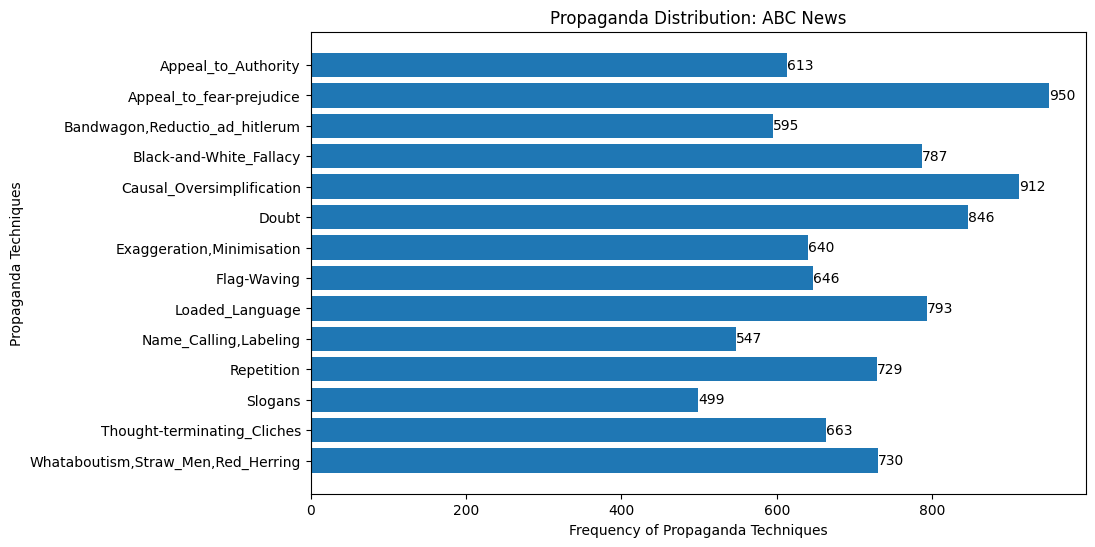

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/abc_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')
df = df[df['date'] != 2021]

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: ABC News')
plt.show()



The length of the dataframe is: 5469
The number of unique labels in the dataframe is:  Appeal_to_Authority                   581
Slogans                               443
Exaggeration,Minimisation             430
Thought-terminating_Cliches           427
Repetition                            411
Appeal_to_fear-prejudice              404
Whataboutism,Straw_Men,Red_Herring    383
Black-and-White_Fallacy               382
Loaded_Language                       378
Name_Calling,Labeling                 361
Doubt                                 354
Bandwagon,Reductio_ad_hitlerum        314
Causal_Oversimplification             305
Flag-Waving                           296
Name: label, dtype: int64
                                Labels  Frequency
0                  Appeal_to_Authority        581
1                              Slogans        443
2            Exaggeration,Minimisation        430
3          Thought-terminating_Cliches        427
4                           Repetition        411

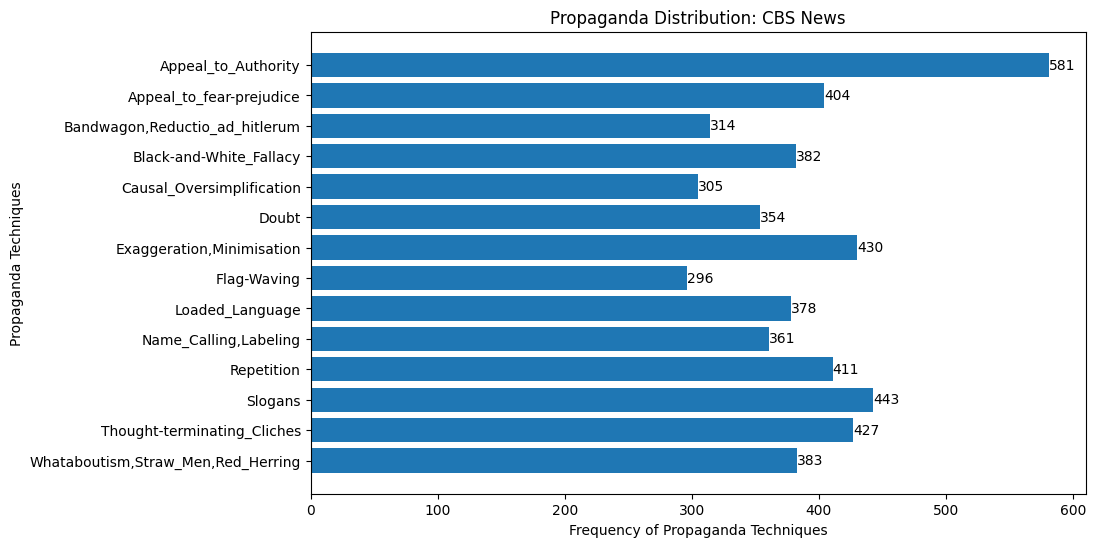

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cbs_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: CBS News')
plt.show()



The length of the dataframe is: 31041
The number of unique labels in the dataframe is:  Exaggeration,Minimisation             2787
Flag-Waving                           2744
Whataboutism,Straw_Men,Red_Herring    2644
Thought-terminating_Cliches           2376
Doubt                                 2321
Causal_Oversimplification             2316
Slogans                               2247
Name_Calling,Labeling                 2243
Appeal_to_Authority                   2163
Bandwagon,Reductio_ad_hitlerum        2103
Repetition                            2004
Loaded_Language                       1948
Appeal_to_fear-prejudice              1611
Black-and-White_Fallacy               1534
Name: label, dtype: int64
                                Labels  Frequency
0            Exaggeration,Minimisation       2787
1                          Flag-Waving       2744
2   Whataboutism,Straw_Men,Red_Herring       2644
3          Thought-terminating_Cliches       2376
4                                D

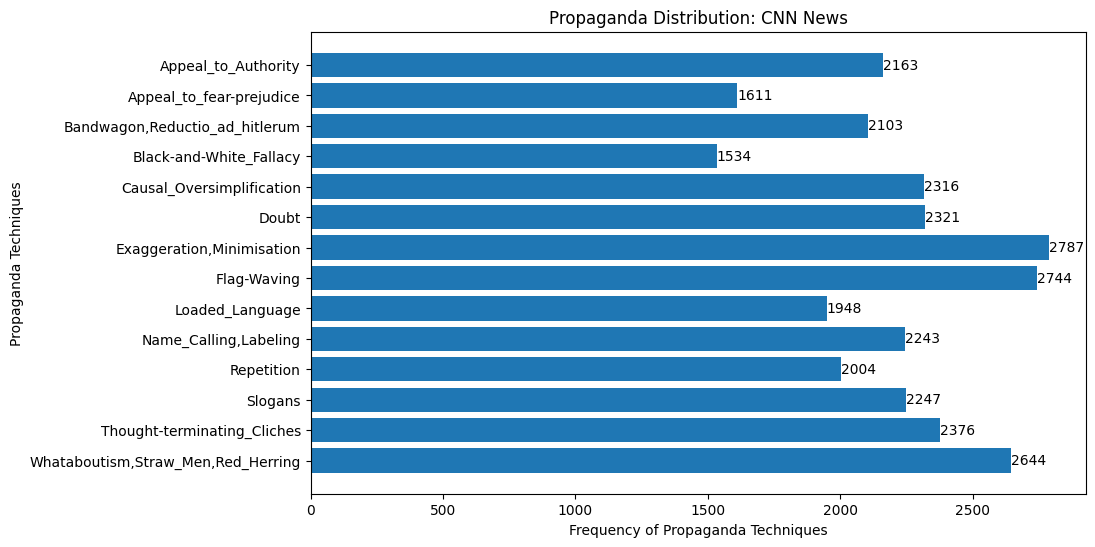

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cnn_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: CNN News')
plt.show()



The length of the dataframe is: 34111
The number of unique labels in the dataframe is:  Thought-terminating_Cliches           3362
Loaded_Language                       2894
Flag-Waving                           2671
Exaggeration,Minimisation             2660
Appeal_to_Authority                   2475
Whataboutism,Straw_Men,Red_Herring    2465
Causal_Oversimplification             2463
Repetition                            2402
Bandwagon,Reductio_ad_hitlerum        2390
Black-and-White_Fallacy               2386
Appeal_to_fear-prejudice              2205
Doubt                                 2191
Slogans                               2190
Name_Calling,Labeling                 1357
Name: label, dtype: int64
                                Labels  Frequency
0          Thought-terminating_Cliches       3362
1                      Loaded_Language       2894
2                          Flag-Waving       2671
3            Exaggeration,Minimisation       2660
4                  Appeal_to_Autho

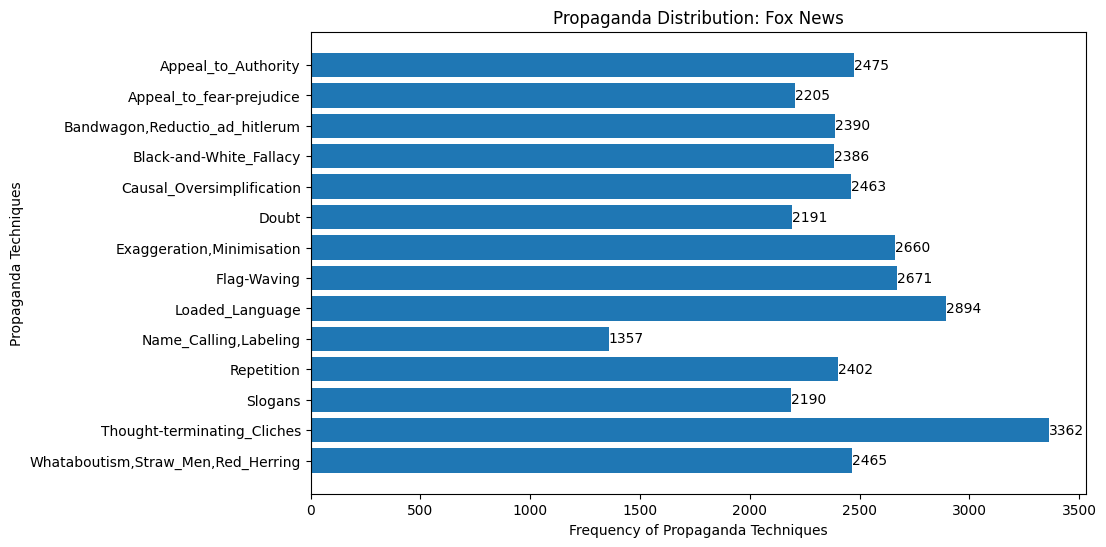

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/fox_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Fox News')
plt.show()



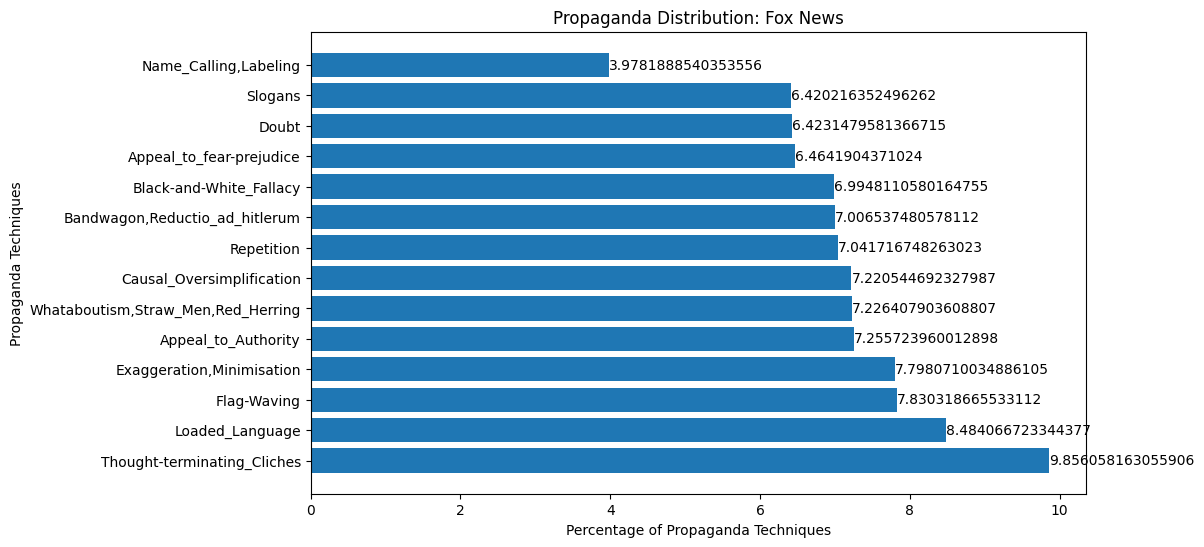

In [ ]:
# Plot the bar chart with percentages
df_value_counts['Percentage'] = df_value_counts['Frequency'].apply(lambda x: (x / length) * 100)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_value_counts['Labels'], df_value_counts['Percentage'])

# Add the percentages to the plot
ax.bar_label(bars, labels=df_value_counts['Percentage'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Percentage of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Fox News')
plt.show()


The length of the dataframe is: 10138
The number of unique labels in the dataframe is:  Slogans                               950
Causal_Oversimplification             842
Whataboutism,Straw_Men,Red_Herring    832
Name_Calling,Labeling                 798
Doubt                                 774
Bandwagon,Reductio_ad_hitlerum        767
Black-and-White_Fallacy               747
Appeal_to_fear-prejudice              716
Flag-Waving                           677
Loaded_Language                       655
Repetition                            652
Exaggeration,Minimisation             603
Thought-terminating_Cliches           601
Appeal_to_Authority                   524
Name: label, dtype: int64
                                Labels  Frequency
0                              Slogans        950
1            Causal_Oversimplification        842
2   Whataboutism,Straw_Men,Red_Herring        832
3                Name_Calling,Labeling        798
4                                Doubt        77

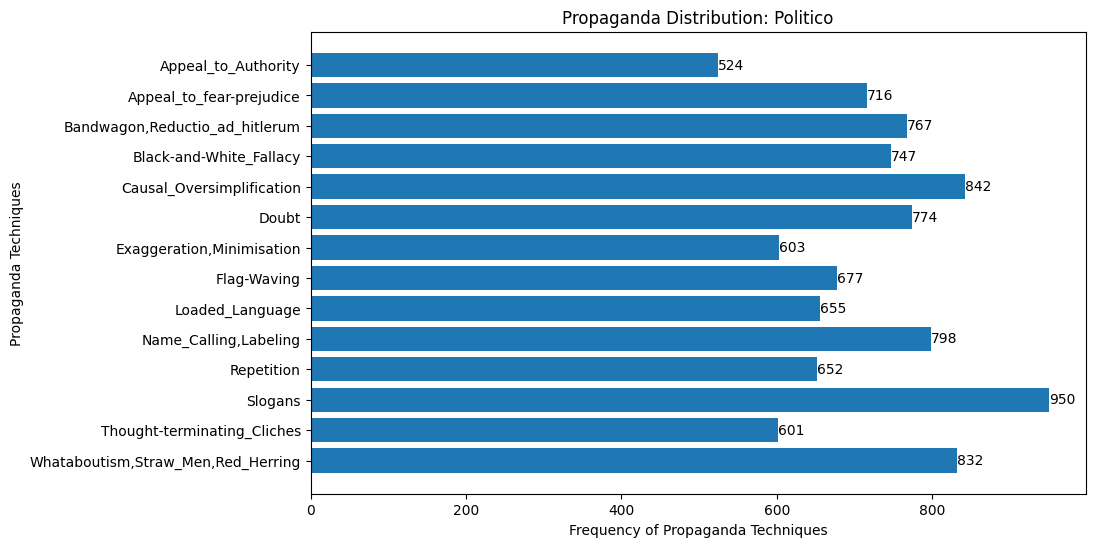

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/politico_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Politico')
plt.show()



The length of the dataframe is: 19569
The number of unique labels in the dataframe is:  Whataboutism,Straw_Men,Red_Herring    2001
Loaded_Language                       1860
Exaggeration,Minimisation             1756
Bandwagon,Reductio_ad_hitlerum        1704
Causal_Oversimplification             1546
Flag-Waving                           1504
Black-and-White_Fallacy               1405
Appeal_to_Authority                   1347
Slogans                               1325
Doubt                                 1236
Name_Calling,Labeling                 1169
Repetition                            1004
Appeal_to_fear-prejudice               944
Thought-terminating_Cliches            768
Name: label, dtype: int64
                                Labels  Frequency
0   Whataboutism,Straw_Men,Red_Herring       2001
1                      Loaded_Language       1860
2            Exaggeration,Minimisation       1756
3       Bandwagon,Reductio_ad_hitlerum       1704
4            Causal_Oversimplifica

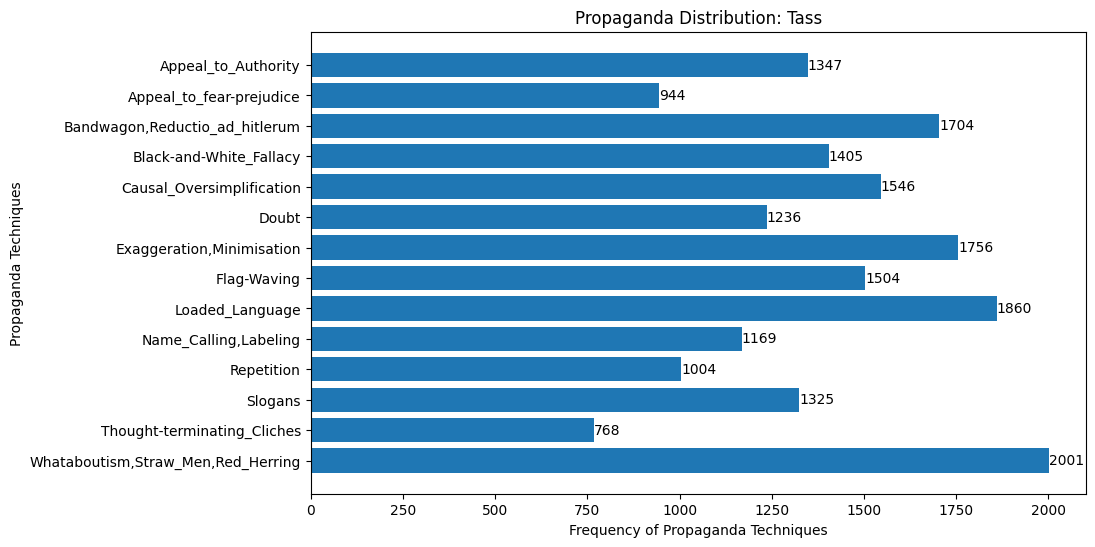

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/tass_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Tass')
plt.show()



The length of the dataframe is: 91005
The number of unique labels in the dataframe is:  Black-and-White_Fallacy               8420
Appeal_to_Authority                   7986
Appeal_to_fear-prejudice              7579
Exaggeration,Minimisation             7255
Doubt                                 6896
Flag-Waving                           6844
Bandwagon,Reductio_ad_hitlerum        6793
Loaded_Language                       6516
Name_Calling,Labeling                 6379
Causal_Oversimplification             5956
Whataboutism,Straw_Men,Red_Herring    5850
Thought-terminating_Cliches           5356
Slogans                               5352
Repetition                            3823
Name: label, dtype: int64
                                Labels  Frequency
0              Black-and-White_Fallacy       8420
1                  Appeal_to_Authority       7986
2             Appeal_to_fear-prejudice       7579
3            Exaggeration,Minimisation       7255
4                                D

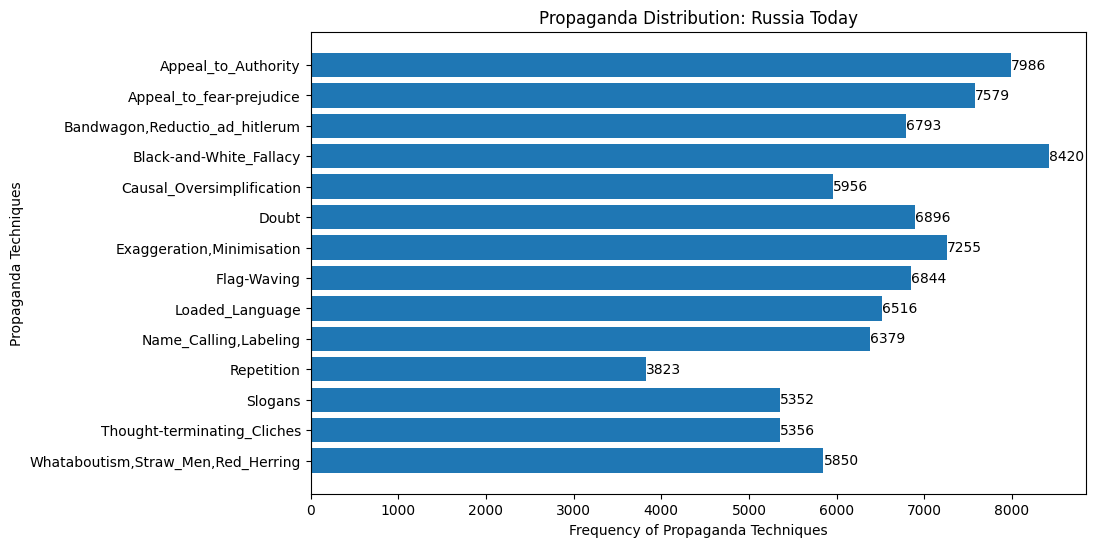

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/rt_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Russia Today')
plt.show()



The length of the dataframe is: 37717
The number of unique labels in the dataframe is:  Loaded_Language                       4158
Whataboutism,Straw_Men,Red_Herring    3666
Doubt                                 3338
Appeal_to_Authority                   3283
Name_Calling,Labeling                 2819
Flag-Waving                           2755
Causal_Oversimplification             2648
Slogans                               2499
Appeal_to_fear-prejudice              2436
Exaggeration,Minimisation             2208
Black-and-White_Fallacy               2163
Bandwagon,Reductio_ad_hitlerum        2134
Thought-terminating_Cliches           2047
Repetition                            1563
Name: label, dtype: int64
                                Labels  Frequency
0                      Loaded_Language       4158
1   Whataboutism,Straw_Men,Red_Herring       3666
2                                Doubt       3338
3                  Appeal_to_Authority       3283
4                Name_Calling,Labe

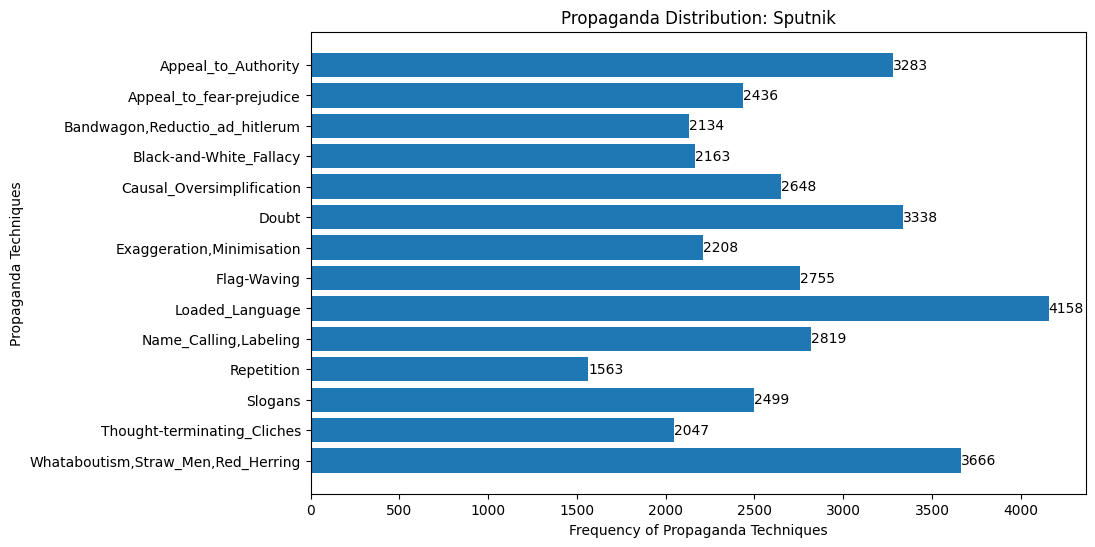

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/sputnik_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Sputnik')
plt.show()



The length of the dataframe is: 9950
The number of unique labels in the dataframe is:  Appeal_to_fear-prejudice              950
Causal_Oversimplification             912
Doubt                                 846
Loaded_Language                       793
Black-and-White_Fallacy               787
Whataboutism,Straw_Men,Red_Herring    730
Repetition                            729
Thought-terminating_Cliches           663
Flag-Waving                           646
Exaggeration,Minimisation             640
Appeal_to_Authority                   613
Bandwagon,Reductio_ad_hitlerum        595
Name_Calling,Labeling                 547
Slogans                               499
Name: label, dtype: int64
                                Labels  Frequency
0             Appeal_to_fear-prejudice        950
1            Causal_Oversimplification        912
2                                Doubt        846
3                      Loaded_Language        793
4              Black-and-White_Fallacy        787

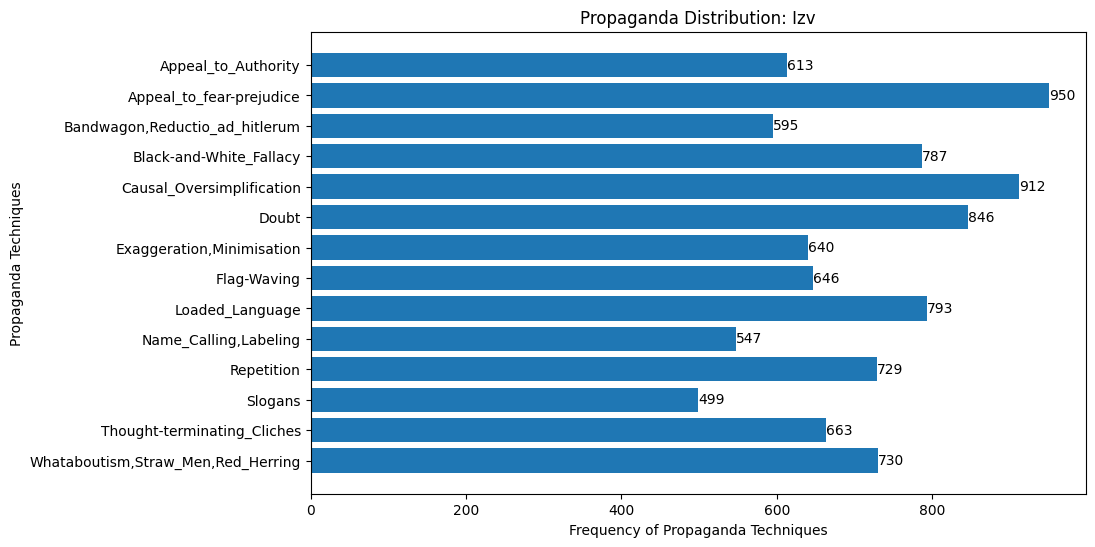

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/izv_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Izv')
plt.show()



The length of the dataframe is: 6145
The number of unique labels in the dataframe is:  Slogans                               523
Appeal_to_fear-prejudice              511
Repetition                            503
Thought-terminating_Cliches           502
Exaggeration,Minimisation             475
Loaded_Language                       449
Causal_Oversimplification             449
Appeal_to_Authority                   438
Bandwagon,Reductio_ad_hitlerum        434
Whataboutism,Straw_Men,Red_Herring    412
Black-and-White_Fallacy               396
Doubt                                 373
Flag-Waving                           340
Name_Calling,Labeling                 340
Name: label, dtype: int64
                                Labels  Frequency
0                              Slogans        523
1             Appeal_to_fear-prejudice        511
2                           Repetition        503
3          Thought-terminating_Cliches        502
4            Exaggeration,Minimisation        475

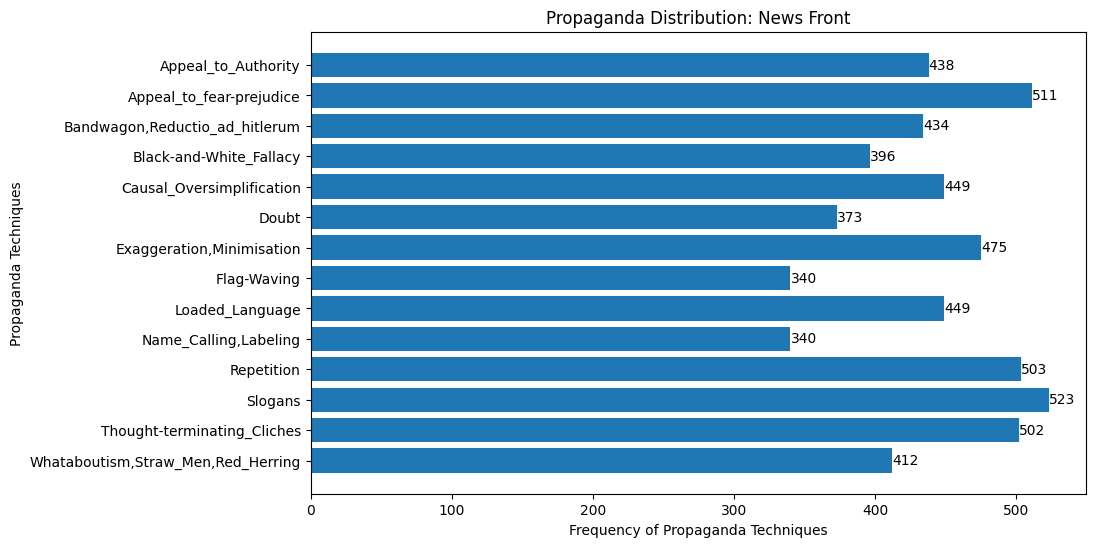

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/news_front_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: News Front')
plt.show()



In [ ]:
file_path1 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/sputnik_propaganda_techniques.tsv"
file_path2 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/rt_propaganda_techniques.tsv"
file_path3 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/izv_propaganda_techniques.tsv"
file_path4 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/news_front_propaganda_techniques.tsv"
file_path5 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/tass_propaganda_techniques.tsv"

df1 = pd.read_csv(file_path1, encoding="utf-8", delimiter='\t')
df2 = pd.read_csv(file_path2, encoding="utf-8", delimiter='\t')
df3 = pd.read_csv(file_path3, encoding="utf-8", delimiter='\t')
df4 = pd.read_csv(file_path4, encoding="utf-8", delimiter='\t')
df5 = pd.read_csv(file_path5, encoding="utf-8", delimiter='\t')

#df_sum = pd.concatenate(df1 df2+ df3 +df4 + df5
df_sum = pd.concat([df1, df2, df3, df4, df5], axis=0)

df_sum.head()

# Print the length of the dataframe
#print("The length of the dataframe is:", df_sum)

value_counts = df_sum["label"].value_counts()

df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
#print(df_value_counts)

# Calculate the sum of the 'Frequency' column
total = df_value_counts['Frequency'].sum()
df_value_counts['Percentage'] = df_value_counts['Frequency'] / total * 100

# Format the percentages to double with two decimal places and add % sign
df_value_counts['Percentage'] = df_value_counts['Percentage'].apply(lambda x: '{:.2f}%'.format(x))
df_value_counts = df_value_counts.sort_values('Labels', ascending=True)


print(df_value_counts)


                                Labels  Frequency Percentage
1                  Appeal_to_Authority      13667      8.31%
5             Appeal_to_fear-prejudice      12420      7.56%
8       Bandwagon,Reductio_ad_hitlerum      11660      7.09%
2              Black-and-White_Fallacy      13171      8.01%
9            Causal_Oversimplification      11511      7.00%
3                                Doubt      12689      7.72%
6            Exaggeration,Minimisation      12334      7.50%
7                          Flag-Waving      12089      7.35%
0                      Loaded_Language      13776      8.38%
10               Name_Calling,Labeling      11254      6.85%
13                          Repetition       7622      4.64%
11                             Slogans      10198      6.20%
12         Thought-terminating_Cliches       9336      5.68%
4   Whataboutism,Straw_Men,Red_Herring      12659      7.70%


In [ ]:
file_path1 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/fox_propaganda_techniques.tsv"
file_path2 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/abc_propaganda_techniques.tsv"
file_path3 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cbs_propaganda_techniques.tsv"
file_path4 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cnn_propaganda_techniques.tsv"
file_path5 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/politico_propaganda_techniques.tsv"

df1 = pd.read_csv(file_path1, encoding="utf-8", delimiter='\t')
df2 = pd.read_csv(file_path2, encoding="utf-8", delimiter='\t')
df3 = pd.read_csv(file_path3, encoding="utf-8", delimiter='\t')
df4 = pd.read_csv(file_path4, encoding="utf-8", delimiter='\t')
df5 = pd.read_csv(file_path5, encoding="utf-8", delimiter='\t')

#df_sum = pd.concatenate(df1 df2+ df3 +df4 + df5
df_sum = pd.concat([df1, df2, df3, df4, df5], axis=0)

df_sum.head()

# Print the length of the dataframe
#print("The length of the dataframe is:", df_sum)

value_counts = df_sum["label"].value_counts()

df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
#print(df_value_counts)

# Calculate the sum of the 'Frequency' column
total = df_value_counts['Frequency'].sum()
df_value_counts['Percentage'] = df_value_counts['Frequency'] / total * 100

# Format the percentages to double with two decimal places and add % sign
df_value_counts['Percentage'] = df_value_counts['Percentage'].apply(lambda x: '{:.2f}%'.format(x))
df_value_counts = df_value_counts.sort_values('Labels', ascending=True)


print(df_value_counts)


                                Labels  Frequency Percentage
9                  Appeal_to_Authority       7893      6.92%
4             Appeal_to_fear-prejudice       8271      7.25%
2       Bandwagon,Reductio_ad_hitlerum       8571      7.51%
12             Black-and-White_Fallacy       7170      6.28%
8            Causal_Oversimplification       7902      6.92%
10                               Doubt       7887      6.91%
1            Exaggeration,Minimisation       9062      7.94%
3                          Flag-Waving       8507      7.45%
7                      Loaded_Language       8117      7.11%
13               Name_Calling,Labeling       7039      6.17%
11                          Repetition       7496      6.57%
6                              Slogans       8145      7.14%
0          Thought-terminating_Cliches       9864      8.64%
5   Whataboutism,Straw_Men,Red_Herring       8197      7.18%


The length of the dataframe is: 9950
The number of unique labels in the dataframe is:  Appeal_to_fear-prejudice              950
Causal_Oversimplification             912
Doubt                                 846
Loaded_Language                       793
Black-and-White_Fallacy               787
Whataboutism,Straw_Men,Red_Herring    730
Repetition                            729
Thought-terminating_Cliches           663
Flag-Waving                           646
Exaggeration,Minimisation             640
Appeal_to_Authority                   613
Bandwagon,Reductio_ad_hitlerum        595
Name_Calling,Labeling                 547
Slogans                               499
Name: label, dtype: int64
                                Labels  Frequency
0             Appeal_to_fear-prejudice        950
1            Causal_Oversimplification        912
2                                Doubt        846
3                      Loaded_Language        793
4              Black-and-White_Fallacy        787

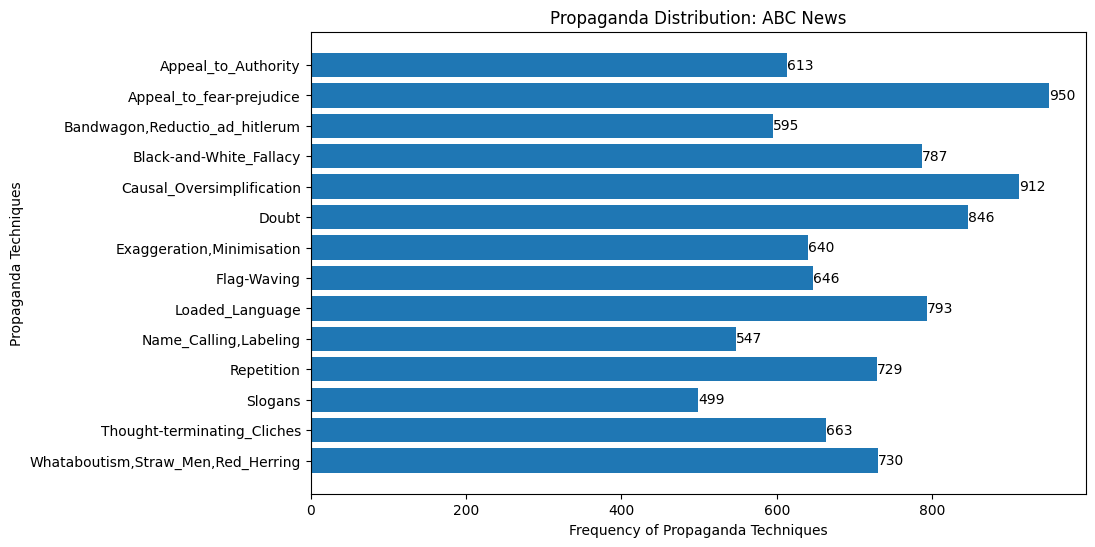

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/abc_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')
df = df[df['date'] != 2021]

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: ABC News')
plt.show()



The length of the dataframe is: 5469
The number of unique labels in the dataframe is:  Appeal_to_Authority                   581
Slogans                               443
Exaggeration,Minimisation             430
Thought-terminating_Cliches           427
Repetition                            411
Appeal_to_fear-prejudice              404
Whataboutism,Straw_Men,Red_Herring    383
Black-and-White_Fallacy               382
Loaded_Language                       378
Name_Calling,Labeling                 361
Doubt                                 354
Bandwagon,Reductio_ad_hitlerum        314
Causal_Oversimplification             305
Flag-Waving                           296
Name: label, dtype: int64
                                Labels  Frequency
0                  Appeal_to_Authority        581
1                              Slogans        443
2            Exaggeration,Minimisation        430
3          Thought-terminating_Cliches        427
4                           Repetition        411

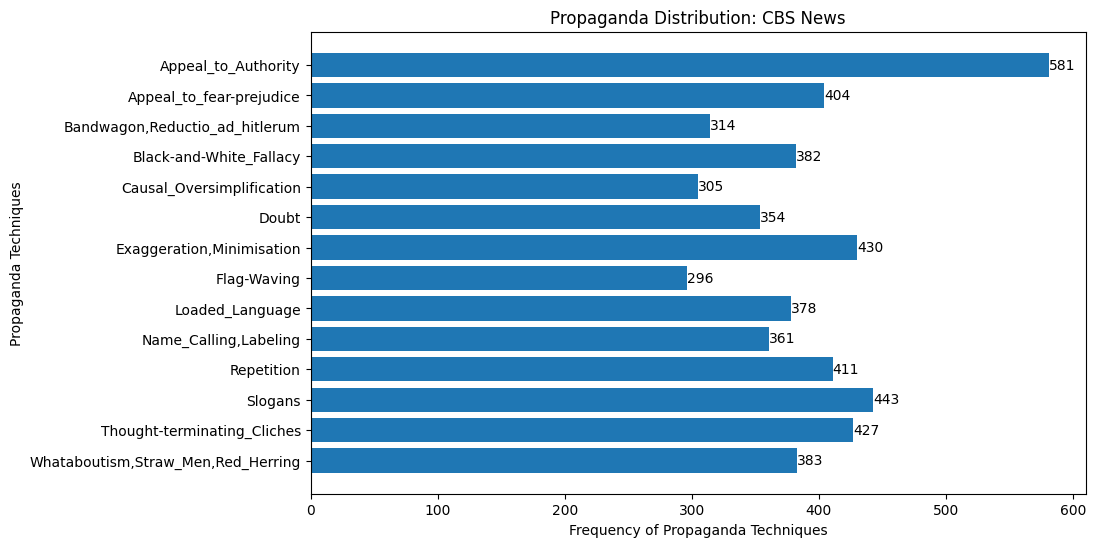

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cbs_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: CBS News')
plt.show()



The length of the dataframe is: 31041
The number of unique labels in the dataframe is:  Exaggeration,Minimisation             2787
Flag-Waving                           2744
Whataboutism,Straw_Men,Red_Herring    2644
Thought-terminating_Cliches           2376
Doubt                                 2321
Causal_Oversimplification             2316
Slogans                               2247
Name_Calling,Labeling                 2243
Appeal_to_Authority                   2163
Bandwagon,Reductio_ad_hitlerum        2103
Repetition                            2004
Loaded_Language                       1948
Appeal_to_fear-prejudice              1611
Black-and-White_Fallacy               1534
Name: label, dtype: int64
                                Labels  Frequency
0            Exaggeration,Minimisation       2787
1                          Flag-Waving       2744
2   Whataboutism,Straw_Men,Red_Herring       2644
3          Thought-terminating_Cliches       2376
4                                D

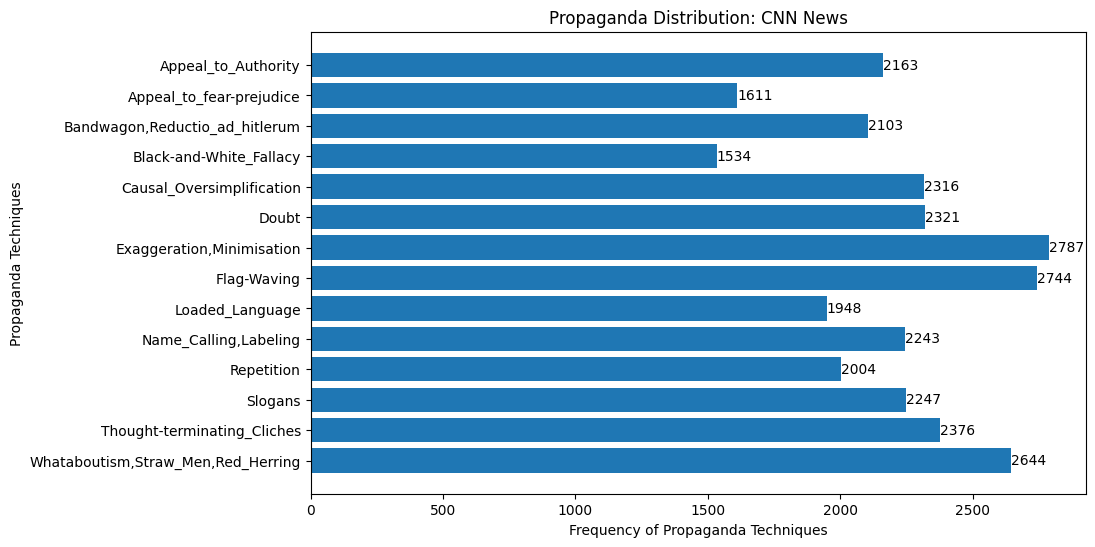

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cnn_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: CNN News')
plt.show()



The length of the dataframe is: 34111
The number of unique labels in the dataframe is:  Thought-terminating_Cliches           3362
Loaded_Language                       2894
Flag-Waving                           2671
Exaggeration,Minimisation             2660
Appeal_to_Authority                   2475
Whataboutism,Straw_Men,Red_Herring    2465
Causal_Oversimplification             2463
Repetition                            2402
Bandwagon,Reductio_ad_hitlerum        2390
Black-and-White_Fallacy               2386
Appeal_to_fear-prejudice              2205
Doubt                                 2191
Slogans                               2190
Name_Calling,Labeling                 1357
Name: label, dtype: int64
                                Labels  Frequency
0          Thought-terminating_Cliches       3362
1                      Loaded_Language       2894
2                          Flag-Waving       2671
3            Exaggeration,Minimisation       2660
4                  Appeal_to_Autho

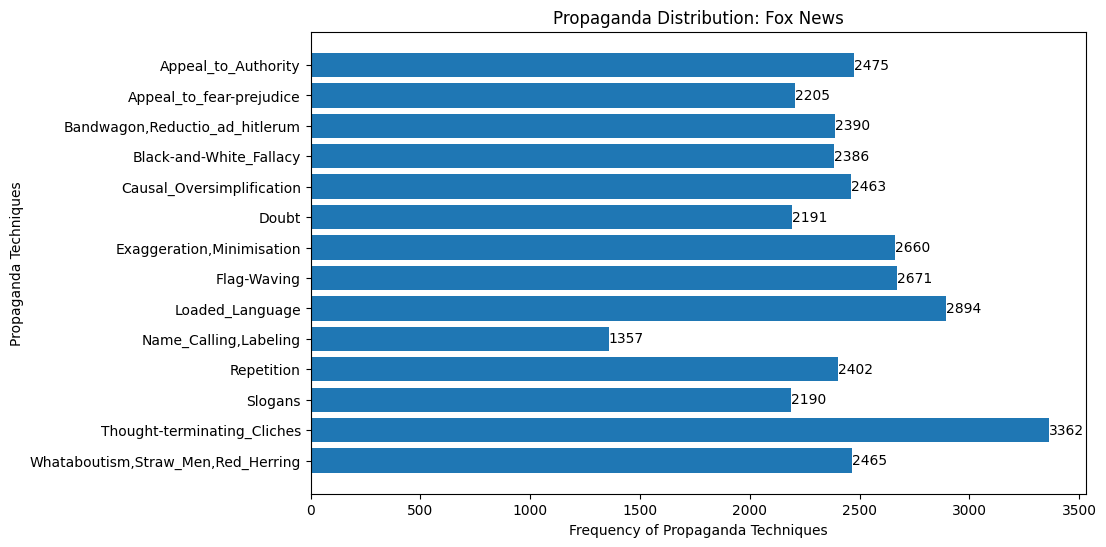

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/fox_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Fox News')
plt.show()



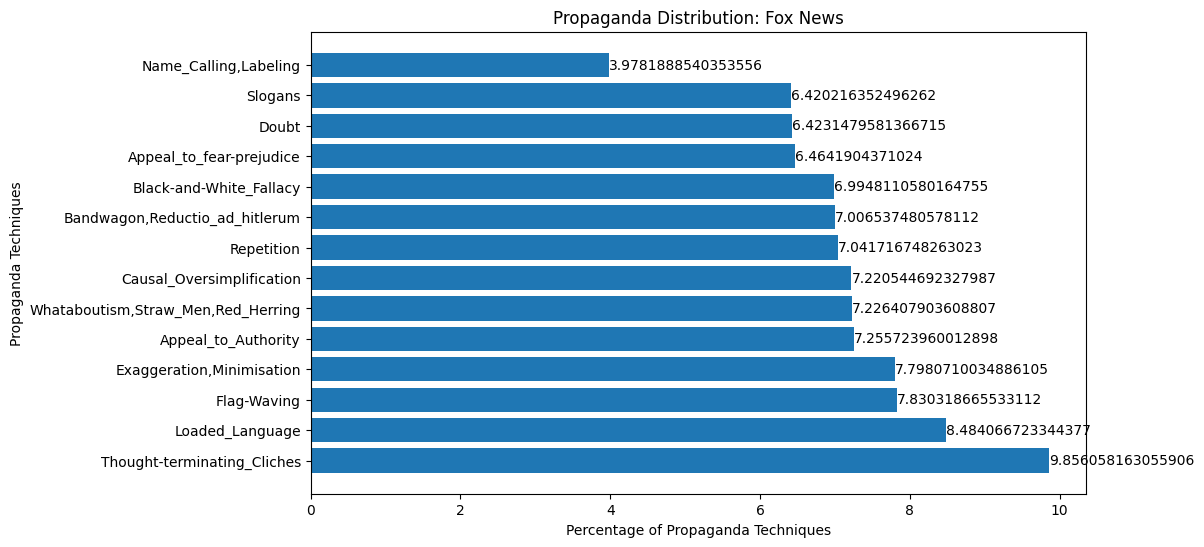

In [ ]:
# Plot the bar chart with percentages
df_value_counts['Percentage'] = df_value_counts['Frequency'].apply(lambda x: (x / length) * 100)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_value_counts['Labels'], df_value_counts['Percentage'])

# Add the percentages to the plot
ax.bar_label(bars, labels=df_value_counts['Percentage'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Percentage of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Fox News')
plt.show()


The length of the dataframe is: 10138
The number of unique labels in the dataframe is:  Slogans                               950
Causal_Oversimplification             842
Whataboutism,Straw_Men,Red_Herring    832
Name_Calling,Labeling                 798
Doubt                                 774
Bandwagon,Reductio_ad_hitlerum        767
Black-and-White_Fallacy               747
Appeal_to_fear-prejudice              716
Flag-Waving                           677
Loaded_Language                       655
Repetition                            652
Exaggeration,Minimisation             603
Thought-terminating_Cliches           601
Appeal_to_Authority                   524
Name: label, dtype: int64
                                Labels  Frequency
0                              Slogans        950
1            Causal_Oversimplification        842
2   Whataboutism,Straw_Men,Red_Herring        832
3                Name_Calling,Labeling        798
4                                Doubt        77

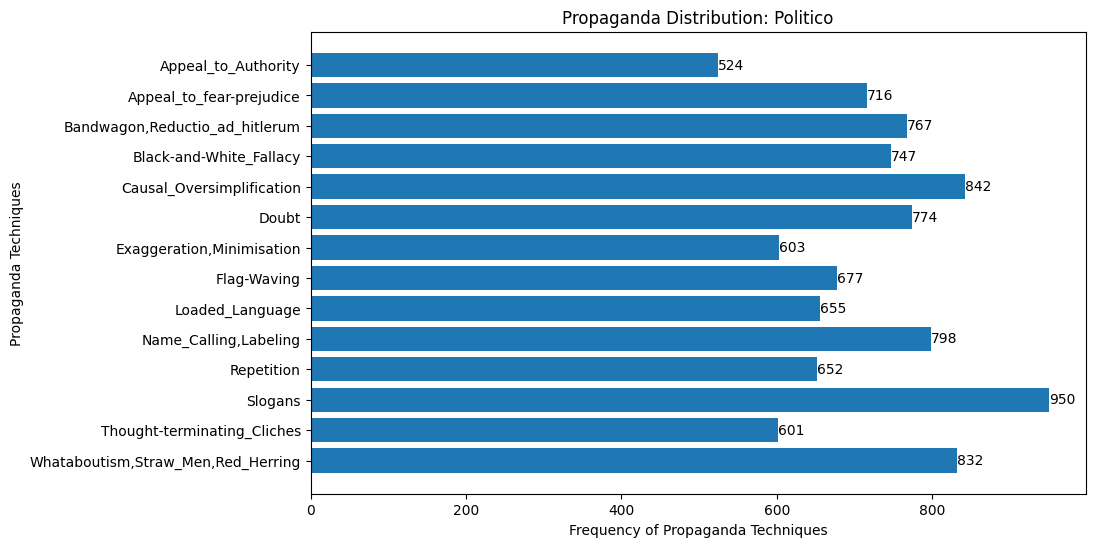

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/politico_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Politico')
plt.show()



The length of the dataframe is: 19569
The number of unique labels in the dataframe is:  Whataboutism,Straw_Men,Red_Herring    2001
Loaded_Language                       1860
Exaggeration,Minimisation             1756
Bandwagon,Reductio_ad_hitlerum        1704
Causal_Oversimplification             1546
Flag-Waving                           1504
Black-and-White_Fallacy               1405
Appeal_to_Authority                   1347
Slogans                               1325
Doubt                                 1236
Name_Calling,Labeling                 1169
Repetition                            1004
Appeal_to_fear-prejudice               944
Thought-terminating_Cliches            768
Name: label, dtype: int64
                                Labels  Frequency
0   Whataboutism,Straw_Men,Red_Herring       2001
1                      Loaded_Language       1860
2            Exaggeration,Minimisation       1756
3       Bandwagon,Reductio_ad_hitlerum       1704
4            Causal_Oversimplifica

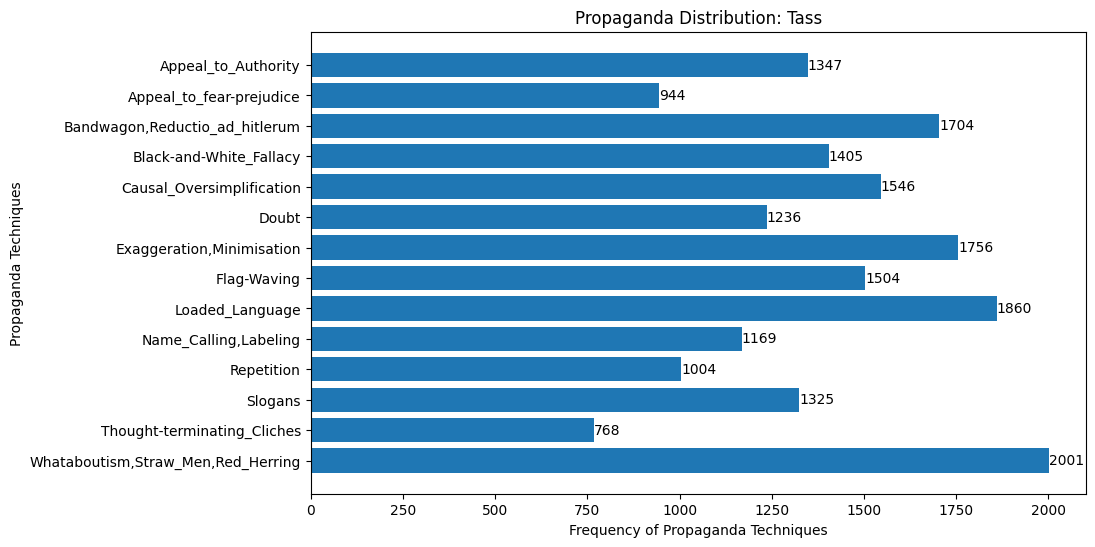

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/tass_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Tass')
plt.show()



The length of the dataframe is: 91005
The number of unique labels in the dataframe is:  Black-and-White_Fallacy               8420
Appeal_to_Authority                   7986
Appeal_to_fear-prejudice              7579
Exaggeration,Minimisation             7255
Doubt                                 6896
Flag-Waving                           6844
Bandwagon,Reductio_ad_hitlerum        6793
Loaded_Language                       6516
Name_Calling,Labeling                 6379
Causal_Oversimplification             5956
Whataboutism,Straw_Men,Red_Herring    5850
Thought-terminating_Cliches           5356
Slogans                               5352
Repetition                            3823
Name: label, dtype: int64
                                Labels  Frequency
0              Black-and-White_Fallacy       8420
1                  Appeal_to_Authority       7986
2             Appeal_to_fear-prejudice       7579
3            Exaggeration,Minimisation       7255
4                                D

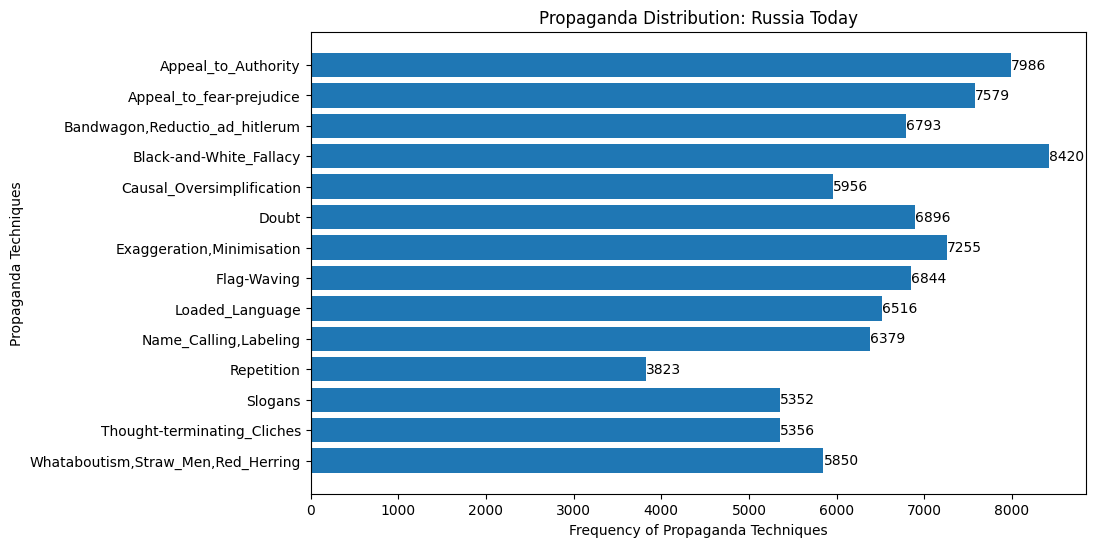

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/rt_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Russia Today')
plt.show()



The length of the dataframe is: 37717
The number of unique labels in the dataframe is:  Loaded_Language                       4158
Whataboutism,Straw_Men,Red_Herring    3666
Doubt                                 3338
Appeal_to_Authority                   3283
Name_Calling,Labeling                 2819
Flag-Waving                           2755
Causal_Oversimplification             2648
Slogans                               2499
Appeal_to_fear-prejudice              2436
Exaggeration,Minimisation             2208
Black-and-White_Fallacy               2163
Bandwagon,Reductio_ad_hitlerum        2134
Thought-terminating_Cliches           2047
Repetition                            1563
Name: label, dtype: int64
                                Labels  Frequency
0                      Loaded_Language       4158
1   Whataboutism,Straw_Men,Red_Herring       3666
2                                Doubt       3338
3                  Appeal_to_Authority       3283
4                Name_Calling,Labe

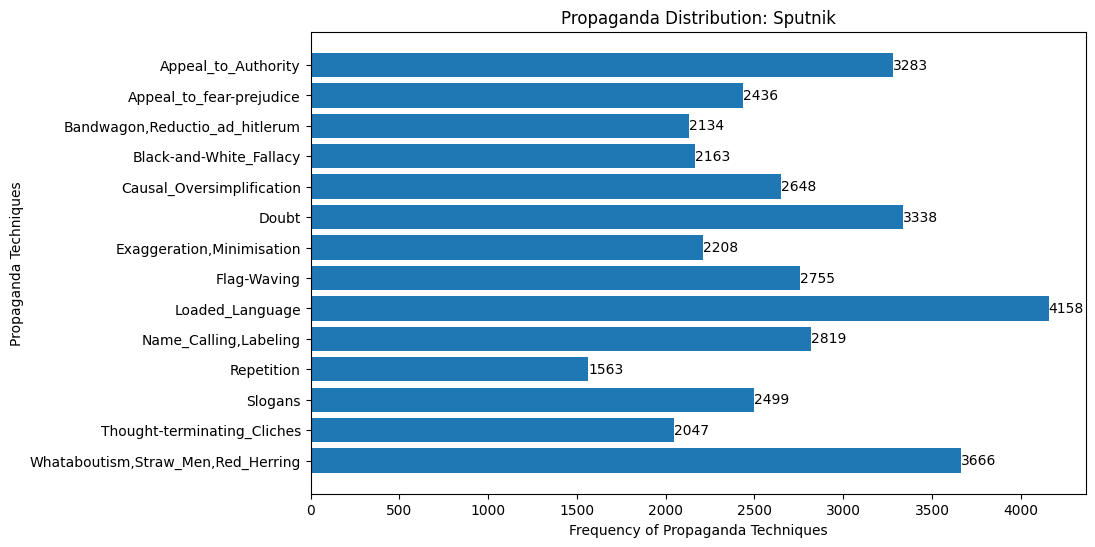

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/sputnik_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Sputnik')
plt.show()



The length of the dataframe is: 9950
The number of unique labels in the dataframe is:  Appeal_to_fear-prejudice              950
Causal_Oversimplification             912
Doubt                                 846
Loaded_Language                       793
Black-and-White_Fallacy               787
Whataboutism,Straw_Men,Red_Herring    730
Repetition                            729
Thought-terminating_Cliches           663
Flag-Waving                           646
Exaggeration,Minimisation             640
Appeal_to_Authority                   613
Bandwagon,Reductio_ad_hitlerum        595
Name_Calling,Labeling                 547
Slogans                               499
Name: label, dtype: int64
                                Labels  Frequency
0             Appeal_to_fear-prejudice        950
1            Causal_Oversimplification        912
2                                Doubt        846
3                      Loaded_Language        793
4              Black-and-White_Fallacy        787

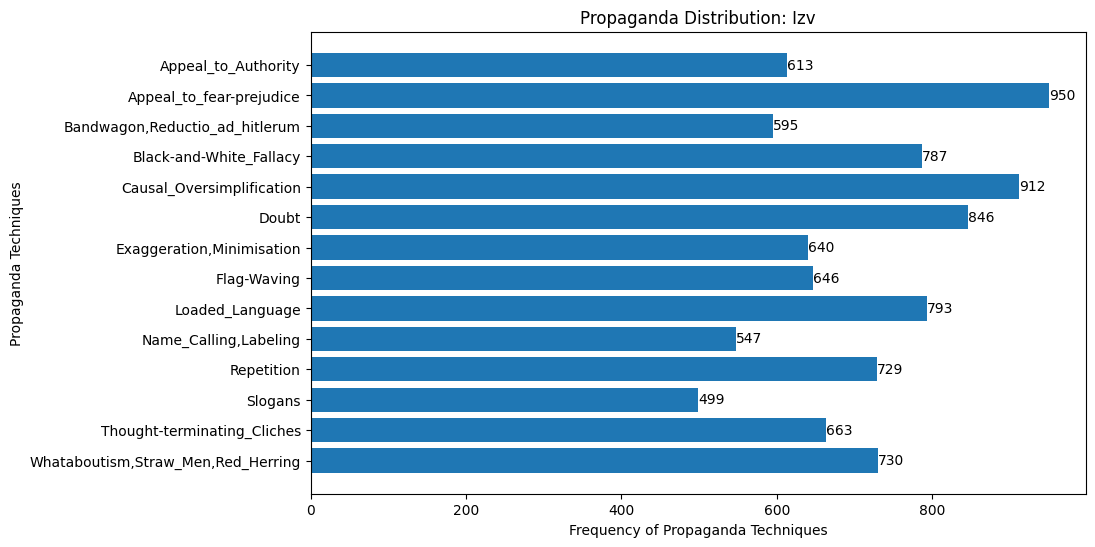

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/izv_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: Izv')
plt.show()



The length of the dataframe is: 6145
The number of unique labels in the dataframe is:  Slogans                               523
Appeal_to_fear-prejudice              511
Repetition                            503
Thought-terminating_Cliches           502
Exaggeration,Minimisation             475
Loaded_Language                       449
Causal_Oversimplification             449
Appeal_to_Authority                   438
Bandwagon,Reductio_ad_hitlerum        434
Whataboutism,Straw_Men,Red_Herring    412
Black-and-White_Fallacy               396
Doubt                                 373
Flag-Waving                           340
Name_Calling,Labeling                 340
Name: label, dtype: int64
                                Labels  Frequency
0                              Slogans        523
1             Appeal_to_fear-prejudice        511
2                           Repetition        503
3          Thought-terminating_Cliches        502
4            Exaggeration,Minimisation        475

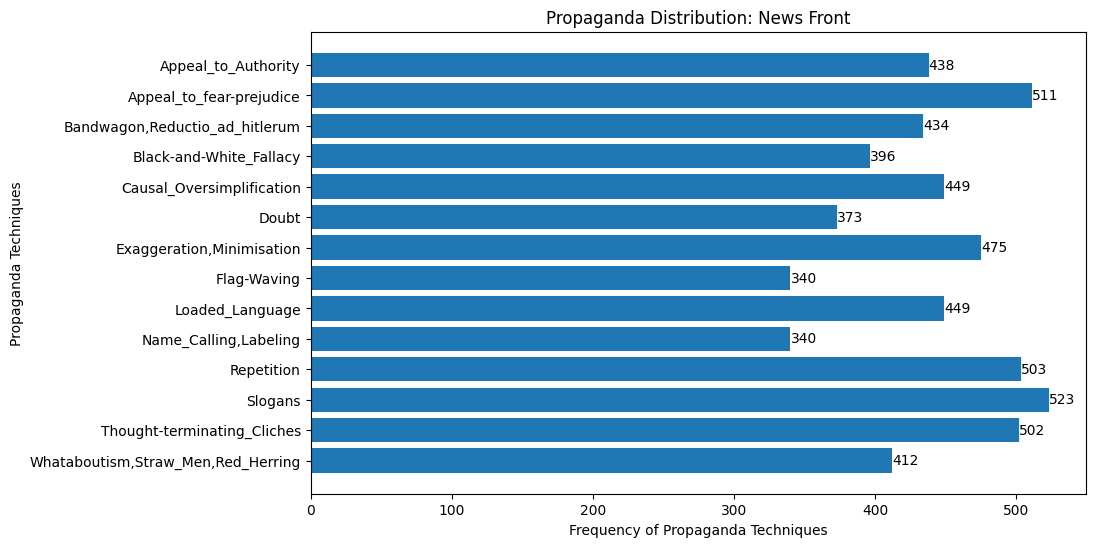

In [ ]:
file_path ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/news_front_propaganda_techniques.tsv"

df = pd.read_csv(file_path, encoding="utf-8", delimiter='\t')

length = len(df)

# Print the length of the dataframe
print("The length of the dataframe is:", length)

value_counts = df["label"].value_counts()

# Print the unique count of values in the "label" column
print("The number of unique labels in the dataframe is: ", value_counts)


df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
print(df_value_counts)


import pandas as pd
import matplotlib.pyplot as plt

# Assuming that the DataFrame has the column names 'Labels' and 'Frequency'
df = df_value_counts.sort_values('Labels', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
bars = ax.barh(df['Labels'], df['Frequency'])

# Add the counts to the plot
ax.bar_label(bars, labels=df['Frequency'], label_type='edge')

plt.xticks(rotation=0)
plt.xlabel('Frequency of Propaganda Techniques')
plt.ylabel('Propaganda Techniques')
plt.title('Propaganda Distribution: News Front')
plt.show()



In [ ]:
file_path1 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/sputnik_propaganda_techniques.tsv"
file_path2 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/rt_propaganda_techniques.tsv"
file_path3 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/izv_propaganda_techniques.tsv"
file_path4 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/news_front_propaganda_techniques.tsv"
file_path5 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/tass_propaganda_techniques.tsv"

df1 = pd.read_csv(file_path1, encoding="utf-8", delimiter='\t')
df2 = pd.read_csv(file_path2, encoding="utf-8", delimiter='\t')
df3 = pd.read_csv(file_path3, encoding="utf-8", delimiter='\t')
df4 = pd.read_csv(file_path4, encoding="utf-8", delimiter='\t')
df5 = pd.read_csv(file_path5, encoding="utf-8", delimiter='\t')

#df_sum = pd.concatenate(df1 df2+ df3 +df4 + df5
df_sum = pd.concat([df1, df2, df3, df4, df5], axis=0)

df_sum.head()

# Print the length of the dataframe
#print("The length of the dataframe is:", df_sum)

value_counts = df_sum["label"].value_counts()

df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
#print(df_value_counts)

# Calculate the sum of the 'Frequency' column
total = df_value_counts['Frequency'].sum()
df_value_counts['Percentage'] = df_value_counts['Frequency'] / total * 100

# Format the percentages to double with two decimal places and add % sign
df_value_counts['Percentage'] = df_value_counts['Percentage'].apply(lambda x: '{:.2f}%'.format(x))
df_value_counts = df_value_counts.sort_values('Labels', ascending=True)


print(df_value_counts)


                                Labels  Frequency Percentage
1                  Appeal_to_Authority      13667      8.31%
5             Appeal_to_fear-prejudice      12420      7.56%
8       Bandwagon,Reductio_ad_hitlerum      11660      7.09%
2              Black-and-White_Fallacy      13171      8.01%
9            Causal_Oversimplification      11511      7.00%
3                                Doubt      12689      7.72%
6            Exaggeration,Minimisation      12334      7.50%
7                          Flag-Waving      12089      7.35%
0                      Loaded_Language      13776      8.38%
10               Name_Calling,Labeling      11254      6.85%
13                          Repetition       7622      4.64%
11                             Slogans      10198      6.20%
12         Thought-terminating_Cliches       9336      5.68%
4   Whataboutism,Straw_Men,Red_Herring      12659      7.70%


In [ ]:
file_path1 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/fox_propaganda_techniques.tsv"
file_path2 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/abc_propaganda_techniques.tsv"
file_path3 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cbs_propaganda_techniques.tsv"
file_path4 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/cnn_propaganda_techniques.tsv"
file_path5 ="/content/drive/MyDrive/prop_det/datasets/propaganda_datasets/politico_propaganda_techniques.tsv"

df1 = pd.read_csv(file_path1, encoding="utf-8", delimiter='\t')
df2 = pd.read_csv(file_path2, encoding="utf-8", delimiter='\t')
df3 = pd.read_csv(file_path3, encoding="utf-8", delimiter='\t')
df4 = pd.read_csv(file_path4, encoding="utf-8", delimiter='\t')
df5 = pd.read_csv(file_path5, encoding="utf-8", delimiter='\t')

#df_sum = pd.concatenate(df1 df2+ df3 +df4 + df5
df_sum = pd.concat([df1, df2, df3, df4, df5], axis=0)

df_sum.head()

# Print the length of the dataframe
#print("The length of the dataframe is:", df_sum)

value_counts = df_sum["label"].value_counts()

df_value_counts = value_counts.to_frame().reset_index()
df_value_counts.columns = ['Labels', 'Frequency']
#print(df_value_counts)

# Calculate the sum of the 'Frequency' column
total = df_value_counts['Frequency'].sum()
df_value_counts['Percentage'] = df_value_counts['Frequency'] / total * 100

# Format the percentages to double with two decimal places and add % sign
df_value_counts['Percentage'] = df_value_counts['Percentage'].apply(lambda x: '{:.2f}%'.format(x))
df_value_counts = df_value_counts.sort_values('Labels', ascending=True)


print(df_value_counts)


                                Labels  Frequency Percentage
9                  Appeal_to_Authority       7893      6.92%
4             Appeal_to_fear-prejudice       8271      7.25%
2       Bandwagon,Reductio_ad_hitlerum       8571      7.51%
12             Black-and-White_Fallacy       7170      6.28%
8            Causal_Oversimplification       7902      6.92%
10                               Doubt       7887      6.91%
1            Exaggeration,Minimisation       9062      7.94%
3                          Flag-Waving       8507      7.45%
7                      Loaded_Language       8117      7.11%
13               Name_Calling,Labeling       7039      6.17%
11                          Repetition       7496      6.57%
6                              Slogans       8145      7.14%
0          Thought-terminating_Cliches       9864      8.64%
5   Whataboutism,Straw_Men,Red_Herring       8197      7.18%


# BONUS: Russian opinion articles scraped & translated

## Scraping the articles

In [ ]:
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2022, 1, 1)
end_date = date(2023, 4, 26)
data = []
for single_date in daterange(start_date, end_date):
    print(single_date)
    for i in range(30):
        date_str = single_date.strftime("%Y-%m-%d")
        url = "https://russian.rt.com/search?q=%D0%A3%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D0%B0&type=Post&df=" + date_str + "&dt=" + date_str + "&page=" + str(i)

        payload = {}
        headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Sec-Fetch-Site': 'same-origin',
        'Cookie': '...',
        'Sec-Fetch-Dest': 'document',
        'Accept-Language': 'de-DE,de;q=0.9',
        'Sec-Fetch-Mode': 'navigate',
        'Host': 'russian.rt.com',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.4 Safari/605.1.15',
        'Referer': 'https://russian.rt.com/search?q=%D0%A3%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D0%B0&type=News&df=' + date_str + '&dt=' + date_str,
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive'
        }

        try:
            response = requests.request("GET", url, headers=headers, data=payload)
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            continue

        #print(response.text)

        soup = BeautifulSoup(response.text, 'html.parser')
        a_tags = soup.find_all('a', {'class': 'link link_color'})

        for a_tag in a_tags:
            link = "https://russian.rt.com" + a_tag['href']
            title = a_tag.text.strip().replace('\n', '')
            data.append([link, title])

df = pd.DataFrame(data, columns=["Link", "Title"])
df.to_csv('output_rt_en.tsv', sep='\t', index=False, encoding='utf-8')


In [ ]:
import csv
from datetime import datetime
import scrapy
from pymongo.errors import DuplicateKeyError
from scrapy import Request
import pandas as pd

from mongo_connection.MongoConnector import access_mongo_return_entries, access_mongo_return_collection


class RtArticleSpider(scrapy.Spider):
    name = 'RtArticleSpider'
    allowed_domains = ['russian.rt.com']
    client_name = "russian_news_articles"
    collection_name_link_store = "rt_com_links"
    collection_name_article_store = "rt_com_articles"
    df = pd.DataFrame()

    def start_requests(self):
        # specify the file name
        file_name = '/Users/vhein/repo/article_scraper/rt_russian_opinion.tsv'

        # read the tsv into a pandas DataFrame
        df_input = pd.read_csv(file_name, delimiter='\t', encoding='utf-8')

        # print the 'Link' and 'Title' columns
        #print(df[['Link', 'Title']])

        for url in df_input['Link']:
            yield Request(url, callback=self.parse)

    def parse(self, response, **kwargs):
        article_title = response.xpath("//*[@class='article__heading ']/text()").get()
        article_date = response.xpath("//time[@class='date']/@datetime").get()
        #article_body_list = response.xpath("//*[@class='article__text text ']//p/text()").getall()
        article_body_list = response.xpath("//*[@class='article__text  js-mediator-article']//p//text()").getall()

        article_body = " ".join(article_body_list)

        article = {
            "title": article_title.replace("\n", "").replace("\t", "").strip(),
            "article_date": article_date.replace("\n", "").replace("\t", "").strip(),
            "article_body": article_body.replace("\n", "").replace("\t", "").strip(),

        }

        # specify the file name
        file_name = '/Users/vhein/repo/article_scraper/articles_russia_rt_2.tsv'
        article_df = pd.DataFrame([article])
        # append the article to the DataFrame
        self.df = pd.concat([self.df, article_df], ignore_index=True)

        # write the DataFrame to a tsv file
        self.df.to_csv(file_name, sep='\t', index=False, encoding='utf-8')


## Preprocessing articles to fit Span Ident Model

In [ ]:
import re
import pandas as pd
import os
import spacy
import emoji
import sys

from transformers import RobertaTokenizer, RobertaConfig

model_name_or_path = "model_checkpoints/si_roberta_crf"
tokenizer_config_path = 'model_checkpoints/si_roberta_crf/tokenizer_config.json'
tokenizer_config = RobertaConfig.from_json_file(tokenizer_config_path)
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, config=tokenizer_config, do_lower_case=True)


def add_whitespace_after_period(text):
    return re.sub(r'\.(?!\s)', '. ', text)


def remove_urls(text):
    url_pattern = re.compile(
        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    )
    return url_pattern.sub('', text)


def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)


def replace_whitespace(text):
    pattern = r'(\d+\.\s\d+)(?:\.\s(\d+))?'

    def repl(match):
        result = match.group(1).replace(" ", "")
        if match.group(2):
            result += "." + match.group(2)
        return result

    replaced_text = re.sub(pattern, repl, text)
    return replaced_text


def replace_period_quote(text):
    # The regex pattern to find instances of '. "'
    pattern = r'\. \"'
    # Replace the matched pattern with '."'
    new_text = re.sub(pattern, '."', text)
    return new_text


# Test the function


def replace_quotes(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("‘", "\'")  # Replace left single quotation marks
    text = text.replace("’", "\'")  # Replace right single quotation marks
    text = text.replace("“", "\"")  # Replace left double quotation marks
    text = text.replace("”", "\"")  # Replace right double quotation marks
    text = text.replace(" ", "")
    text = text.replace("​", "")
    text = text.replace("  ", " ")
    text = text.replace("  ", " ")
    text = text.replace(" . ", ". ")
    text = text.replace(" , ", ", ")
    text = text.replace("...", " ")
    text = text.replace("; -", ".")
    text = text.replace(" .", ".")
    text = text.replace(" : ", ": ")
    text = text.replace(": ", ". ")
    text = text.replace(". -", ". ")
    text = text.replace("– ", " ")
    # text = text.replace(" - ", " ")

    # text = text.replace(". ", ".")
    # text = text.replace('. "', '."')
    return text


# from transformers import DataProcessor, InputExample

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids


def read_examples_from_file(file_path, mode):
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f:
        words = []
        labels = []
        for line in f:
            print(line)
            # ipdb.set_trace()

            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                # ipdb.set_trace(context=6)
                if words:
                    # ipdb.set_trace(context=6)
                    examples.append(InputExample(guid="{}-{}".format(mode, guid_index),
                                                 words=words,
                                                 labels=labels))
                    guid_index += 1
                    words = []
                    labels = []
            else:
                splits = line.split('\t')  # " "
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(InputExample(guid="%s-%d".format(mode, guid_index),
                                         words=words,
                                         labels=labels))
    return examples


def main():
    # Load the English language model
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load("ru_core_news_sm")

    prefix = "news_front"
    input_file = "news_front_articles.tsv"
    create_sentences(input_file, nlp, prefix)

    # Replace 'input_file.tsv' with the name of your TSV file
    sys.exit(1)
    prefix = "tass_2"
    input_file = "tass_articles_cleaned_2.tsv"
    create_sentences(input_file, nlp, prefix)
    input_file = "abc_articles.tsv"
    #prefix = "abc"
    #create_sentences(input_file, nlp, prefix)
    input_file = "cbs_articles_cleaned.tsv"
    prefix = "cbs"
    create_sentences(input_file, nlp, prefix)
    prefix = "cnn"
    input_file = "cnn_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "politico"
    input_file = "politico_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "fox"
    input_file = "fox_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "sputnik"
    input_file = "sputnik_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "rt"
    input_file = "rt_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)
    prefix = "tass"
    input_file = "tass_articles_cleaned.tsv"
    create_sentences(input_file, nlp, prefix)





def create_sentences(input_file, nlp, prefix):
    df = pd.read_csv(input_file, sep="\t")
    df.fillna('', inplace=True)
    if 'subtitle' in df.columns:
        combined_column = df['title'] + ". " + df['subtitle'] + " " + df['article_body']
    else:
        combined_column = df['title'] + ". " + df['article_body']

    file_names = prefix + "_" + df['_id'].astype(str)
    #file_names = prefix + "_" + df['article_date'].astype(str)

    # Create a directory to store the output text files
    output_directory = prefix + "_txt_files"
    os.makedirs(output_directory, exist_ok=True)

    max_tokens = 150
    #text2 = "Among them are ASOS, Apple Store, Burberry, Dell, Diageo (Smirnoff, Guinness, etc. ), iHerb, IKEA, Farfetch, HP, H&M (COS, Monk, etc. ), LEGO, Mango, Mytheresa, Nike, Pernod Ricard (Chivas Regal, Jameson and others), Plzensky Prazdroj, Staropramen, Budejovicky Budvar, BBCOne, Cannes Festival, MEGOGO, Netflix, Paramount, Sony, Spotify, Warner Bros, Walt Disney Company, Ableton, Cinema 4D, Jooble, Nintendo eShop, Paysera, PlayStation Store, Steam, Twitter, Airbus, BMW, Boeing, Ford, General Motors (Chevrolet, Nexia, Cadillac, Escalade), Harley Davidson, Honda, Hyundai, Jaguar Land Rover, Mazda, Mercedes-Benz, Porsche, Renault, Scania, Toyota (including Lexus), Volkswagen (Audi, Bentley, Ducati, Lamborghini, Skoda, Volkswagen), Volvo Cars, American Express, Apple Pay, Google Pay, MasterCard, PayPal, Samsung pay, SWIFT, Visa, Western Union and others."
    text2 = "Recall that at present the use of the rt V vaccine, regardless of WHO, which postponed the approval process for the Russian vaccine, has been approved in Belarus, Argentina, Bolivia, Serbia, Algeria, Palestine, Venezuela, Paraguay, Turkmenistan, Hungary, the United Arab Emirates, Iran, the Republic of Guinea, Tunisia, Armenia, Mexico, Nicaragua, Republika Srpska (Bosnia and Herzegovina), Lebanon, Myanmar, Pakistan, Mongolia, Bahrain, Montenegro, Saint Vincent and the Grenadines, Kazakhstan, Uzbekistan, Gabon, San Marino, Ghana, Syria, Kyrgyzstan, Guyana, Egypt, Honduras, Guatemala, Moldova, Slovakia, Angola, Djibouti, Republic of Congo, Sri Lanka, Laos, Iraq, North Macedonia, Kenya, Morocco, Jordan, Namibia, Azerbaijan, Philippines, Cameroon, Seychelles, Mauritius, Vietnam, Antigua and Barbuda, Mali and Panama."
    for text, file_name in zip(combined_column, file_names):
        text = replace_quotes(text)
        text = add_whitespace_after_period(text)
        text = replace_whitespace(text)
        text = remove_emojis(text)
        text = replace_period_quote(text)

        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]
        output_file = os.path.join(output_directory, f"{file_name}.txt")

        with open(output_file, "w") as f:
            for sentence in sentences:
                items = re.findall(r'\w+|[^\s\w]|\"|\'', sentence)
                # print(items)
                tokenized_sentence = tokenizer.tokenize(' '.join(items))

                if len(tokenized_sentence) <= max_tokens:
                    f.write(sentence + "\n")
                else:
                    print("Length: " + str(len(tokenized_sentence)))
                    print(f"Skipping sentence: {sentence}")


def translated():
    # Specify the directory you want to start from
    rootDir = 'ru_txt_files_translated'
    saveDir = 'ru_txt_files_2'
    max_tokens = 150

    for dirName, subdirList, fileList in os.walk(rootDir):
        print('Found directory: %s' % dirName)
        for fname in fileList:
            if fname.endswith('.txt'):  # check if the file is a .txt file
                print('\t%s' % fname)
                with open(os.path.join(dirName, fname), 'r', encoding='utf-8') as myfile:
                    lines = myfile.readlines()
                    # Make sure the directory exists, if not, create it.
                    os.makedirs(os.path.join(saveDir, os.path.relpath(dirName, rootDir)), exist_ok=True)
                    with open(os.path.join(saveDir, os.path.relpath(dirName, rootDir), fname), 'w',
                              encoding='utf-8') as newfile:
                        for line in lines:
                            items = re.findall(r'\w+|[^\s\w]|\"|\'', line)
                            # print(items)
                            tokenized_sentence = tokenizer.tokenize(' '.join(items))

                            if len(tokenized_sentence) <= max_tokens:
                                newfile.write(line + "\n")
                            else:
                                print("Length: " + str(len(tokenized_sentence)))
                                print(f"Skipping sentence: {line}")

main()


## Translating Russian to English with Helsinki-NLP Model

In [ ]:
!pip install spacy

!python -m spacy download en_core_web_trf
!pip uninstall transformers
!pip install sentencepiece
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Create a function to translate a sentence
def translate_sentence(sentence, model, tokenizer):
    # Generate translation using model
    translated = model.generate(**tokenizer(sentence, return_tensors="pt", padding="longest").to(device))
    # Convert the generated tokens indices back into text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

# Specify model and tokenizer

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

# Check for GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Specify the directory you want to start from
rootDir = '/content/drive/MyDrive/prop_det/datasets/ru_txt_files'
saveDir = '/content/drive/MyDrive/prop_det/datasets/ru_txt_files_translated'

for dirName, subdirList, fileList in os.walk(rootDir):
    print('Found directory: %s' % dirName)
    for fname in fileList:
        if fname.endswith('.txt'): # check if the file is a .txt file
            print('\t%s' % fname)
            with open(os.path.join(dirName, fname), 'r', encoding='utf-8') as myfile:
                lines = myfile.readlines()
                # Make sure the directory exists, if not, create it.
                os.makedirs(os.path.join(saveDir, os.path.relpath(dirName, rootDir)), exist_ok=True)
                with open(os.path.join(saveDir, os.path.relpath(dirName, rootDir), fname), 'w', encoding='utf-8') as newfile:
                    for line in lines:
                        translated_line = translate_sentence(line, model, tokenizer)
                        #print(translated_line)
                        newfile.write(translated_line + '\n')


## OpenAI Translator

In [ ]:
import openai
import pandas as pd
import tiktoken

openai.api_key = "xxxxxxxxxxxxx"

def translate_text(text, source_language, target_language):

    prompt = f"Translate the following '{source_language}' text to '{target_language}': {text}"

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that translates text. You must keep the meaning of the text as it is. Don't fantasize, just translate the given input."},
            {"role": "user", "content": prompt}
        ],
        #max_tokens=150,
        n=1,
        stop=None,
        temperature=1.0,
    )

    translation = response.choices[0].message.content.strip()
    return translation


def test(text):
  source_language = "Russian"
  target_language = "English"

  translated_text = translate_text(text, source_language, target_language)
  return translated_text


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def main():
    file_name = 'to_translate2.tsv'
    df = pd.DataFrame()
    # read the tsv into a pandas DataFrame
    df_input = pd.read_csv(file_name, delimiter='\t', encoding='utf-8')

    # print the 'Link' and 'Title' columns
    # print(df[['Link', 'Title']])
    df_input['title_content'] = df_input['title'] + " " + df_input['article_body']

    translated_articles = []
    for article in df_input['title_content']:
        #print(article)
        encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
        #encoding.encode(article)
        num_tokens = num_tokens_from_string(article, encoding.name)
        print(num_tokens)
        if num_tokens <= 3000:
            translated_article = test(text = article)
            translated_articles.append(translated_article)
            df_translated = pd.DataFrame(translated_articles, columns=['translated'])
            df = pd.concat([df, df_translated], ignore_index=True)
            df_translated.to_csv("articles_russia_rt_1_translated_backup2", sep='\t', index=False, encoding='utf-8')
        else:
            translated_article = "SKIPPED DUE TO TOKEN LENGTH"
            translated_articles.append(translated_article)
            df_translated = pd.DataFrame(translated_articles, columns=['translated'])
            df = pd.concat([df, df_translated], ignore_index=True)
            df_translated.to_csv("articles_russia_rt_1_translated_backup2", sep='\t', index=False, encoding='utf-8')
    df_input['translated'] = translated_articles
    file_name2 = 'articles_russia_rt_1_translated.tsv'

    df.to_csv(file_name2, sep='\t', index=False, encoding='utf-8')